In [ ]:
# ResNet18 + MobileNetV2 + EfficientNetB0 /// 224 380 336
# folcalloss is good for fer2013

!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install psutil
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [1]:
pip install mtcnn requests opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import time
import glob

# =============================================================================
# Configuration
# =============================================================================
# --- Input ---
INPUT_DIR = "/kaggle/input/testing-samples/samples"
# --- Models ---
# Only using the new ensemble models with their specific image sizes
MODEL_PATH_104 = "/kaggle/input/computervision_ensemble_x/tensorflow2/3.5/1/acc83-img104ensemble_final.keras"
MODEL_PATH_112 = "/kaggle/input/computervision_ensemble_x/tensorflow2/3.5/1/acc85-img114ensemble_final.keras"  # Using 112 size instead of 114
# --- Processing ---
# Model-specific image sizes
IMG_SIZE_104 = 104
IMG_SIZE_112 = 112  # Changed from 114 to 112
CLASS_NAMES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# --- MTCNN ---
MTCNN_MIN_CONFIDENCE = 0.90
# --- Display ---
MODEL_COLORS = {
    'Ensemble104': (255, 100, 100),  # Light Blue
    'Ensemble112': (100, 255, 100),  # Light Green (renamed from Ensemble114)
    'Default': (200, 200, 200),
    'Emotion': (100, 100, 255),      # Light Red for final emotion results (renamed from Averaged)
    'Distress_LOW': (100, 200, 100), # Green for Low Distress
    'Distress_MODERATE': (255, 255, 0), # Yellow for Moderate Distress
    'Distress_HIGH': (0, 0, 255)     # Red for High Distress
}
TEXT_COLOR = (0, 0, 0)
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.4
FONT_THICKNESS = 1
BOX_PADDING = 20
CORNER_LENGTH_FACTOR = 0.15
CORNER_THICKNESS = 2
LINE_SPACING = 15

# --- Output ---
SAVE_OUTPUT = True
OUTPUT_DIR = "/kaggle/working/emotion_output_v2_distress"

# =============================================================================
# Load Emotion Models
# =============================================================================
print("Loading emotion models...")
models = {}
try:
    print(f"Loading Model Ensemble104: {MODEL_PATH_104}")
    if not os.path.exists(MODEL_PATH_104): 
        raise FileNotFoundError(f"Model file not found: {MODEL_PATH_104}")
    models['Ensemble104'] = tf.keras.models.load_model(MODEL_PATH_104, compile=False)

    print(f"Loading Model Ensemble112: {MODEL_PATH_112}")
    if not os.path.exists(MODEL_PATH_112): 
        raise FileNotFoundError(f"Model file not found: {MODEL_PATH_112}")
    models['Ensemble112'] = tf.keras.models.load_model(MODEL_PATH_112, compile=False)

    print("All models loaded successfully:")
    for name, model in models.items():
        print(f"- {name}: {model.name}")

except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# =============================================================================
# Initialize Face Detector (MTCNN)
# =============================================================================
print("Initializing MTCNN face detector...")
try:
    detector = MTCNN()
    print("MTCNN detector initialized.")
except Exception as e:
    print(f"Error initializing MTCNN detector: {e}")
    exit()

# =============================================================================
# Helper Functions
# =============================================================================

def preprocess_face_for_emotion(face_image, target_size):
    """
    Preprocess a face image for emotion detection models.
    Resizes to the target size and normalizes pixel values.
    """
    try:
        # Use TensorFlow's resize function with specific size for each model
        face_resized = tf.image.resize(face_image, [target_size, target_size], method='nearest')
        face_processed = tf.cast(face_resized, tf.float32)
        face_batch = tf.expand_dims(face_processed, axis=0)
        return face_batch
    except Exception as e:
        print(f"Error during face preprocessing: {e}")
        return None

def predict_emotions_all_models(face_crop, loaded_models, class_names):
    """
    Predict emotions using both models with their appropriate image sizes.
    Returns predictions and raw probabilities for averaging.
    """
    predictions = {}
    raw_predictions = {}
    
    try:
        # Process for Ensemble104 model (104x104 image size)
        if 'Ensemble104' in loaded_models:
            face_batch_104 = preprocess_face_for_emotion(face_crop, IMG_SIZE_104)
            if face_batch_104 is not None:
                preds_probs = loaded_models['Ensemble104'].predict(face_batch_104, verbose=0)
                predicted_class_index = np.argmax(preds_probs[0])
                confidence = np.max(preds_probs[0])
                predicted_emotion = class_names[predicted_class_index]
                predictions['Ensemble104'] = (predicted_emotion, confidence)
                raw_predictions['Ensemble104'] = preds_probs[0]
        
        # Process for Ensemble112 model (112x112 image size) - renamed from Ensemble114
        if 'Ensemble112' in loaded_models:
            face_batch_112 = preprocess_face_for_emotion(face_crop, IMG_SIZE_112)
            if face_batch_112 is not None:
                preds_probs = loaded_models['Ensemble112'].predict(face_batch_112, verbose=0)
                predicted_class_index = np.argmax(preds_probs[0])
                confidence = np.max(preds_probs[0])
                predicted_emotion = class_names[predicted_class_index]
                predictions['Ensemble112'] = (predicted_emotion, confidence)
                raw_predictions['Ensemble112'] = preds_probs[0]
        
        # Create averaged prediction
        if len(raw_predictions) >= 1:
            # Initialize with zeros
            avg_predictions = np.zeros(len(CLASS_NAMES))
            
            # Sum all predictions
            for model_name, preds in raw_predictions.items():
                avg_predictions += preds
            
            # Divide by number of models to get average
            avg_predictions /= len(raw_predictions)
            
            # Get top prediction from averaged results
            avg_class_index = np.argmax(avg_predictions)
            avg_confidence = np.max(avg_predictions)
            avg_emotion = class_names[avg_class_index]
            
            # Add to predictions
            predictions['Emotion'] = (avg_emotion, avg_confidence)
            
        return predictions, raw_predictions
    
    except Exception as e:
        print(f"Error during emotion prediction: {e}")
        return {"Error": (f"Prediction failed: {e}", 0.0)}, None

# --- Heuristic Distress Level Calculation Function (Using Averaged Model Predictions) ---
def calculate_heuristic_distress(emotion_predictions, raw_predictions=None):
    """
    Calculates a heuristic 'distress' score based on weighted emotion predictions.
    Uses averaged predictions from both models when available.
    WARNING: This is an experimental heuristic and NOT a validated measure of stress.
    """
    # Define heuristic stress mappings (emotion -> weight)
    distress_weights = {
        'anger': 0.9,    # High associated weight
        'fear': 0.85,    # High associated weight
        'disgust': 0.75, # High associated weight
        'contempt': 0.6, # Moderate associated weight
        'sad': 0.55,     # Moderate associated weight
        'surprise': 0.5, # Neutral associated weight (can be positive or negative stress)
        'neutral': 0.2,  # Low associated weight
        'happy': 0.1     # Very low associated weight
    }

    # Prioritize the 'Emotion' prediction if it exists (renamed from 'Averaged')
    if 'Emotion' in emotion_predictions:
        emotion, confidence = emotion_predictions['Emotion']
        if emotion in distress_weights:
            distress_weight = distress_weights[emotion]
            normalized_score = distress_weight * confidence
            
            # Map to categories based on arbitrary thresholds
            if normalized_score > 0.65:  # Threshold for HIGH
                level = "HIGH"
            elif normalized_score > 0.35:  # Threshold for MODERATE
                level = "MODERATE"
            else:
                level = "LOW"
            return level, normalized_score
    
    # Fall back to weighted average of individual model predictions if no averaged prediction
    weighted_score_sum = 0.0
    confidence_sum = 0.0

    # Calculate score based on top prediction from each model
    for model_name, prediction in emotion_predictions.items():
        if model_name == "Error" or model_name == "Emotion": continue
        emotion, confidence = prediction
        if emotion in distress_weights:
            weighted_score_sum += distress_weights[emotion] * confidence
            confidence_sum += confidence  # Use confidence as the denominator weight

    if confidence_sum > 0:
        # Normalize score by sum of confidences
        normalized_score = weighted_score_sum / confidence_sum

        # Map to categories based on arbitrary thresholds
        if normalized_score > 0.65:  # Threshold for HIGH
            level = "HIGH"
        elif normalized_score > 0.35:  # Threshold for MODERATE
            level = "MODERATE"
        else:
            level = "LOW"
        return level, normalized_score
    else:
        return "UNKNOWN", 0.0

# --- Drawing Function ---
def draw_results_custom_v2_distress(frame, faces_data):
    """Draws corner boxes, stacked emotion labels, and heuristic distress level."""
    for data in faces_data:
        box = data["box"]
        emotion_predictions = data["emotion_predictions"] # Dict of top emotion preds
        distress_info = data["distress"] # Tuple (level, score)
        x1, y1, x2, y2 = box

        # --- Draw Bounding Box Corners ---
        corner_length = int(min(x2 - x1, y2 - y1) * CORNER_LENGTH_FACTOR)
        corner_color = MODEL_COLORS.get('Emotion', MODEL_COLORS['Default'])
        cv2.line(frame, (x1, y1), (x1 + corner_length, y1), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x1, y1), (x1, y1 + corner_length), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x2 - corner_length, y2), (x2, y2), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x2, y2 - corner_length), (x2, y2), corner_color, CORNER_THICKNESS)

        # --- Prepare and Draw Emotion Text Labels ---
        y_offset = y1 - 7 # Starting position
        max_w = 0 # Calculate max width needed for background
        labels_to_draw = []
        
        # Only show the final Emotion prediction (renamed from 'Averaged')
        if 'Emotion' in emotion_predictions:
            emotion, confidence = emotion_predictions['Emotion']
            label = f"Emotion: {emotion} ({confidence:.2f})"
            labels_to_draw.append((label, 'Emotion'))
            (w, h), _ = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICKNESS)
            if w > max_w: max_w = w

        # Add Distress info label with color based on level
        distress_level, distress_score = distress_info
        distress_label = f"Distress: {distress_level} ({distress_score:.2f})"
        distress_color_key = f"Distress_{distress_level}"
        labels_to_draw.append((distress_label, distress_color_key))
        (w, h), _ = cv2.getTextSize(distress_label, FONT, FONT_SCALE, FONT_THICKNESS)
        if w > max_w: max_w = w

        # Draw background and text for each label, moving upwards
        num_labels = len(labels_to_draw)
        bg_bottom = y1
        for i, (label, label_type) in enumerate(reversed(labels_to_draw)):
            text_y = y_offset - (i * LINE_SPACING)
            bg_y1 = text_y - (LINE_SPACING - 3)
            bg_y2 = text_y + 3

            bg_y1 = max(0, bg_y1)
            if bg_y1 >= bg_bottom or bg_y1 >= y1: continue
            bg_bottom = bg_y1

            # Use model color or specific distress color
            bg_color = MODEL_COLORS.get(label_type, MODEL_COLORS['Default'])
            cv2.rectangle(frame, (x1, bg_y1), (x1 + max_w + 5, bg_y2), bg_color, -1)
            cv2.putText(frame, label, (x1 + 2, text_y), FONT, FONT_SCALE, TEXT_COLOR, FONT_THICKNESS)


# =============================================================================
# Processing Functions for Image/Video Files
# =============================================================================

def process_frame(frame, frame_rgb=None):
    """Detects faces, predicts emotions, calculates heuristic distress."""
    if frame_rgb is None:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    faces_data = []
    try:
        detections = detector.detect_faces(frame_rgb)
    except Exception as e:
        print(f"Error during face detection: {e}")
        cv2.putText(frame, "Face Detection Error", (20, 40), FONT, 1, (0, 0, 255), 2)
        return faces_data

    if detections:
         for face_info in detections:
             try:
                 confidence_face = face_info['confidence']
                 if confidence_face < MTCNN_MIN_CONFIDENCE: continue

                 x, y, w, h = face_info['box']
                 x1 = max(0, x); y1 = max(0, y)
                 x2 = min(frame_rgb.shape[1], x + w); y2 = min(frame_rgb.shape[0], y + h)
                 if x1 >= x2 or y1 >= y2: continue

                 x1p = max(0, x1 - BOX_PADDING); y1p = max(0, y1 - BOX_PADDING)
                 x2p = min(frame_rgb.shape[1], x2 + BOX_PADDING); y2p = min(frame_rgb.shape[0], y2 + BOX_PADDING)
                 if x1p >= x2p or y1p >= y2p: continue

                 face_crop_rgb = frame_rgb[y1p:y2p, x1p:x2p]
                 if face_crop_rgb.size == 0: continue

                 # Process with both models and get raw predictions for averaging
                 all_emotion_predictions, raw_predictions = predict_emotions_all_models(face_crop_rgb, models, CLASS_NAMES)

                 # --- Calculate Heuristic Distress using the averaged predictions ---
                 distress_level, distress_score = calculate_heuristic_distress(all_emotion_predictions, raw_predictions)

                 faces_data.append({
                     "box": (x1, y1, x2, y2),
                     "emotion_predictions": all_emotion_predictions, # Store dict of top predictions
                     "distress": (distress_level, distress_score) # Store distress info
                 })
             except Exception as e:
                 print(f"Error processing detected face: {e}")
                 try: cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                 except: pass
    return faces_data

def process_image_file(image_path, output_dir):
    """Loads, processes, and displays/saves a single image file."""
    print(f"\nProcessing image: {image_path}")
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read image file: {image_path}")
        return

    faces_data = process_frame(frame)
    # --- Use updated drawing function ---
    draw_results_custom_v2_distress(frame, faces_data)

    print("Prediction Results:")
    for i, res in enumerate(faces_data):
        print(f"  Face {i+1} - Box: {res['box']}, Emotions: {res['emotion_predictions']}, DistressIdx: {res['distress']}") # Updated print

    if SAVE_OUTPUT:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_filename = os.path.join(output_dir, "annotated_" + os.path.basename(image_path))
        try:
            cv2.imwrite(output_filename, frame)
            print(f"Annotated image saved to {output_filename}")
        except Exception as e:
            print(f"Error saving image {output_filename}: {e}")
    else:
        plt.figure(figsize=(12, 9))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Faces, Emotions & Distress Index (MTCNN - V2 Style) - {os.path.basename(image_path)}") # Updated title
        plt.axis('off')
        plt.show()

def draw_futuristic_side_panel(frame, face_coordinates, phase, data=None):
    """
    Draw a futuristic side panel UI for emotion analysis instead of overlays.
    
    Args:
        frame: The video frame to draw on
        face_coordinates: Tuple of (x1, y1, x2, y2) for face position
        phase: Either "analyzing" or "results"
        data: For results phase, includes emotion, confidence, etc.
    """
    x1, y1, x2, y2 = face_coordinates
    frame_height, frame_width = frame.shape[:2]
    face_width = x2 - x1
    face_height = y2 - y1
    face_center_x = (x1 + x2) // 2
    face_center_y = (y1 + y2) // 2
    
    # Determine if panel should be on left or right side of face
    # Use right side if face is on left half of frame, left side if face is on right half
    is_face_on_left = face_center_x < frame_width // 2
    
    # Panel dimensions
    panel_width = int(min(150, frame_width * 0.15))  # Narrow panel, max 150px or 15% of frame width
    panel_height = int(min(120, frame_height * 0.15))  # Height based on content needed
    
    # Panel position - place to the side of the face, vertically centered with the face
    if is_face_on_left:
        # Place panel on right side of face
        panel_x = min(x2 + 10, frame_width - panel_width)  # 10px margin, ensure it fits in frame
    else:
        # Place panel on left side of face
        panel_x = max(x1 - 10 - panel_width, 0)  # 10px margin, ensure it fits in frame
    
    # Vertical centering with the face
    panel_y = max(min(face_center_y - panel_height // 2, frame_height - panel_height), 0)
    
    # Panel colors based on phase
    if phase == "analyzing":
        # ANALYZING PHASE UI
        # Yellow theme for analyzing
        panel_color = (0, 150, 200)  # Darker yellow
        accent_color = (0, 255, 255)  # Bright yellow
        text_color = (255, 255, 255)  # White
        
        # Draw panel background
        cv2.rectangle(frame, 
                     (panel_x, panel_y), 
                     (panel_x + panel_width, panel_y + panel_height), 
                     (20, 20, 40), -1)  # Dark background
        
        # Draw panel border
        cv2.rectangle(frame, 
                     (panel_x, panel_y), 
                     (panel_x + panel_width, panel_y + panel_height), 
                     panel_color, 1)  # Colored border
        
        # Draw scan progress (0.0 to 1.0)
        scan_progress = data if data is not None else 0.5
        
        # Add horizontal accent line at top
        cv2.line(frame, 
                (panel_x, panel_y + 5), 
                (panel_x + panel_width, panel_y + 5), 
                accent_color, 1)
        
        # Progress bar
        progress_width = int(panel_width * 0.9)  # 90% of panel width
        progress_height = 4
        progress_x = panel_x + (panel_width - progress_width) // 2
        progress_y = panel_y + 20
        
        # Background bar
        cv2.rectangle(frame, 
                     (progress_x, progress_y), 
                     (progress_x + progress_width, progress_y + progress_height), 
                     (80, 80, 80), -1)
        
        # Progress fill
        filled_width = int(progress_width * scan_progress)
        cv2.rectangle(frame, 
                     (progress_x, progress_y), 
                     (progress_x + filled_width, progress_y + progress_height), 
                     accent_color, -1)
        
        # Add "Analyzing" text
        progress_text = f"Analyzing: {int(scan_progress * 100)}%"
        text_size = cv2.getTextSize(progress_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
        text_x = panel_x + (panel_width - text_size[0]) // 2
        cv2.putText(frame, progress_text, 
                   (text_x, panel_y + 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 1)
        
        # Draw scanning effect on the face (minimal)
        corner_length = int(min(face_width, face_height) * 0.15)
        
        # Draw only corners, not full rectangle
        cv2.line(frame, (x1, y1), (x1 + corner_length, y1), accent_color, 1)
        cv2.line(frame, (x1, y1), (x1, y1 + corner_length), accent_color, 1)
        
        cv2.line(frame, (x2, y1), (x2 - corner_length, y1), accent_color, 1)
        cv2.line(frame, (x2, y1), (x2, y1 + corner_length), accent_color, 1)
        
        cv2.line(frame, (x1, y2), (x1 + corner_length, y2), accent_color, 1)
        cv2.line(frame, (x1, y2), (x1, y2 - corner_length), accent_color, 1)
        
        cv2.line(frame, (x2, y2), (x2 - corner_length, y2), accent_color, 1)
        cv2.line(frame, (x2, y2), (x2, y2 - corner_length), accent_color, 1)
        
        # Horizontal scanning line
        scan_y = int(y1 + (y2 - y1) * scan_progress)
        cv2.line(frame, (x1, scan_y), (x2, scan_y), accent_color, 1)
    
    elif phase == "results":
        # RESULTS PHASE UI
        # Unpack data
        emotion = data.get("emotion", "UNKNOWN")
        confidence = data.get("confidence", 0.0)
        distress_level = data.get("distress", "UNKNOWN")
        stability = data.get("stability", 0.0)
        countdown = data.get("countdown", 0.0)
        
        # Determine color theme based on distress level
        if distress_level.startswith("HIGH"):
            panel_color = (0, 0, 200)  # Red theme
            accent_color = (0, 0, 255)  # Bright red accent
        elif distress_level.startswith("MOD"):
            panel_color = (0, 200, 200)  # Yellow theme
            accent_color = (0, 255, 255)  # Bright yellow accent
        else:
            panel_color = (0, 200, 0)  # Green theme
            accent_color = (0, 255, 0)  # Bright green accent
        
        text_color = (255, 255, 255)  # White text
        
        # Draw panel background
        cv2.rectangle(frame, 
                     (panel_x, panel_y), 
                     (panel_x + panel_width, panel_y + panel_height), 
                     (20, 20, 40), -1)  # Dark background
        
        # Draw panel border with theme color
        cv2.rectangle(frame, 
                     (panel_x, panel_y), 
                     (panel_x + panel_width, panel_y + panel_height), 
                     panel_color, 1)
        
        # Add top accent line
        cv2.line(frame, 
                (panel_x, panel_y + 5), 
                (panel_x + panel_width, panel_y + 5), 
                accent_color, 1)
        
        # Add bottom accent line
        cv2.line(frame, 
                (panel_x, panel_y + panel_height - 5), 
                (panel_x + panel_width, panel_y + panel_height - 5), 
                accent_color, 1)
        
        # Add countdown
        countdown_text = f"{countdown:.1f}s"
        text_size = cv2.getTextSize(countdown_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
        countdown_x = panel_x + panel_width - text_size[0] - 5
        cv2.putText(frame, countdown_text, 
                   (countdown_x, panel_y + 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 1)
        
        # Add emotion information
        line_spacing = 18
        text_x = panel_x + 8
        text_y_start = panel_y + 30
        
        # Emotion
        emotion_text = f"EMOTION: {emotion}"
        cv2.putText(frame, emotion_text, 
                   (text_x, text_y_start), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, accent_color, 1)
        
        # Confidence bar
        conf_bar_width = panel_width - 16
        conf_bar_height = 3
        conf_bar_x = text_x
        conf_bar_y = text_y_start + 5
        
        # Background bar
        cv2.rectangle(frame, 
                     (conf_bar_x, conf_bar_y), 
                     (conf_bar_x + conf_bar_width, conf_bar_y + conf_bar_height), 
                     (80, 80, 80), -1)
        
        # Filled portion
        filled_width = int(conf_bar_width * confidence)
        cv2.rectangle(frame, 
                     (conf_bar_x, conf_bar_y), 
                     (conf_bar_x + filled_width, conf_bar_y + conf_bar_height), 
                     accent_color, -1)
        
        # Confidence text
        conf_text = f"{confidence*100:.0f}%"
        cv2.putText(frame, conf_text, 
                   (conf_bar_x + conf_bar_width + 2, conf_bar_y + 3), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color, 1)
        
        # Distress level
        cv2.putText(frame, f"DISTRESS: {distress_level}", 
                   (text_x, text_y_start + line_spacing * 1), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, accent_color, 1)
        
        # Stability
        cv2.putText(frame, f"STABILITY: {stability*100:.0f}%", 
                   (text_x, text_y_start + line_spacing * 2), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 1)
        
        # Draw minimal corner brackets on the face with theme color
        corner_length = int(min(face_width, face_height) * 0.15)
        
        # Draw only corner brackets to indicate the face being analyzed
        cv2.line(frame, (x1, y1), (x1 + corner_length, y1), accent_color, 1)
        cv2.line(frame, (x1, y1), (x1, y1 + corner_length), accent_color, 1)
        
        cv2.line(frame, (x2, y1), (x2 - corner_length, y1), accent_color, 1)
        cv2.line(frame, (x2, y1), (x2, y1 + corner_length), accent_color, 1)
        
        cv2.line(frame, (x1, y2), (x1 + corner_length, y2), accent_color, 1)
        cv2.line(frame, (x1, y2), (x1, y2 - corner_length), accent_color, 1)
        
        cv2.line(frame, (x2, y2), (x2 - corner_length, y2), accent_color, 1)
        cv2.line(frame, (x2, y2), (x2, y2 - corner_length), accent_color, 1)
        
        # Connection line from face to panel
        if is_face_on_left:
            # Line from right side of face to left side of panel
            cv2.line(frame, (x2, face_center_y), (panel_x, face_center_y), accent_color, 1)
        else:
            # Line from left side of face to right side of panel
            cv2.line(frame, (x1, face_center_y), (panel_x + panel_width, face_center_y), accent_color, 1)
    
    return frame


def process_video_file(video_path, output_dir):
    """
    Enhanced video processing with completely redesigned UI rendering.
    Fixes ghosting effects and improves face detection consistency.
    """
    print(f"\nProcessing video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0: fps = 25  # Default FPS if not available
    
    # Calculate frames needed for collection and display phases
    frames_in_collection_phase = int(3 * fps)  # 3 seconds of collection
    frames_in_display_phase = int(5 * fps)     # 5 seconds of display
    
    # Set up video writer if saving output
    writer = None
    if SAVE_OUTPUT:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_filename = os.path.join(output_dir, "annotated_" + os.path.basename(video_path))
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))
        print(f"Saving annotated video to {output_filename}")

    # Initialize variables for processing
    current_phase = "collection"
    collection_frames = 0
    display_frames = 0
    
    # Track the primary faces to avoid detecting parts of the same face
    primary_faces = []  # Store consistent face positions across frames
    
    # Buffers for storing emotion data during collection phase
    emotion_buffers = {}  # Format: {face_id: [emotions_list]}
    display_results = {}  # Results to display in the display phase
    
    # Main processing loop
    while True:
        ret, original_frame = cap.read()
        if not ret: break
        
        # IMPORTANT: Always work with a completely fresh copy of the frame
        frame = original_frame.copy()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Phase management
        if current_phase == "collection":
            # COLLECTION PHASE - Gather data for 3 seconds
            collection_frames += 1
            collection_progress = collection_frames / frames_in_collection_phase
            
            # Detect faces in this frame
            detections = detector.detect_faces(frame_rgb)
            
            # Filter detections to avoid parts of the same face
            valid_faces = filter_overlapping_faces(detections)
            
            # Track consistent faces across frames
            if len(primary_faces) == 0 and len(valid_faces) > 0:
                # Initialize tracking with the first frame's detections
                primary_faces = valid_faces
            else:
                # Update tracking with current detections
                primary_faces = update_face_tracking(primary_faces, valid_faces)
            
            # Process each tracked face
            for face_idx, face_info in enumerate(primary_faces):
                try:
                    # Generate a stable face ID based on tracking index
                    face_id = f"face_{face_idx}"
                    
                    # Get face coordinates
                    x, y, w, h = face_info['box']
                    x1 = max(0, x); y1 = max(0, y)
                    x2 = min(frame_rgb.shape[1], x + w); y2 = min(frame_rgb.shape[0], y + h)
                    
                    # Process face for emotion detection
                    x1p = max(0, x1 - BOX_PADDING); y1p = max(0, y1 - BOX_PADDING)
                    x2p = min(frame_rgb.shape[1], x2 + BOX_PADDING); y2p = min(frame_rgb.shape[0], y2 + BOX_PADDING)
                    if x1p >= x2p or y1p >= y2p: continue

                    face_crop_rgb = frame_rgb[y1p:y2p, x1p:x2p]
                    if face_crop_rgb.size == 0: continue

                    # Get emotions for this face
                    emotions, raw_emotions = predict_emotions_all_models(face_crop_rgb, models, CLASS_NAMES)
                    
                    # Store in buffer
                    if face_id not in emotion_buffers:
                        emotion_buffers[face_id] = []
                    
                    emotion_buffers[face_id].append({
                        "emotions": emotions,
                        "position": (x1, y1, x2, y2)
                    })
                    
                    # Draw minimal UI for analyzing phase
                    draw_analyzing_ui(frame, (x1, y1, x2, y2), collection_progress)
                    
                except Exception as e:
                    print(f"Error processing face during collection: {e}")
            
            # Switch to display mode after 3 seconds of collection
            if collection_frames >= frames_in_collection_phase:
                current_phase = "display"
                display_frames = 0
                
                # Process the collected emotion data for each face
                processed_results = {}
                
                for face_id, data_list in emotion_buffers.items():
                    if len(data_list) == 0:
                        continue
                    
                    # Get the most recent face position (for more stable UI placement)
                    latest_position = data_list[-1]["position"]
                    
                    # Extract just the emotion dictionaries
                    emotions_list = [data["emotions"] for data in data_list]
                    
                    # Count occurrences of each emotion across frames
                    emotion_counts = {}
                    for emotions_dict in emotions_list:
                        if 'Emotion' in emotions_dict:
                            emotion, confidence = emotions_dict['Emotion']
                            if emotion not in emotion_counts:
                                emotion_counts[emotion] = {'count': 0, 'confidence_sum': 0}
                            emotion_counts[emotion]['count'] += 1
                            emotion_counts[emotion]['confidence_sum'] += confidence
                    
                    # Find the most frequent emotion
                    most_frequent_emotion = None
                    most_frequent_count = 0
                    avg_confidence = 0
                    
                    for emotion, data in emotion_counts.items():
                        if data['count'] > most_frequent_count:
                            most_frequent_emotion = emotion
                            most_frequent_count = data['count']
                            avg_confidence = data['confidence_sum'] / data['count']
                    
                    # Calculate a stability score (how consistent the emotion was)
                    stability = most_frequent_count / len(emotions_list) if len(emotions_list) > 0 else 0
                    
                    # Calculate overall distress level from all frames
                    distress_levels = {"LOW": 0, "MODERATE": 0, "HIGH": 0}
                    distress_score_sum = 0
                    distress_count = 0
                    
                    for emotions_dict in emotions_list:
                        if 'Emotion' in emotions_dict:
                            # Use the latest distress calculation function
                            distress_level, distress_score = calculate_heuristic_distress(emotions_dict)
                            if distress_level != "UNKNOWN":
                                distress_levels[distress_level] += 1
                                distress_score_sum += distress_score
                                distress_count += 1
                    
                    # Find most frequent distress level
                    most_frequent_distress = "UNKNOWN"
                    most_distress_count = 0
                    for level, count in distress_levels.items():
                        if count > most_distress_count:
                            most_frequent_distress = level
                            most_distress_count = count
                    
                    avg_distress_score = distress_score_sum / distress_count if distress_count > 0 else 0
                    
                    # Store processed results
                    processed_results[face_id] = {
                        "emotion": most_frequent_emotion,
                        "confidence": avg_confidence,
                        "stability": stability,
                        "distress": most_frequent_distress,
                        "distress_score": avg_distress_score,
                        "position": latest_position
                    }
                
                # Clear buffers for next collection cycle
                emotion_buffers = {}
                primary_faces = []
                
                # Store processed results for display phase
                display_results = processed_results
                
        else:  # DISPLAY PHASE - Show results for 5 seconds
            display_frames += 1
            
            # Calculate remaining time in display phase
            remaining_time = (frames_in_display_phase - display_frames) / fps
            
            # Display the processed results
            for face_id, result in display_results.items():
                position = result["position"]
                
                # Add countdown to the result data
                result["countdown"] = remaining_time
                
                # Draw the results UI
                draw_results_ui(frame, position, result)
            
            # Switch back to collection after display period
            if display_frames >= frames_in_display_phase:
                current_phase = "collection"
                collection_frames = 0
                display_results = {}  # Clear results to prevent any leftover displays
                primary_faces = []    # Reset face tracking
        
        # Write or display the frame (always using the newly rendered frame)
        if writer:
            writer.write(frame)
        else:
            cv2.imshow("Emotion Analysis", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    # Cleanup
    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()
    print(f"Finished processing video: {video_path}")


def filter_overlapping_faces(detections, overlap_threshold=0.5):
    """
    Filter out overlapping face detections to avoid duplicate readings.
    Returns a list of valid face detections.
    """
    if not detections:
        return []
    
    # Sort by confidence (higher first)
    sorted_detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    
    valid_detections = []
    for detection in sorted_detections:
        # Skip if confidence is too low
        if detection['confidence'] < MTCNN_MIN_CONFIDENCE:
            continue
        
        # Get current box
        x, y, w, h = detection['box']
        current_box = [x, y, x+w, y+h]
        
        # Check if this overlaps too much with any existing valid detection
        should_skip = False
        for valid in valid_detections:
            vx, vy, vw, vh = valid['box']
            valid_box = [vx, vy, vx+vw, vy+vh]
            
            # Calculate IoU (Intersection over Union)
            iou = calculate_iou(current_box, valid_box)
            
            if iou > overlap_threshold:
                should_skip = True
                break
        
        if not should_skip:
            valid_detections.append(detection)
    
    return valid_detections


def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    Each box is [x1, y1, x2, y2] format.
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    # If the boxes don't intersect, return 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calculate area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou


def update_face_tracking(tracked_faces, current_faces, iou_threshold=0.3):
    """
    Update tracked faces with new detections to maintain consistency.
    Returns updated list of tracked faces.
    """
    if not tracked_faces:
        return current_faces
    
    if not current_faces:
        return tracked_faces
    
    updated_faces = []
    unmatched_current = list(current_faces)
    
    for tracked in tracked_faces:
        tx, ty, tw, th = tracked['box']
        tracked_box = [tx, ty, tx+tw, ty+th]
        
        best_match = None
        best_iou = 0
        best_idx = -1
        
        # Find best matching current face
        for i, current in enumerate(unmatched_current):
            cx, cy, cw, ch = current['box']
            current_box = [cx, cy, cx+cw, cy+ch]
            
            iou = calculate_iou(tracked_box, current_box)
            if iou > best_iou:
                best_iou = iou
                best_match = current
                best_idx = i
        
        # If found a good match, update tracked face with current detection
        if best_match and best_iou > iou_threshold:
            updated_faces.append(best_match)
            if best_idx >= 0:
                del unmatched_current[best_idx]
        else:
            # Keep the tracked face if no good match
            updated_faces.append(tracked)
    
    # Add any unmatched current faces
    updated_faces.extend(unmatched_current)
    
    return updated_faces


def draw_analyzing_ui(frame, face_coordinates, progress):
    """
    Draw minimalist UI for the analyzing phase.
    Uses clean corner brackets and a scanning line.
    """
    x1, y1, x2, y2 = face_coordinates
    face_width = x2 - x1
    face_height = y2 - y1
    
    # Use yellow accent color for analyzing phase
    accent_color = (0, 255, 255)  # Yellow
    
    # Draw minimal corner brackets (only at corners, not full rectangle)
    corner_length = int(min(face_width, face_height) * 0.12)
    line_thickness = 1  # Thin lines
    
    # Top-left
    cv2.line(frame, (x1, y1), (x1 + corner_length, y1), accent_color, line_thickness)
    cv2.line(frame, (x1, y1), (x1, y1 + corner_length), accent_color, line_thickness)
    
    # Top-right
    cv2.line(frame, (x2, y1), (x2 - corner_length, y1), accent_color, line_thickness)
    cv2.line(frame, (x2, y1), (x2, y1 + corner_length), accent_color, line_thickness)
    
    # Bottom-left
    cv2.line(frame, (x1, y2), (x1 + corner_length, y2), accent_color, line_thickness)
    cv2.line(frame, (x1, y2), (x1, y2 - corner_length), accent_color, line_thickness)
    
    # Bottom-right
    cv2.line(frame, (x2, y2), (x2 - corner_length, y2), accent_color, line_thickness)
    cv2.line(frame, (x2, y2), (x2, y2 - corner_length), accent_color, line_thickness)
    
    # Scanning line animation
    scan_y = int(y1 + (y2 - y1) * progress)
    cv2.line(frame, (x1, scan_y), (x2, scan_y), accent_color, line_thickness)
    
    # Small analyzing indicator with percentage
    progress_text = f"Analyzing: {int(progress * 100)}%"
    
    # Draw text in small indicator below face
    text_size = cv2.getTextSize(progress_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    text_x = x1 + (face_width - text_size[0]) // 2  # Centered horizontally
    text_y = y2 + text_size[1] + 5                  # Just below face
    
    # Draw text with small dark background
    cv2.rectangle(frame, 
                 (text_x - 5, text_y - text_size[1] - 5), 
                 (text_x + text_size[0] + 5, text_y + 5), 
                 (0, 0, 0), -1)
    cv2.putText(frame, progress_text, (text_x, text_y), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, accent_color, 1)


def draw_results_ui(frame, face_coordinates, result_data):
    """
    Draw clean side panel UI for displaying emotion results.
    Places panel beside the face without overlapping.
    Enhanced contrast version with color-coded backgrounds.
    """
    x1, y1, x2, y2 = face_coordinates
    frame_height, frame_width = frame.shape[:2]
    face_width = x2 - x1
    face_height = y2 - y1
    face_center_x = (x1 + x2) // 2
    face_center_y = (y1 + y2) // 2
    
    # Unpack result data
    emotion = result_data.get("emotion", "UNKNOWN")
    confidence = result_data.get("confidence", 0.0)
    distress_level = result_data.get("distress", "UNKNOWN")
    stability = result_data.get("stability", 0.0)
    countdown = result_data.get("countdown", 0.0)
    
    # Determine if panel should be on left or right side of face
    is_face_on_left = face_center_x < frame_width // 2
    
    # Panel dimensions - very small, minimalist panel
    panel_width = min(120, int(face_width * 0.8))  # Smaller panel
    panel_height = 70  # Just enough for essential info
    
    # Panel position - ensure it doesn't overlap with face or go off screen
    panel_margin = 15  # Space between face and panel
    
    if is_face_on_left:
        # Place panel on right side of face
        panel_x = min(x2 + panel_margin, frame_width - panel_width - 5)
    else:
        # Place panel on left side of face
        panel_x = max(x1 - panel_width - panel_margin, 5)
    
    # Vertical centering with face
    panel_y = max(min(face_center_y - panel_height // 2, frame_height - panel_height - 5), 5)
    
    # Determine theme colors based on distress level
    if distress_level.startswith("HIGH"):
        # Red theme for high distress
        bg_color = (40, 40, 180)       # Dark red background
        border_color = (0, 0, 255)     # Bright red border
        text_color = (255, 255, 255)   # White text for contrast
    elif distress_level.startswith("MOD"):
        # Yellow theme for moderate distress
        bg_color = (0, 140, 140)       # Dark yellow background
        border_color = (0, 255, 255)   # Bright yellow border
        text_color = (0, 0, 0)         # Black text for contrast
    else:
        # Green theme for low distress
        bg_color = (0, 100, 0)         # Dark green background
        border_color = (0, 255, 0)     # Bright green border
        text_color = (255, 255, 255)   # White text for contrast
    
    # Draw minimal face corner brackets with theme color
    corner_length = int(min(face_width, face_height) * 0.08)  # Smaller corners
    line_thickness = 1  # Thin lines
    
    # Draw corner brackets
    cv2.line(frame, (x1, y1), (x1 + corner_length, y1), border_color, line_thickness)
    cv2.line(frame, (x1, y1), (x1, y1 + corner_length), border_color, line_thickness)
    
    cv2.line(frame, (x2, y1), (x2 - corner_length, y1), border_color, line_thickness)
    cv2.line(frame, (x2, y1), (x2, y1 + corner_length), border_color, line_thickness)
    
    cv2.line(frame, (x1, y2), (x1 + corner_length, y2), border_color, line_thickness)
    cv2.line(frame, (x1, y2), (x1, y2 - corner_length), border_color, line_thickness)
    
    cv2.line(frame, (x2, y2), (x2 - corner_length, y2), border_color, line_thickness)
    cv2.line(frame, (x2, y2), (x2, y2 - corner_length), border_color, line_thickness)
    
    # Draw side panel with colored background based on distress level
    # 1. Panel background
    cv2.rectangle(frame, 
                 (panel_x, panel_y), 
                 (panel_x + panel_width, panel_y + panel_height), 
                 bg_color, -1)
    
    # 2. Panel border
    cv2.rectangle(frame, 
                 (panel_x, panel_y), 
                 (panel_x + panel_width, panel_y + panel_height), 
                 border_color, 1)
    
    # 3. Add connection line from face to panel (single clean line)
    if is_face_on_left:
        # Line from right side of face to left side of panel
        cv2.line(frame, (x2, face_center_y), (panel_x, panel_y + panel_height // 2), border_color, 1)
    else:
        # Line from left side of face to right side of panel
        cv2.line(frame, (x1, face_center_y), (panel_x + panel_width, panel_y + panel_height // 2), border_color, 1)
    
    # 4. Add countdown to top-right of panel
    countdown_text = f"{countdown:.1f}s"
    countdown_size = cv2.getTextSize(countdown_text, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)[0]
    cv2.putText(frame, countdown_text, 
               (panel_x + panel_width - countdown_size[0] - 3, panel_y + 12), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color, 1)
    
    # 5. Add content with consistent spacing
    text_x = panel_x + 5
    line_spacing = 16
    text_y_start = panel_y + 17
    
    # Emotion (with high-contrast text)
    emotion_text = f"EMOTION: {emotion}"
    cv2.putText(frame, emotion_text, 
               (text_x, text_y_start), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color, 1)
    
    # Distress level (with high-contrast text)
    cv2.putText(frame, f"DISTRESS: {distress_level}", 
               (text_x, text_y_start + line_spacing), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color, 1)
    
    # Stability (with high-contrast text)
    cv2.putText(frame, f"STABILITY: {int(stability*100)}%", 
               (text_x, text_y_start + 2*line_spacing), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color, 1)

# =============================================================================
# Main Execution - Iterate through Input Directory
# =============================================================================
if __name__ == "__main__":
    if not os.path.isdir(INPUT_DIR):
        print(f"Error: Input directory not found: {INPUT_DIR}")
        exit()

    print(f"Scanning directory: {INPUT_DIR}")
    image_extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff')
    video_extensions = ('*.mp4', '*.avi', '*.mov', '*.mkv', '*.wmv')

    # Create output dir if saving
    if SAVE_OUTPUT and not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created output directory: {OUTPUT_DIR}")

    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
        image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext.upper())))

    if image_files:
        print(f"\nFound {len(image_files)} image files to process...")
        for img_path in image_files:
            process_image_file(img_path, OUTPUT_DIR)
    else:
        print("No image files found in the directory.")

    video_files = []
    for ext in video_extensions:
        video_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
        video_files.extend(glob.glob(os.path.join(INPUT_DIR, ext.upper())))

    if video_files:
        print(f"\nFound {len(video_files)} video files to process...")
        for vid_path in video_files:
            process_video_file(vid_path, OUTPUT_DIR)
    else:
        print("No video files found in the directory.")

    print("\nAll processing complete.")

Loading emotion models...
Loading Model Ensemble104: /kaggle/input/computervision_ensemble_x/tensorflow2/3.5/1/acc83-img104ensemble_final.keras
Loading Model Ensemble112: /kaggle/input/computervision_ensemble_x/tensorflow2/3.5/1/acc85-img114ensemble_final.keras
All models loaded successfully:
- Ensemble104: Emotion_Ensemble_B0_B4
- Ensemble112: Emotion_Ensemble_B0_B4
Initializing MTCNN face detector...
MTCNN detector initialized.
Scanning directory: /kaggle/input/testing-samples/samples

Found 8 image files to process...

Processing image: /kaggle/input/testing-samples/samples/faces (6).jpeg
Prediction Results:
  Face 1 - Box: (246, 299, 314, 390), Emotions: {'Ensemble104': ('happy', 0.738), 'Ensemble112': ('happy', 0.8594), 'Emotion': ('happy', 0.798583984375)}, DistressIdx: ('LOW', 0.0798583984375)
  Face 2 - Box: (438, 322, 506, 412), Emotions: {'Ensemble104': ('disgust', 0.449), 'Ensemble112': ('disgust', 0.31), 'Emotion': ('disgust', 0.3795166015625)}, DistressIdx: ('LOW', 0.28463

In [1]:
# emotion_predictor_multi_model_dir_v2_distress.py

import os
import cv2
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import time
import glob

# =============================================================================
# Configuration
# =============================================================================
# --- Input ---
INPUT_DIR = "/kaggle/input/image-samples/image_samples"
# --- Models ---
MODEL_PATH_B0 = "/kaggle/input/model-3-3/model3.3/best_EfficientNetB0.keras"
MODEL_PATH_B4 = "/kaggle/input/model-3-3/model3.3/best_EfficientNetB4.keras"
ENSEMBLE_MODEL_PATH = "/kaggle/input/model-3-3/model3.3/emotion_ensemble_final.keras"
# --- Processing ---
IMG_SIZE = 112
CLASS_NAMES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# --- MTCNN ---
MTCNN_MIN_CONFIDENCE = 0.90
# --- Display ---
MODEL_COLORS = {
    'B0': (255, 100, 100), # Light Blue
    'B4': (100, 255, 100), # Light Green
    'Ensemble': (100, 100, 255), # Light Red
    'Default': (200, 200, 200),
    'Distress': (255, 165, 0) # Orange for Distress Index
}
TEXT_COLOR = (0, 0, 0)
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.4
FONT_THICKNESS = 1
BOX_PADDING = 20
CORNER_LENGTH_FACTOR = 0.15
CORNER_THICKNESS = 2
LINE_SPACING = 15

# --- Output ---
SAVE_OUTPUT = True
OUTPUT_DIR = "/kaggle/working/emotion_output_v2_distress" # Changed output dir name

# =============================================================================
# Load ALL Emotion Models (Same as before)
# =============================================================================
print("Loading emotion models...")
models = {}
try:
    # ...(Loading code remains the same)...
    print(f"Loading Model B0: {MODEL_PATH_B0}")
    if not os.path.exists(MODEL_PATH_B0): raise FileNotFoundError(f"Model file not found: {MODEL_PATH_B0}")
    models['B0'] = tf.keras.models.load_model(MODEL_PATH_B0, compile=False)

    print(f"Loading Model B4: {MODEL_PATH_B4}")
    if not os.path.exists(MODEL_PATH_B4): raise FileNotFoundError(f"Model file not found: {MODEL_PATH_B4}")
    models['B4'] = tf.keras.models.load_model(MODEL_PATH_B4, compile=False)

    print(f"Loading Ensemble Model: {ENSEMBLE_MODEL_PATH}")
    if not os.path.exists(ENSEMBLE_MODEL_PATH): raise FileNotFoundError(f"Model file not found: {ENSEMBLE_MODEL_PATH}")
    models['Ensemble'] = tf.keras.models.load_model(ENSEMBLE_MODEL_PATH, compile=False)

    print("All models loaded successfully:")
    for name, model in models.items():
        print(f"- {name}: {model.name}")

except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# =============================================================================
# Initialize Face Detector (MTCNN) (Same as before)
# =============================================================================
print("Initializing MTCNN face detector...")
try:
    detector = MTCNN()
    print("MTCNN detector initialized.")
except Exception as e:
    print(f"Error initializing MTCNN detector: {e}")
    exit()

# =============================================================================
# Helper Functions
# =============================================================================

def preprocess_face_for_emotion(face_image, target_size):
    # ...(Preprocessing code remains the same)...
    try:
        face_resized = tf.image.resize(face_image, [target_size, target_size], method='nearest')
        face_processed = tf.cast(face_resized, tf.float32)
        face_batch = tf.expand_dims(face_processed, axis=0)
        return face_batch
    except Exception as e:
        print(f"Error during face preprocessing: {e}")
        return None

def predict_emotions_all_models(face_batch, loaded_models, class_names):
    # ...(Prediction code remains the same - returns top predictions)...
    predictions = {}
    if face_batch is None:
        return {"Error": ("Preprocessing failed", 0.0)}
    try:
        for model_name, model in loaded_models.items():
            preds_probs = model.predict(face_batch, verbose=0)
            predicted_class_index = np.argmax(preds_probs[0])
            confidence = np.max(preds_probs[0])
            predicted_emotion = class_names[predicted_class_index]
            predictions[model_name] = (predicted_emotion, confidence)
        return predictions
    except Exception as e:
        print(f"Error during emotion prediction: {e}")
        return {"Error": (f"Prediction failed: {e}", 0.0)}

# --- NEW: Heuristic Distress Level Calculation Function ---
def calculate_heuristic_distress(emotion_predictions):
    """
    Calculates a heuristic 'distress' score based on weighted emotion predictions.
    WARNING: This is an experimental heuristic and NOT a validated measure of stress.
    """
    # Define heuristic stress mappings (emotion -> weight)
    distress_weights = {
        'anger': 0.9,    # High associated weight
        'fear': 0.85,    # High associated weight
        'disgust': 0.75, # High associated weight
        'contempt': 0.6, # Moderate associated weight
        'sad': 0.55,     # Moderate associated weight
        'surprise': 0.5, # Neutral associated weight (can be positive or negative stress)
        'neutral': 0.2,  # Low associated weight
        'happy': 0.1     # Very low associated weight
    }

    weighted_score_sum = 0.0
    confidence_sum = 0.0

    # Calculate score based on top prediction from each model
    for model_name, prediction in emotion_predictions.items():
         if model_name == "Error": continue
         emotion, confidence = prediction
         if emotion in distress_weights:
             weighted_score_sum += distress_weights[emotion] * confidence
             confidence_sum += confidence # Use confidence as the denominator weight

    if confidence_sum > 0:
        # Normalize score by sum of confidences
        # This bounds the score between min_weight and max_weight approximately
        normalized_score = weighted_score_sum / confidence_sum

        # Map to categories based on arbitrary thresholds
        if normalized_score > 0.65: # Threshold for HIGH
            level = "HIGH"
        elif normalized_score > 0.35: # Threshold for MODERATE
            level = "MODERATE"
        else:
            level = "LOW"
        # Return the category and the normalized score itself
        return level, normalized_score
    else:
        return "UNKNOWN", 0.0

# --- UPDATED Drawing Function ---
def draw_results_custom_v2_distress(frame, faces_data):
    """Draws corner boxes, stacked emotion labels, and heuristic distress level."""
    for data in faces_data:
        box = data["box"]
        emotion_predictions = data["emotion_predictions"] # Dict of top emotion preds
        distress_info = data["distress"] # Tuple (level, score)
        x1, y1, x2, y2 = box

        # --- Draw Bounding Box Corners ---
        corner_length = int(min(x2 - x1, y2 - y1) * CORNER_LENGTH_FACTOR)
        corner_color = MODEL_COLORS.get('Ensemble', MODEL_COLORS['Default'])
        cv2.line(frame, (x1, y1), (x1 + corner_length, y1), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x1, y1), (x1, y1 + corner_length), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x2 - corner_length, y2), (x2, y2), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x2, y2 - corner_length), (x2, y2), corner_color, CORNER_THICKNESS)

        # --- Prepare and Draw Emotion Text Labels ---
        y_offset = y1 - 7 # Starting position
        max_w = 0 # Calculate max width needed for background
        labels_to_draw = []
        for model_name in ['B0', 'B4', 'Ensemble']: # Define order
            if model_name in emotion_predictions:
                emotion, confidence = emotion_predictions[model_name]
                if model_name == "Error": continue
                label = f"{model_name}: {emotion} ({confidence:.2f})"
                labels_to_draw.append((label, model_name))
                (w, h), _ = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICKNESS)
                if w > max_w: max_w = w

        # Add Distress info label
        distress_level, distress_score = distress_info
        distress_label = f"Distress Idx: {distress_level} ({distress_score:.2f})" # Careful Labeling!
        labels_to_draw.append((distress_label, 'Distress')) # Use specific key for color
        (w, h), _ = cv2.getTextSize(distress_label, FONT, FONT_SCALE, FONT_THICKNESS)
        if w > max_w: max_w = w

        # Draw background and text for each label, moving upwards
        num_labels = len(labels_to_draw)
        bg_bottom = y1
        for i, (label, label_type) in enumerate(reversed(labels_to_draw)):
            text_y = y_offset - (i * LINE_SPACING)
            bg_y1 = text_y - (LINE_SPACING - 3)
            bg_y2 = text_y + 3

            bg_y1 = max(0, bg_y1)
            if bg_y1 >= bg_bottom or bg_y1 >= y1: continue
            bg_bottom = bg_y1

            # Use model color or specific distress color
            bg_color = MODEL_COLORS.get(label_type, MODEL_COLORS['Default'])
            cv2.rectangle(frame, (x1, bg_y1), (x1 + max_w + 5, bg_y2), bg_color, -1)
            cv2.putText(frame, label, (x1 + 2, text_y), FONT, FONT_SCALE, TEXT_COLOR, FONT_THICKNESS)


# =============================================================================
# Processing Functions for Image/Video Files (Integrate distress calc)
# =============================================================================

def process_frame(frame, frame_rgb=None):
    """Detects faces, predicts emotions, calculates heuristic distress."""
    if frame_rgb is None:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    faces_data = []
    try:
        detections = detector.detect_faces(frame_rgb)
    except Exception as e:
        print(f"Error during face detection: {e}")
        cv2.putText(frame, "Face Detection Error", (20, 40), FONT, 1, (0, 0, 255), 2)
        return faces_data

    if detections:
         for face_info in detections:
             try:
                 confidence_face = face_info['confidence']
                 if confidence_face < MTCNN_MIN_CONFIDENCE: continue

                 x, y, w, h = face_info['box']
                 x1 = max(0, x); y1 = max(0, y)
                 x2 = min(frame_rgb.shape[1], x + w); y2 = min(frame_rgb.shape[0], y + h)
                 if x1 >= x2 or y1 >= y2: continue

                 x1p = max(0, x1 - BOX_PADDING); y1p = max(0, y1 - BOX_PADDING)
                 x2p = min(frame_rgb.shape[1], x2 + BOX_PADDING); y2p = min(frame_rgb.shape[0], y2 + BOX_PADDING)
                 if x1p >= x2p or y1p >= y2p: continue

                 face_crop_rgb = frame_rgb[y1p:y2p, x1p:x2p]
                 if face_crop_rgb.size == 0: continue

                 face_batch = preprocess_face_for_emotion(face_crop_rgb, IMG_SIZE)
                 # Get TOP prediction per model
                 all_emotion_predictions = predict_emotions_all_models(face_batch, models, CLASS_NAMES)

                 # --- Calculate Heuristic Distress ---
                 distress_level, distress_score = calculate_heuristic_distress(all_emotion_predictions)

                 faces_data.append({
                     "box": (x1, y1, x2, y2),
                     "emotion_predictions": all_emotion_predictions, # Store dict of top predictions
                     "distress": (distress_level, distress_score) # Store distress info
                 })
             except Exception as e:
                 print(f"Error processing detected face: {e}")
                 try: cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                 except: pass
    return faces_data

def process_image_file(image_path, output_dir):
    """Loads, processes, and displays/saves a single image file."""
    print(f"\nProcessing image: {image_path}")
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read image file: {image_path}")
        return

    faces_data = process_frame(frame)
    # --- Use updated drawing function ---
    draw_results_custom_v2_distress(frame, faces_data)

    print("Prediction Results:")
    for i, res in enumerate(faces_data):
        print(f"  Face {i+1} - Box: {res['box']}, Emotions: {res['emotion_predictions']}, DistressIdx: {res['distress']}") # Updated print

    if SAVE_OUTPUT:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_filename = os.path.join(output_dir, "annotated_" + os.path.basename(image_path))
        try:
            cv2.imwrite(output_filename, frame)
            print(f"Annotated image saved to {output_filename}")
        except Exception as e:
            print(f"Error saving image {output_filename}: {e}")
    else:
        plt.figure(figsize=(12, 9))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Faces, Emotions & Distress Index (MTCNN - V2 Style) - {os.path.basename(image_path)}") # Updated title
        plt.axis('off')
        plt.show()

def process_video_file(video_path, output_dir):
    """Loads, processes, and displays/saves a video file."""
    print(f"\nProcessing video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    writer = None
    if SAVE_OUTPUT:
        # ...(VideoWriter setup remains the same)...
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_filename = os.path.join(output_dir, "annotated_" + os.path.basename(video_path))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps <= 0: fps = 25 # Default FPS
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))
        print(f"Saving annotated video to {output_filename}")


    frame_count = 0
    start_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret: break

        faces_data = process_frame(frame)
        # --- Use updated drawing function ---
        draw_results_custom_v2_distress(frame, faces_data)

        # ...(FPS display remains the same)...
        frame_count += 1
        if frame_count > 1:
             elapsed_time = time.time() - start_time
             fps_display = frame_count / elapsed_time if elapsed_time > 0 else 0
             cv2.putText(frame, f"FPS: {fps_display:.2f}", (10, 30), FONT, 0.7, (255, 255, 255), 2)


        if writer:
             writer.write(frame)
        else:
            cv2.imshow(f"Emotion & Distress Index (MTCNN - V2 Style - Press 'q' to quit)", frame) # Updated title
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()
    print(f"Finished processing video: {video_path}")

# =============================================================================
# Main Execution - Iterate through Input Directory (Same as before)
# =============================================================================
if __name__ == "__main__":
    # ...(Directory scanning logic remains the same)...
    if not os.path.isdir(INPUT_DIR):
        print(f"Error: Input directory not found: {INPUT_DIR}")
        exit()

    print(f"Scanning directory: {INPUT_DIR}")
    image_extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff')
    video_extensions = ('*.mp4', '*.avi', '*.mov', '*.mkv', '*.wmv')

    # Create output dir if saving
    if SAVE_OUTPUT and not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created output directory: {OUTPUT_DIR}")

    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
        image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext.upper())))

    if image_files:
        print(f"\nFound {len(image_files)} image files to process...")
        for img_path in image_files:
            process_image_file(img_path, OUTPUT_DIR)
    else:
        print("No image files found in the directory.")

    video_files = []
    for ext in video_extensions:
        video_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
        video_files.extend(glob.glob(os.path.join(INPUT_DIR, ext.upper())))

    if video_files:
        print(f"\nFound {len(video_files)} video files to process...")
        for vid_path in video_files:
            process_video_file(vid_path, OUTPUT_DIR)
    else:
        print("No video files found in the directory.")

    print("\nAll processing complete.")

ModuleNotFoundError: No module named 'mtcnn'

In [22]:
# emotion_predictor_multi_model_dir_v2.py

import os
import cv2
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import time
import glob

# =============================================================================
# Configuration
# =============================================================================
# --- Input ---
INPUT_DIR = "/kaggle/input/image-samples/image_samples"
# --- Models ---
MODEL_PATH_B0 = "/kaggle/input/model-3-3/model3.3/best_EfficientNetB0.keras"
MODEL_PATH_B4 = "/kaggle/input/model-3-3/model3.3/best_EfficientNetB4.keras"
ENSEMBLE_MODEL_PATH = "/kaggle/input/model-3-3/model3.3/emotion_ensemble_final.keras"
# --- Processing ---
IMG_SIZE = 112
CLASS_NAMES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# --- MTCNN ---
MTCNN_MIN_CONFIDENCE = 0.90
# --- Display ---
# NEW: Define colors for each model type
MODEL_COLORS = {
    'B0': (255, 100, 100), # Light Blue
    'B4': (100, 255, 100), # Light Green
    'Ensemble': (100, 100, 255), # Light Red
    'Default': (200, 200, 200) # Grey for others/errors
}
TEXT_COLOR = (0, 0, 0) # Black text for contrast on light backgrounds
FONT = cv2.FONT_HERSHEY_SIMPLEX
# NEW: Reduced font size
FONT_SCALE = 0.4
FONT_THICKNESS = 1
BOX_PADDING = 20
CORNER_LENGTH_FACTOR = 0.15 # Proportion of box size for corner lines
CORNER_THICKNESS = 2 # Thickness for corner lines

# --- Output ---
SAVE_OUTPUT = True
OUTPUT_DIR = "/kaggle/working/emotion_output_v2" # Changed output dir name

# =============================================================================
# Load ALL Emotion Models (Same as before)
# =============================================================================
print("Loading emotion models...")
models = {}
try:
    print(f"Loading Model B0: {MODEL_PATH_B0}")
    if not os.path.exists(MODEL_PATH_B0): raise FileNotFoundError(f"Model file not found: {MODEL_PATH_B0}")
    models['B0'] = tf.keras.models.load_model(MODEL_PATH_B0, compile=False)

    print(f"Loading Model B4: {MODEL_PATH_B4}")
    if not os.path.exists(MODEL_PATH_B4): raise FileNotFoundError(f"Model file not found: {MODEL_PATH_B4}")
    models['B4'] = tf.keras.models.load_model(MODEL_PATH_B4, compile=False)

    print(f"Loading Ensemble Model: {ENSEMBLE_MODEL_PATH}")
    if not os.path.exists(ENSEMBLE_MODEL_PATH): raise FileNotFoundError(f"Model file not found: {ENSEMBLE_MODEL_PATH}")
    models['Ensemble'] = tf.keras.models.load_model(ENSEMBLE_MODEL_PATH, compile=False)

    print("All models loaded successfully:")
    for name, model in models.items():
        print(f"- {name}: {model.name}")

except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# =============================================================================
# Initialize Face Detector (MTCNN) (Same as before)
# =============================================================================
print("Initializing MTCNN face detector...")
try:
    detector = MTCNN()
    print("MTCNN detector initialized.")
except Exception as e:
    print(f"Error initializing MTCNN detector: {e}")
    exit()

# =============================================================================
# Helper Functions (preprocess_face, predict_emotions_all_models - Same as before)
# =============================================================================

def preprocess_face_for_emotion(face_image, target_size):
    """Preprocesses a face image (NumPy array) for the emotion model."""
    try:
        face_resized = tf.image.resize(face_image, [target_size, target_size], method='nearest')
        face_processed = tf.cast(face_resized, tf.float32)
        face_batch = tf.expand_dims(face_processed, axis=0)
        return face_batch
    except Exception as e:
        print(f"Error during face preprocessing: {e}")
        return None

def predict_emotions_all_models(face_batch, loaded_models, class_names):
    """Predicts emotion using all loaded models."""
    predictions = {}
    if face_batch is None:
        return {"Error": ("Preprocessing failed", 0.0)}
    try:
        for model_name, model in loaded_models.items():
            preds_probs = model.predict(face_batch, verbose=0)
            predicted_class_index = np.argmax(preds_probs[0])
            confidence = np.max(preds_probs[0])
            predicted_emotion = class_names[predicted_class_index]
            predictions[model_name] = (predicted_emotion, confidence) # Store tuple (label, confidence)
        return predictions
    except Exception as e:
        print(f"Error during emotion prediction: {e}")
        return {"Error": (f"Prediction failed: {e}", 0.0)}

# --- *** UPDATED Drawing Function *** ---
def draw_results_custom(frame, faces_data):
    """Draws corner boxes and color-coded, aligned emotion labels."""
    for data in faces_data:
        box = data["box"]
        predictions = data["predictions"] # Dictionary of predictions
        x1, y1, x2, y2 = box

        # --- Draw Bounding Box Corners ---
        corner_length = int(min(x2 - x1, y2 - y1) * CORNER_LENGTH_FACTOR)
        # Define the main color for corners (can be model-specific if desired, but using one color is simpler)
        corner_color = MODEL_COLORS.get('Ensemble', MODEL_COLORS['Default']) # Use Ensemble color for corners

        # Top-left corner
        cv2.line(frame, (x1, y1), (x1 + corner_length, y1), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x1, y1), (x1, y1 + corner_length), corner_color, CORNER_THICKNESS)
        # Bottom-right corner
        cv2.line(frame, (x2 - corner_length, y2), (x2, y2), corner_color, CORNER_THICKNESS)
        cv2.line(frame, (x2, y2 - corner_length), (x2, y2), corner_color, CORNER_THICKNESS)
        # Optional: Top-right corner
        # cv2.line(frame, (x2 - corner_length, y1), (x2, y1), corner_color, CORNER_THICKNESS)
        # cv2.line(frame, (x2, y1), (x2, y1 + corner_length), corner_color, CORNER_THICKNESS)
        # Optional: Bottom-left corner
        # cv2.line(frame, (x1, y2), (x1 + corner_length, y2), corner_color, CORNER_THICKNESS)
        # cv2.line(frame, (x1, y2 - corner_length), (x1, y2), corner_color, CORNER_THICKNESS)

        # --- Prepare and Draw Text Labels ---
        y_offset = y1 - 7 # Starting position slightly higher for smaller font
        line_height = int(FONT_SCALE * 30) # Adjust spacing based on font scale
        max_w = 0 # Calculate max width needed for background

        # Determine text width first
        labels_to_draw = []
        for model_name, (emotion, confidence) in predictions.items():
             if model_name == "Error": continue
             label = f"{model_name}: {emotion} ({confidence:.2f})"
             labels_to_draw.append((label, model_name)) # Store label and model name for color lookup
             (w, h), _ = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICKNESS)
             if w > max_w: max_w = w

        # Draw background and text for each label, moving upwards
        num_labels = len(labels_to_draw)
        for i, (label, model_name) in enumerate(reversed(labels_to_draw)): # Draw from bottom up
            text_y = y_offset - (i * line_height)
            bg_y1 = text_y - (line_height - int(FONT_SCALE*10)) # Adjust background size based on font
            bg_y2 = text_y + int(FONT_SCALE*5)

            # Ensure background is within frame boundaries
            bg_y1 = max(0, bg_y1)
            if bg_y1 >= bg_y2 or bg_y1 >= y1: continue # Prevent overlap with box top or invalid rect

            # Get model-specific color for background
            bg_color = MODEL_COLORS.get(model_name, MODEL_COLORS['Default'])

            # Draw background rectangle
            cv2.rectangle(frame, (x1, bg_y1), (x1 + max_w + 5, bg_y2), bg_color, -1) # Add padding to width
            # Draw text
            cv2.putText(frame, label, (x1 + 2, text_y), FONT, FONT_SCALE, TEXT_COLOR, FONT_THICKNESS) # Add small x offset


# =============================================================================
# Processing Functions for Image/Video Files (Updated to use draw_results_custom)
# =============================================================================

def process_frame(frame, frame_rgb=None):
    """Detects faces and predicts emotions on a single frame."""
    if frame_rgb is None:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    faces_data = []
    try:
        detections = detector.detect_faces(frame_rgb)
    except Exception as e:
        print(f"Error during face detection: {e}")
        cv2.putText(frame, "Face Detection Error", (20, 40), FONT, 1, (0, 0, 255), 2)
        return faces_data

    if detections:
         for face_info in detections:
             try:
                 confidence_face = face_info['confidence']
                 if confidence_face < MTCNN_MIN_CONFIDENCE: continue

                 x, y, w, h = face_info['box']
                 x1 = max(0, x); y1 = max(0, y)
                 x2 = min(frame_rgb.shape[1], x + w); y2 = min(frame_rgb.shape[0], y + h)
                 if x1 >= x2 or y1 >= y2: continue

                 x1p = max(0, x1 - BOX_PADDING); y1p = max(0, y1 - BOX_PADDING)
                 x2p = min(frame_rgb.shape[1], x2 + BOX_PADDING); y2p = min(frame_rgb.shape[0], y2 + BOX_PADDING)
                 if x1p >= x2p or y1p >= y2p: continue

                 face_crop_rgb = frame_rgb[y1p:y2p, x1p:x2p]
                 if face_crop_rgb.size == 0: continue

                 face_batch = preprocess_face_for_emotion(face_crop_rgb, IMG_SIZE)
                 all_predictions = predict_emotions_all_models(face_batch, models, CLASS_NAMES)

                 faces_data.append({
                     "box": (x1, y1, x2, y2),
                     "predictions": all_predictions
                 })
             except Exception as e:
                 print(f"Error processing detected face: {e}")
                 try: cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                 except: pass
    return faces_data

def process_image_file(image_path, output_dir):
    """Loads, processes, and displays/saves a single image file."""
    print(f"\nProcessing image: {image_path}")
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read image file: {image_path}")
        return

    faces_data = process_frame(frame)
    # --- Use updated drawing function ---
    draw_results_custom(frame, faces_data)

    print("Prediction Results:")
    for i, res in enumerate(faces_data):
        print(f"  Face {i+1} - Box: {res['box']}, Predictions: {res['predictions']}")

    if SAVE_OUTPUT:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_filename = os.path.join(output_dir, "annotated_" + os.path.basename(image_path))
        try:
            cv2.imwrite(output_filename, frame)
            print(f"Annotated image saved to {output_filename}")
        except Exception as e:
            print(f"Error saving image {output_filename}: {e}")
    else:
        plt.figure(figsize=(12, 9))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Faces and Emotions (MTCNN) - {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

def process_video_file(video_path, output_dir):
    """Loads, processes, and displays/saves a video file."""
    print(f"\nProcessing video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    writer = None
    if SAVE_OUTPUT:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_filename = os.path.join(output_dir, "annotated_" + os.path.basename(video_path))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps <= 0: # Handle case where fps is not read correctly
            print("Warning: Could not read video FPS, defaulting to 25.")
            fps = 25
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))
        print(f"Saving annotated video to {output_filename}")


    frame_count = 0
    start_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret: break

        faces_data = process_frame(frame)
        # --- Use updated drawing function ---
        draw_results_custom(frame, faces_data)

        frame_count += 1
        if frame_count > 1 and is_video: # Added is_video check
             elapsed_time = time.time() - start_time
             fps_display = frame_count / elapsed_time if elapsed_time > 0 else 0
             cv2.putText(frame, f"FPS: {fps_display:.2f}", (10, 30), FONT, 0.7, (255, 255, 255), 2)

        if writer:
             writer.write(frame)
        else:
            cv2.imshow(f"Emotion Recognition (MTCNN - Press 'q' to quit) - {os.path.basename(video_path)}", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()
    print(f"Finished processing video: {video_path}")

# =============================================================================
# Main Execution - Iterate through Input Directory (Same as before)
# =============================================================================
if __name__ == "__main__":
    if not os.path.isdir(INPUT_DIR):
        print(f"Error: Input directory not found: {INPUT_DIR}")
        exit()

    print(f"Scanning directory: {INPUT_DIR}")
    image_extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff')
    video_extensions = ('*.mp4', '*.avi', '*.mov', '*.mkv', '*.wmv')

    # Create output dir if saving
    if SAVE_OUTPUT and not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created output directory: {OUTPUT_DIR}")

    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
        image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext.upper()))) # Include uppercase extensions

    if image_files:
        print(f"\nFound {len(image_files)} image files to process...")
        for img_path in image_files:
            process_image_file(img_path, OUTPUT_DIR)
    else:
        print("No image files found in the directory.")

    video_files = []
    for ext in video_extensions:
        video_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))
        video_files.extend(glob.glob(os.path.join(INPUT_DIR, ext.upper()))) # Include uppercase extensions


    if video_files:
        print(f"\nFound {len(video_files)} video files to process...")
        for vid_path in video_files:
            process_video_file(vid_path, OUTPUT_DIR)
    else:
        print("No video files found in the directory.")

    print("\nAll processing complete.")

Loading emotion models...
Loading Model B0: /kaggle/input/model-3-3/model3.3/best_EfficientNetB0.keras
Loading Model B4: /kaggle/input/model-3-3/model3.3/best_EfficientNetB4.keras
Loading Ensemble Model: /kaggle/input/model-3-3/model3.3/emotion_ensemble_final.keras
All models loaded successfully:
- B0: EfficientNetB0
- B4: EfficientNetB4
- Ensemble: Emotion_Ensemble_B0_B4
Initializing MTCNN face detector...
MTCNN detector initialized.
Scanning directory: /kaggle/input/image-samples/image_samples
Created output directory: /kaggle/working/emotion_output_v2

Found 14 image files to process...

Processing image: /kaggle/input/image-samples/image_samples/groupy (3).jpg
Prediction Results:
  Face 1 - Box: (544, 148, 617, 238), Predictions: {'B0': ('fear', 0.30842683), 'B4': ('neutral', 0.328221), 'Ensemble': ('neutral', 0.198)}
  Face 2 - Box: (327, 0, 385, 50), Predictions: {'B0': ('fear', 0.36959267), 'B4': ('neutral', 0.44093916), 'Ensemble': ('sad', 0.2673)}
  Face 3 - Box: (522, 255, 61

Loading training data from: /kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train
Found 57744 files belonging to 8 classes.
Dataset loaded with classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading test data for 'affectnet' from: /kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Test
Found emotion folders: ['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']
  Found 4039 images for emotion 'surprise' in 'affectnet'.
  Found 3176 images for emotion 'fear' in 'affectnet'.
  Found 5126 images for emotion 'neutral' in 'affectnet'.
  Found 3091 images for emotion 'sad' in 'affectnet'.
  Found 2477 images for emotion 'disgust' in 'affectnet'.
  Found 2871 images for emotion 'contempt' in 'affectnet'.
  Found 5044 images for emotion 'happy' in 'affectnet'.
  Found 3218 images for emotion 'anger' in 'affectnet'.
Total images found for 'affectnet' test set: 29042
Loading test data for 'fer2013' from:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Saved example images to 'train_example_images.png'

=== Analyzing AffectNet Test Dataset ===

Class Distribution in AffectNet Test Data:
Class           Name            Count      Percentage
--------------------------------------------------
0               anger           3218       11.08%
1               contempt        2871       9.89%
2               disgust         2477       8.53%
3               fear            3176       10.94%
4               happy           5044       17.37%
5               neutral         5126       17.65%
6               sad             3091       10.64%
7               surprise        4039       13.91%

Total AffectNet test samples: 29042


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Saved AffectNet test class distribution plot to 'affectnet_test_class_distribution.png'

=== Analyzing FER2013 Test Dataset ===

Class Distribution in FER2013 Test Data:
Class           Name            Count      Percentage
--------------------------------------------------
0               anger           958        13.25%
1               contempt        54         0.75%
2               disgust         111        1.53%
3               fear            1024       14.16%
4               happy           1774       24.53%
5               neutral         1233       17.05%
6               sad             1247       17.24%
7               surprise        831        11.49%

Total FER2013 test samples: 7232


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Saved FER2013 test class distribution plot to 'fer2013_test_class_distribution.png'

=== Class Sample Count Outlier Analysis ===
Mean samples per class: 7218.00
Standard deviation: 2976.65

Underrepresented classes (Z-score < -1):
  contempt: 2925 samples (Z-score: -1.44)
  disgust: 2912 samples (Z-score: -1.45)

Overrepresented classes (Z-score > 1):
  happy: 12243 samples (Z-score: 1.69)

=== Class Imbalance Statistics ===
Training dataset:
  Mean samples per class: 7218.00
  Standard deviation: 2976.65
  Coefficient of variation: 0.4124 (higher = more imbalanced)
  Max/Min ratio: 4.20 (higher = more imbalanced)
Saved comparative class distribution plot to 'class_distribution_comparison.png'

Data analysis complete!


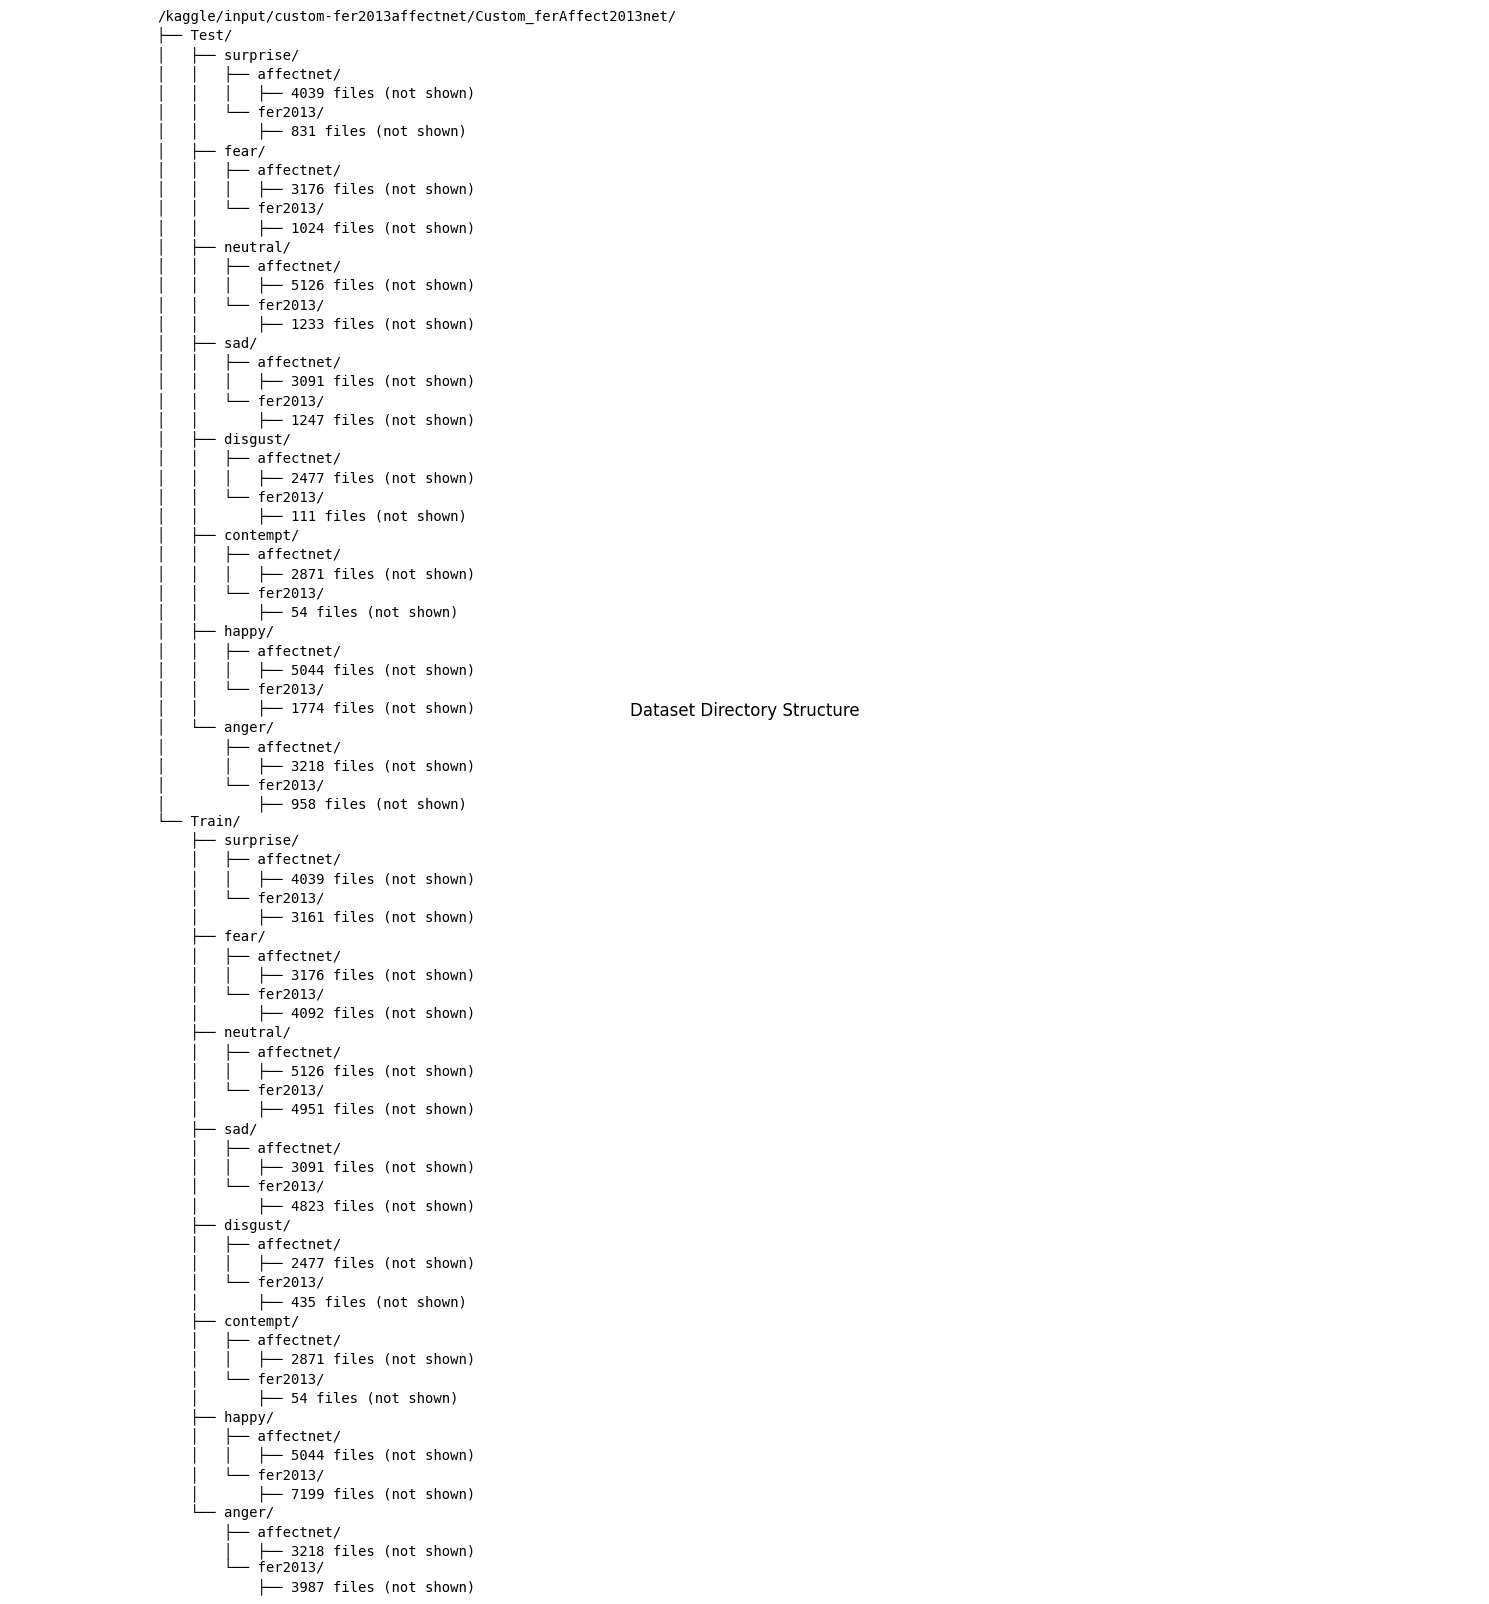

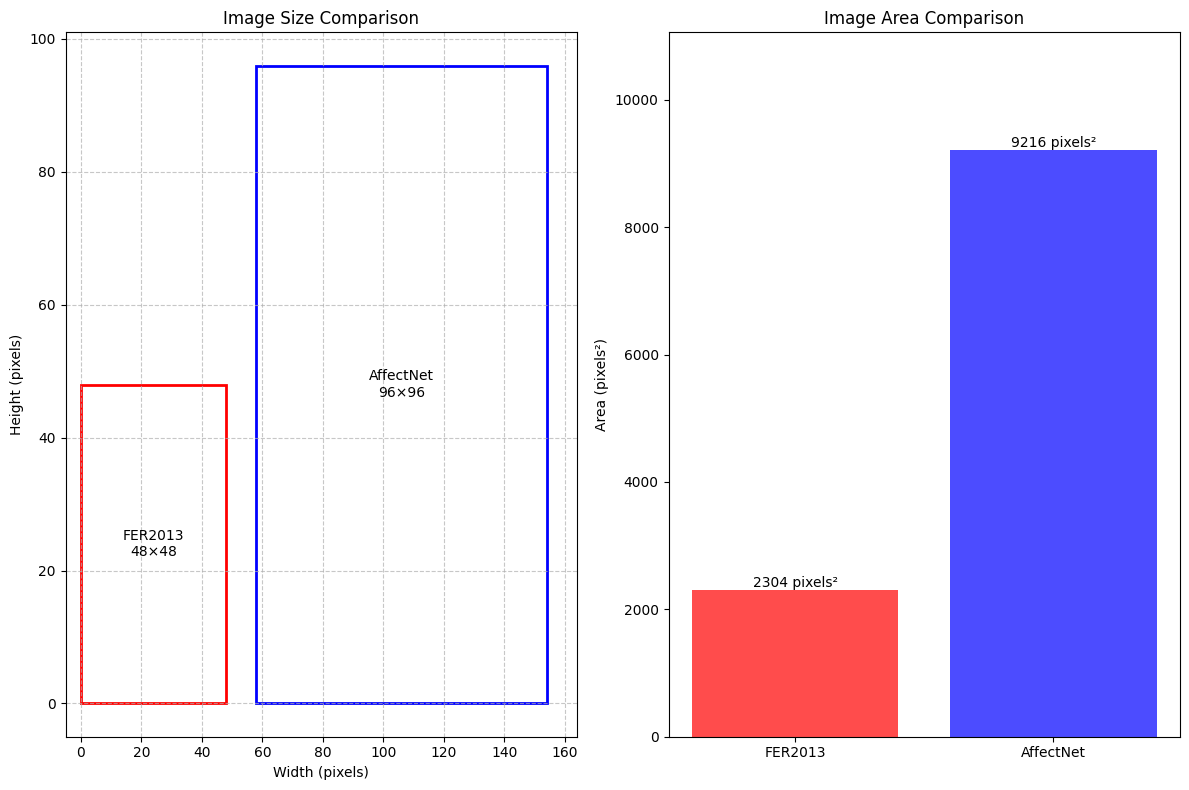

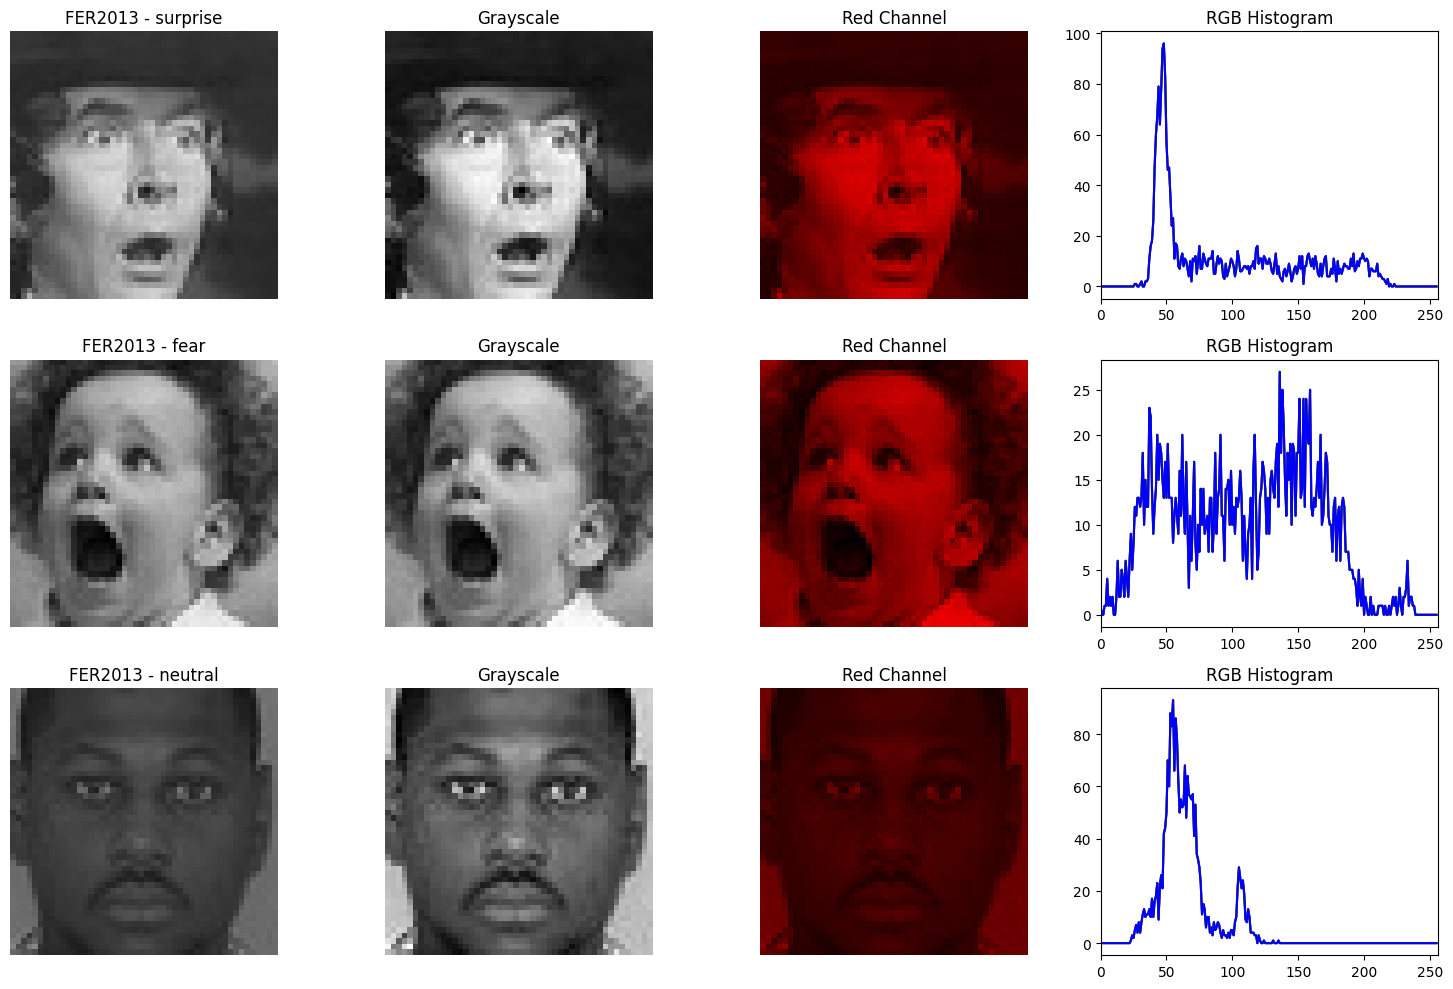

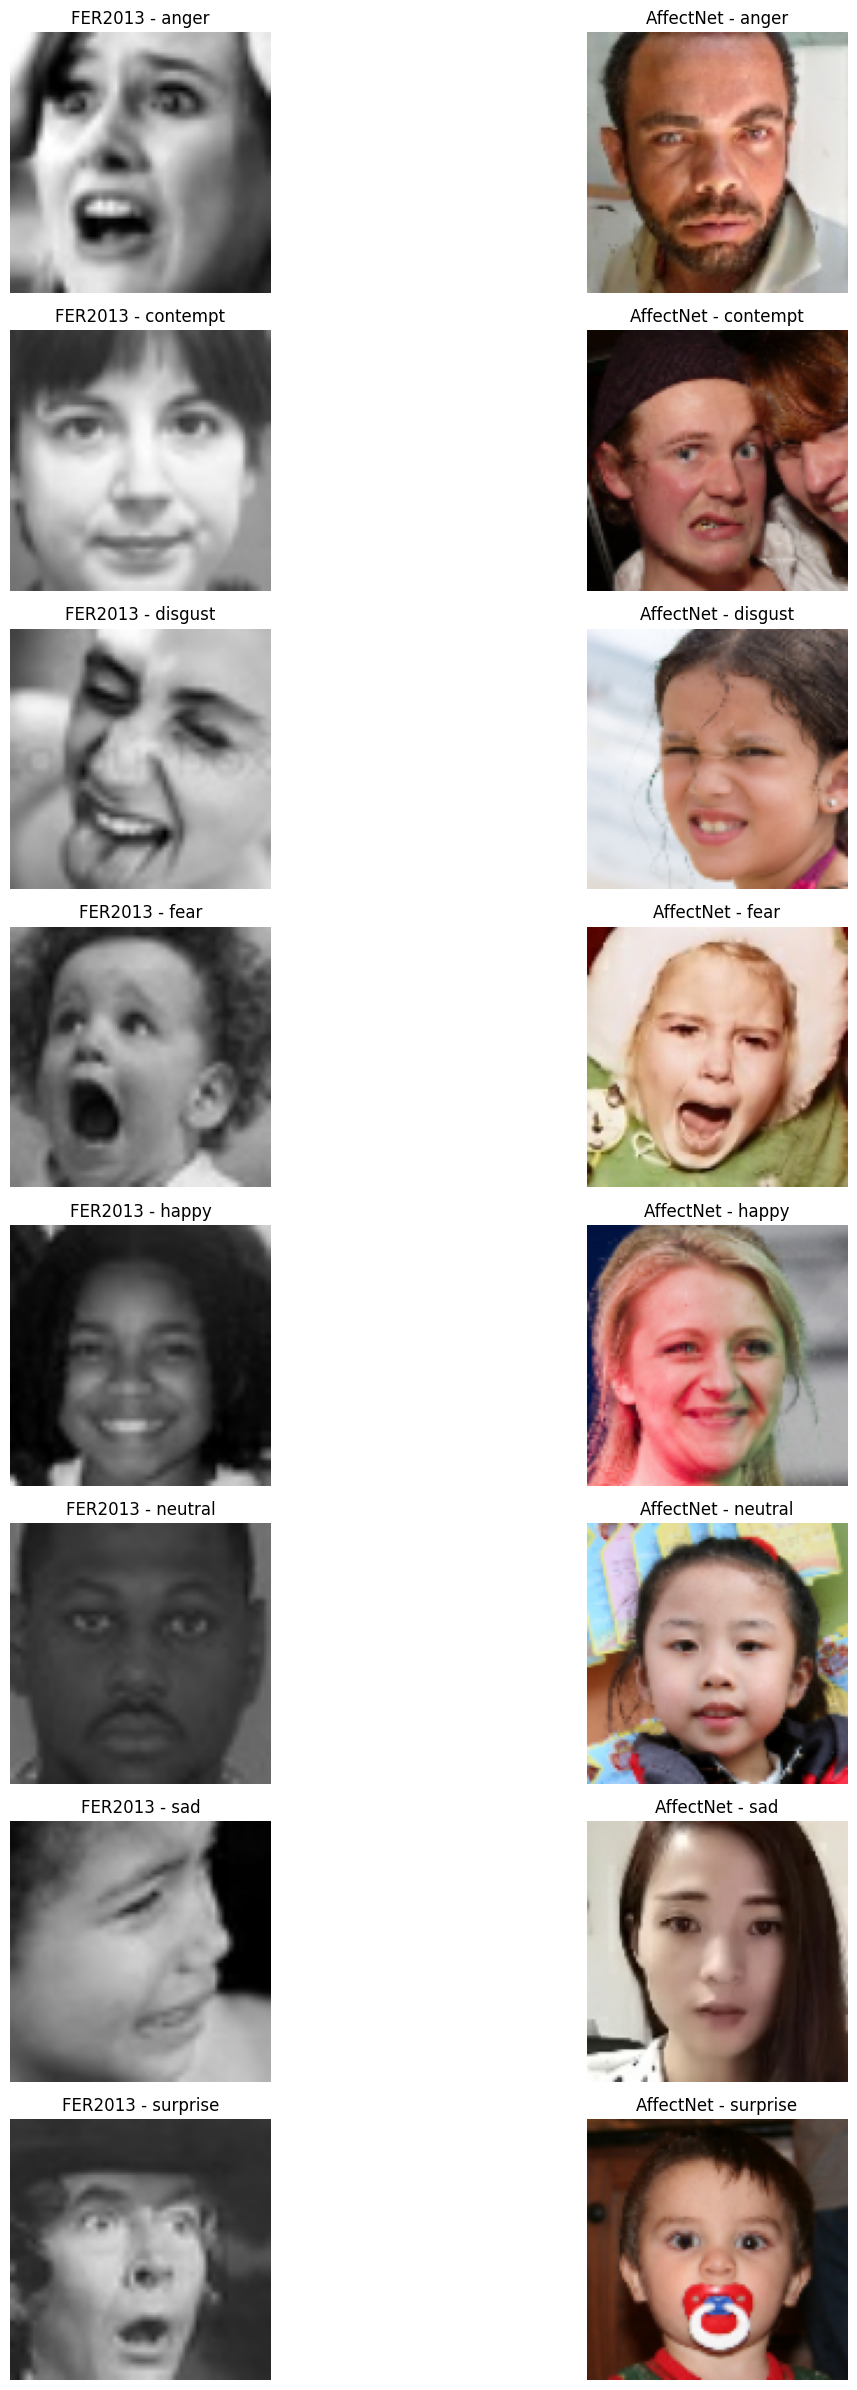

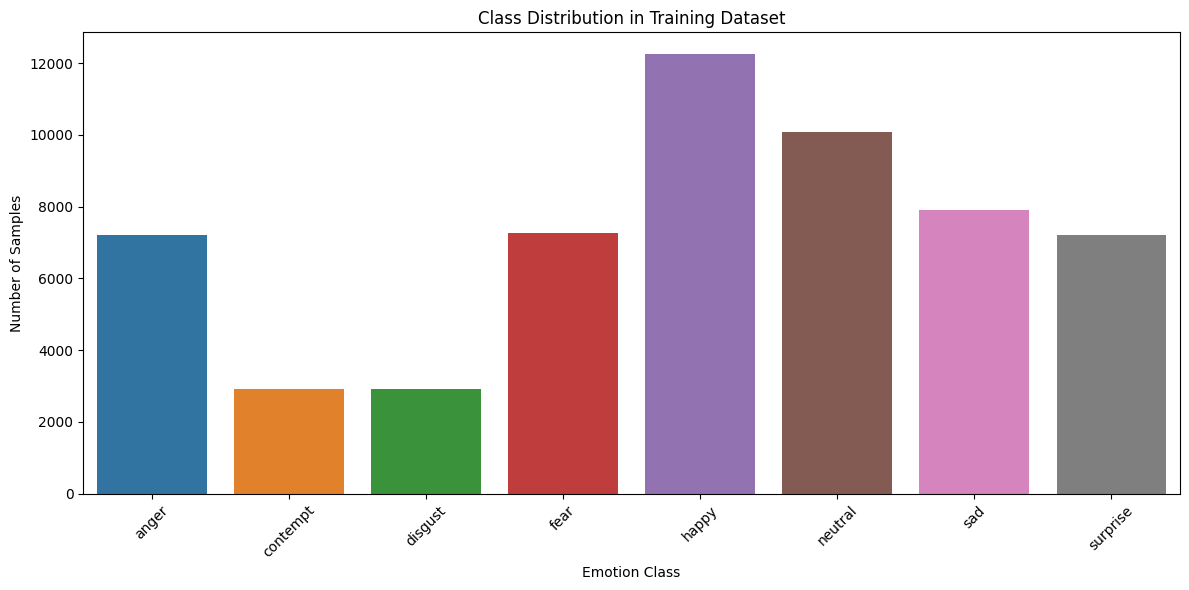

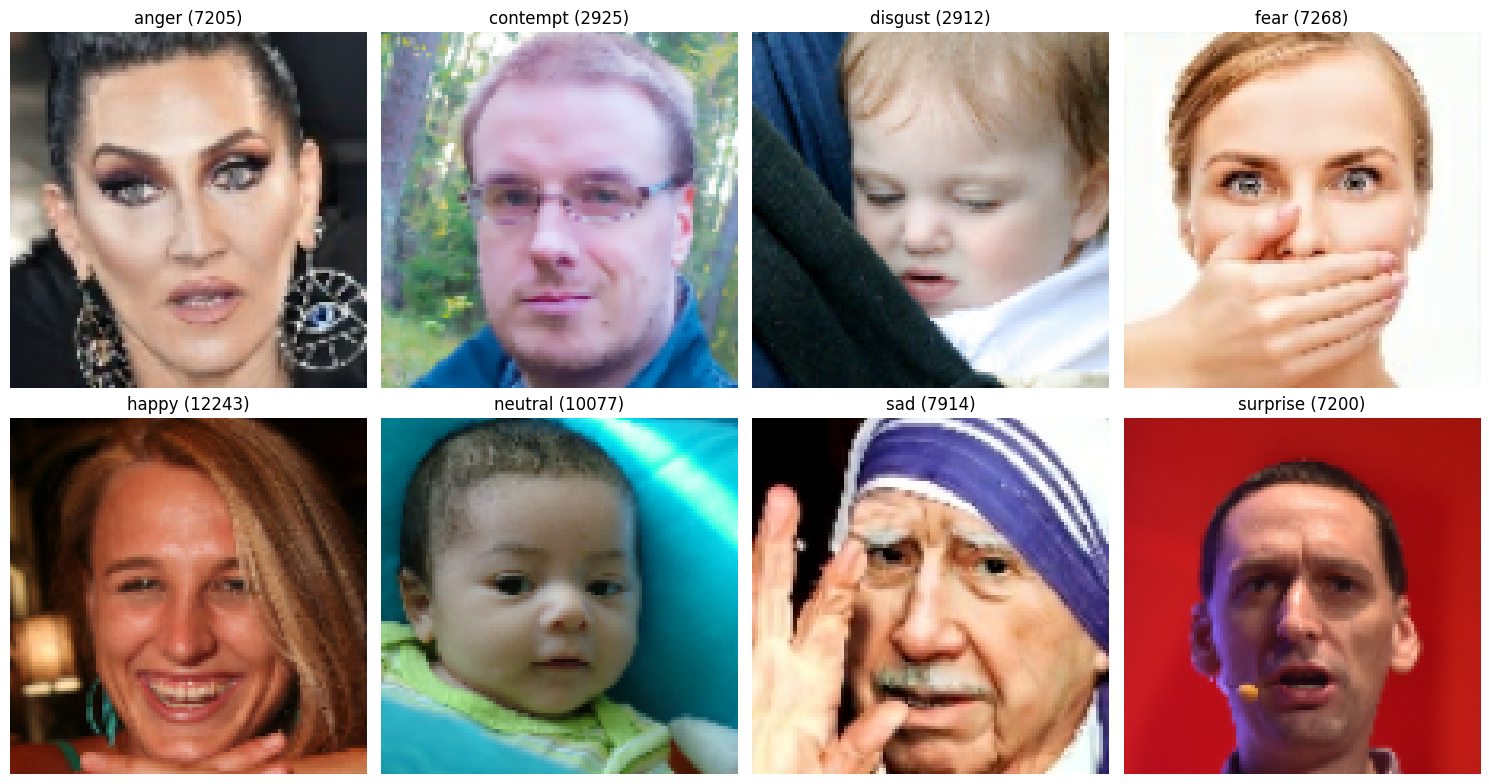

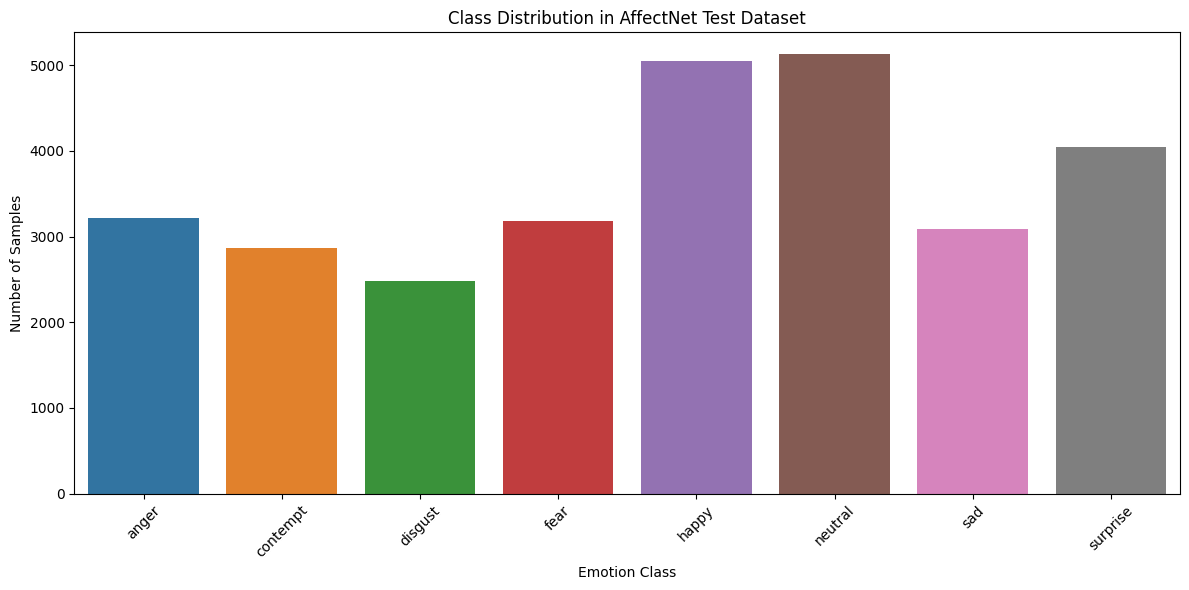

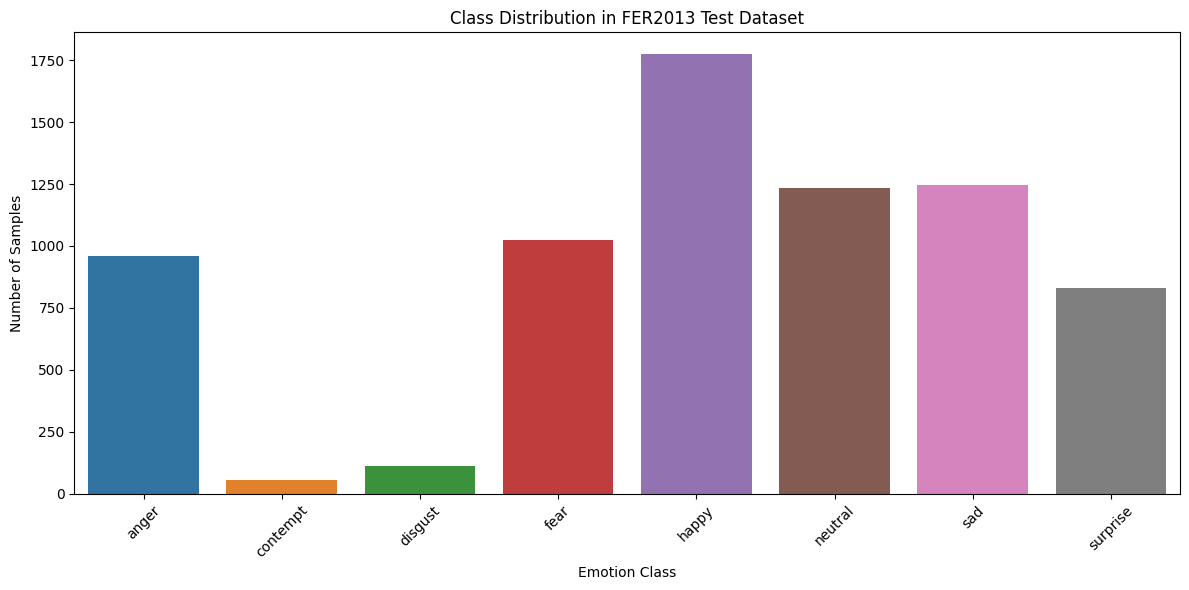

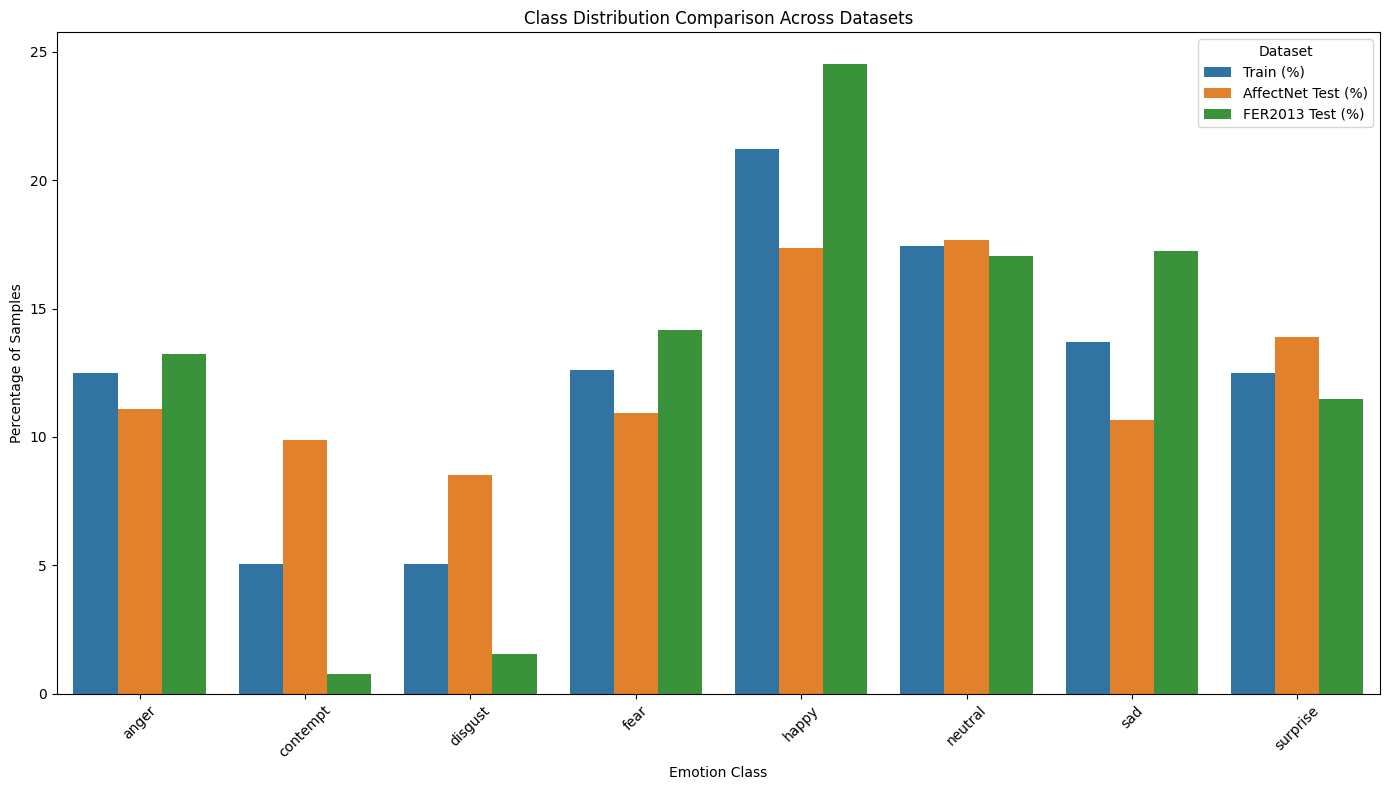

In [4]:
#data analysis 
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import io
import cv2
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Set Seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Configuration 
CONFIG = {
    "BASE_DATA_DIR": "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net",  # Base path
    "TRAIN_DIR": "Train",  # Combined train dir name
    "TEST_DIR": "Test",    # Base test dir name
    "IMG_SIZE": 112,        # Image size for visualization
    "BATCH_SIZE": 32,      # Batch size for dataset loading
    "FER_ORIGINAL_SIZE": 48,  # Original size of FER2013 images
    "AFFECTNET_SIZE": 96      # Original/common size of AffectNet images
}

# =============================================================================
# Data Loading Functions
# =============================================================================

def create_train_tf_dataset(directory, image_size, batch_size):
    """Creates tf.data.Dataset for training data analysis."""
    print(f"Loading training data from: {directory}")

    # Create the dataset
    train_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=False  # Don't shuffle to maintain order for analysis
    )
    
    # Get class names from the training dataset
    class_names = train_ds.class_names
    print(f"Dataset loaded with classes: {class_names}")
    
    return train_ds, class_names

def create_test_dataset_from_structure(base_test_dir, target_dataset, class_names_map, image_size, batch_size):
    """Creates a tf.data.Dataset for testing by finding files in the Test/<emotion>/<target_dataset> structure."""
    print(f"Loading test data for '{target_dataset}' from: {base_test_dir}")
    all_image_paths = []
    all_labels = []

    # Get emotion directories (e.g., 'anger', 'happy')
    emotion_dirs = [d for d in tf.io.gfile.listdir(base_test_dir) 
                   if tf.io.gfile.isdir(os.path.join(base_test_dir, d))]
    
    if not emotion_dirs:
        print(f"Warning: No subdirectories found in {base_test_dir}. Cannot load test data.")
        return None, []
    
    print(f"Found emotion folders: {emotion_dirs}")
    
    class_counts = {}  # Dictionary to store counts per class
    
    for emotion in emotion_dirs:
        if emotion not in class_names_map:
            print(f"Warning: Emotion directory '{emotion}' not found in training class names map. Skipping.")
            continue
            
        label_index = class_names_map[emotion]  # Get the integer label
        target_path = os.path.join(base_test_dir, emotion, target_dataset)
        
        if not tf.io.gfile.exists(target_path):
            print(f"Info: Sub-directory '{target_path}' does not exist. Skipping.")
            continue
            
        # Find all image files
        image_files = tf.io.gfile.glob(os.path.join(target_path, '*.png')) + \
                     tf.io.gfile.glob(os.path.join(target_path, '*.jpg')) + \
                     tf.io.gfile.glob(os.path.join(target_path, '*.jpeg'))
                     
        if not image_files:
            print(f"Warning: No image files found in '{target_path}'.")
            continue
            
        all_image_paths.extend(image_files)
        all_labels.extend([label_index] * len(image_files))
        
        # Store counts for this class
        class_counts[emotion] = len(image_files)
        
        print(f"  Found {len(image_files)} images for emotion '{emotion}' in '{target_dataset}'.")
    
    if not all_image_paths:
        print(f"Error: No images found for target dataset '{target_dataset}' in the specified structure.")
        return None, class_counts
        
    print(f"Total images found for '{target_dataset}' test set: {len(all_image_paths)}")
    
    # Create the dataset from slices
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.one_hot(all_labels, depth=len(class_names_map)))
    
    # Define preprocessing function for loading images
    def load_and_preprocess_image(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, [image_size, image_size], method='nearest')
        image.set_shape((image_size, image_size, 3))
        return image
    
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Combine images and labels
    test_ds = tf.data.Dataset.zip((image_ds, label_ds))
    test_ds = test_ds.batch(batch_size)
    
    return test_ds, class_counts

# =============================================================================
# Analysis Functions
# =============================================================================

def analyze_train_dataset(dataset, class_names):
    """Analyzes the training dataset to get class distribution and example images."""
    print("\n=== Analyzing Training Dataset ===")
    
    all_labels = []
    example_images = {i: None for i in range(len(class_names))}
    example_counts = {i: 0 for i in range(len(class_names))}
    
    # Get sample images for each class and count instances
    print("Extracting class distribution and example images...")
    for images, labels in dataset:
        batch_labels = np.argmax(labels.numpy(), axis=1)
        all_labels.extend(batch_labels)
        
        # Store some example images (first 3 of each class)
        for i, label in enumerate(batch_labels):
            if example_counts[label] < 3 and example_images[label] is None:
                example_images[label] = images[i].numpy()
            example_counts[label] += 1
    
    # Calculate class distribution
    class_counts = Counter(all_labels)
    total_samples = len(all_labels)
    
    # Print the class distribution
    print("\nClass Distribution in Training Data:")
    print(f"{'Class':<15} {'Name':<15} {'Count':<10} {'Percentage':<10}")
    print("-" * 50)
    
    for i in range(len(class_names)):
        count = class_counts.get(i, 0)
        percentage = (count / total_samples) * 100 if total_samples > 0 else 0
        print(f"{i:<15} {class_names[i]:<15} {count:<10} {percentage:.2f}%")
    
    print(f"\nTotal training samples: {total_samples}")
    
    # Plot the class distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(class_names), y=[class_counts.get(i, 0) for i in range(len(class_names))])
    plt.title('Class Distribution in Training Dataset')
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('train_class_distribution.png')
    print("Saved training class distribution plot to 'train_class_distribution.png'")
    
    # Plot example images
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(class_names):
        if example_images[i] is not None:
            plt.subplot(2, 4, i+1)
            plt.imshow(example_images[i].astype("uint8"))
            plt.title(f"{class_name} ({class_counts.get(i, 0)})")
            plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('train_example_images.png')
    print("Saved example images to 'train_example_images.png'")
    
    return class_counts

def analyze_test_dataset(test_counts, dataset_name, class_names):
    """Analyzes the test dataset class distribution."""
    if not test_counts:
        print(f"\nNo {dataset_name} test data available for analysis.")
        return
    
    print(f"\n=== Analyzing {dataset_name} Test Dataset ===")
    
    # Calculate total samples
    total_samples = sum(test_counts.values())
    
    # Print the class distribution
    print(f"\nClass Distribution in {dataset_name} Test Data:")
    print(f"{'Class':<15} {'Name':<15} {'Count':<10} {'Percentage':<10}")
    print("-" * 50)
    
    # Create ordered data for plotting
    ordered_counts = []
    for i, class_name in enumerate(class_names):
        count = test_counts.get(class_name, 0)
        percentage = (count / total_samples) * 100 if total_samples > 0 else 0
        print(f"{i:<15} {class_name:<15} {count:<10} {percentage:.2f}%")
        ordered_counts.append(count)
    
    print(f"\nTotal {dataset_name} test samples: {total_samples}")
    
    # Plot the class distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(class_names), y=ordered_counts)
    plt.title(f'Class Distribution in {dataset_name} Test Dataset')
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{dataset_name.lower()}_test_class_distribution.png')
    print(f"Saved {dataset_name} test class distribution plot to '{dataset_name.lower()}_test_class_distribution.png'")
    
    return ordered_counts

def display_class_imbalance_stats(train_counts, affectnet_counts, fer2013_counts, class_names):
    """Displays comparative statistics about class imbalance across datasets."""
    if not all([train_counts, affectnet_counts, fer2013_counts]):
        print("\nCannot perform complete class imbalance analysis due to missing data.")
        return
    
    # Convert to numpy arrays for easier manipulation
    train_array = np.array([train_counts.get(i, 0) for i in range(len(class_names))])
    affectnet_array = np.array(affectnet_counts)
    fer2013_array = np.array(fer2013_counts)
    
    # Calculate statistics
    mean_train = np.mean(train_array)
    std_train = np.std(train_array)
    cv_train = std_train / mean_train if mean_train > 0 else 0  # Coefficient of variation
    
    max_to_min_train = np.max(train_array) / np.min(train_array) if np.min(train_array) > 0 else np.inf
    
    # Print imbalance statistics
    print("\n=== Class Imbalance Statistics ===")
    print(f"Training dataset:")
    print(f"  Mean samples per class: {mean_train:.2f}")
    print(f"  Standard deviation: {std_train:.2f}")
    print(f"  Coefficient of variation: {cv_train:.4f} (higher = more imbalanced)")
    print(f"  Max/Min ratio: {max_to_min_train:.2f} (higher = more imbalanced)")
    
    # Plot comparative distribution
    plt.figure(figsize=(14, 8))
    
    # Normalize counts to percentages for better comparison
    train_pct = train_array / np.sum(train_array) * 100 if np.sum(train_array) > 0 else np.zeros_like(train_array)
    affectnet_pct = affectnet_array / np.sum(affectnet_array) * 100 if np.sum(affectnet_array) > 0 else np.zeros_like(affectnet_array)
    fer2013_pct = fer2013_array / np.sum(fer2013_array) * 100 if np.sum(fer2013_array) > 0 else np.zeros_like(fer2013_array)
    
    # Create dataframe for plotting
    data = []
    for i, class_name in enumerate(class_names):
        data.append({
            'Class': class_name,
            'Train (%)': train_pct[i],
            'AffectNet Test (%)': affectnet_pct[i],
            'FER2013 Test (%)': fer2013_pct[i]
        })
    
    df = pd.DataFrame(data)
    
    # Plot
    df_melted = pd.melt(df, id_vars=['Class'], var_name='Dataset', value_name='Percentage')
    sns.barplot(x='Class', y='Percentage', hue='Dataset', data=df_melted)
    plt.title('Class Distribution Comparison Across Datasets')
    plt.xlabel('Emotion Class')
    plt.ylabel('Percentage of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_distribution_comparison.png')
    print("Saved comparative class distribution plot to 'class_distribution_comparison.png'")

def find_class_outliers(train_counts, class_names):
    """Identifies outlier classes in terms of sample count."""
    counts_array = np.array([train_counts.get(i, 0) for i in range(len(class_names))])
    mean_count = np.mean(counts_array)
    std_count = np.std(counts_array)
    
    print("\n=== Class Sample Count Outlier Analysis ===")
    print(f"Mean samples per class: {mean_count:.2f}")
    print(f"Standard deviation: {std_count:.2f}")
    
    # Classes with significantly fewer samples (Z-score < -1)
    underrepresented = []
    for i, count in enumerate(counts_array):
        z_score = (count - mean_count) / std_count if std_count > 0 else 0
        if z_score < -1:
            underrepresented.append((class_names[i], count, z_score))
    
    if underrepresented:
        print("\nUnderrepresented classes (Z-score < -1):")
        for name, count, z in underrepresented:
            print(f"  {name}: {count} samples (Z-score: {z:.2f})")
    else:
        print("\nNo significantly underrepresented classes found.")
    
    # Classes with significantly more samples (Z-score > 1)
    overrepresented = []
    for i, count in enumerate(counts_array):
        z_score = (count - mean_count) / std_count if std_count > 0 else 0
        if z_score > 1:
            overrepresented.append((class_names[i], count, z_score))
    
    if overrepresented:
        print("\nOverrepresented classes (Z-score > 1):")
        for name, count, z in overrepresented:
            print(f"  {name}: {count} samples (Z-score: {z:.2f})")
    else:
        print("\nNo significantly overrepresented classes found.")

# =============================================================================
# New Visualization Functions for Directory Structure and Image Properties
# =============================================================================

def visualize_directory_structure(base_path):
    """Creates a graphical display of the directory structure."""
    print("\n=== Visualizing Directory Structure ===")
    
    # Function to get directory structure recursively
    def get_tree(dir_path, prefix="", is_last=True, max_depth=3, current_depth=0):
        if current_depth > max_depth:
            return []
        
        output = []
        current_prefix = prefix
        if current_depth > 0:
            connector = "└── " if is_last else "├── "
            current_prefix = prefix + connector
            output.append(current_prefix + os.path.basename(dir_path) + "/")
            prefix = prefix + ("    " if is_last else "│   ")
        
        try:
            entries = list(os.listdir(dir_path))
            dirs = [e for e in entries if os.path.isdir(os.path.join(dir_path, e))]
            files = [e for e in entries if not os.path.isdir(os.path.join(dir_path, e))]
            
            # Count files if there are too many to list
            if len(files) > 5:
                output.append(prefix + f"├── {len(files)} files (not shown)")
            else:
                for i, file in enumerate(files):
                    connector = "└── " if i == len(files) - 1 and len(dirs) == 0 else "├── "
                    output.append(prefix + connector + file)
                    
            # Process directories
            for i, d in enumerate(dirs):
                is_last_dir = (i == len(dirs) - 1)
                output.extend(get_tree(os.path.join(dir_path, d), prefix, is_last_dir, 
                                      max_depth, current_depth + 1))
                
        except (PermissionError, FileNotFoundError) as e:
            output.append(prefix + f"  Error: {str(e)}")
        
        return output
    
    # Generate the tree structure as text
    tree_lines = get_tree(base_path)
    
    # Create a figure with text representation
    plt.figure(figsize=(15, 10))
    plt.text(0.1, 0.5, "\n".join([base_path + "/"] + tree_lines), 
             fontsize=10, fontfamily='monospace', va='center')
    plt.axis('off')
    plt.title("Dataset Directory Structure")
    plt.tight_layout()
    plt.savefig('directory_structure.png')
    print("Saved directory structure visualization to 'directory_structure.png'")
    
    return tree_lines

def visualize_image_dimensions(base_test_dir, class_names_map):
    """Creates a visualization showing image dimensions for both datasets."""
    print("\n=== Analyzing Image Dimensions ===")
    
    # Setup for counting dimensions
    fer_dimensions = {}
    affectnet_dimensions = {}
    
    # Get emotion directories
    emotion_dirs = [d for d in tf.io.gfile.listdir(base_test_dir) 
                   if tf.io.gfile.isdir(os.path.join(base_test_dir, d))]
    
    # Check images from both datasets to get dimensions
    for emotion in emotion_dirs:
        if emotion not in class_names_map:
            continue
            
        # Check FER2013 images
        fer_path = os.path.join(base_test_dir, emotion, "fer2013")
        if tf.io.gfile.exists(fer_path):
            image_files = tf.io.gfile.glob(os.path.join(fer_path, '*.png')) + \
                         tf.io.gfile.glob(os.path.join(fer_path, '*.jpg')) + \
                         tf.io.gfile.glob(os.path.join(fer_path, '*.jpeg'))
            
            for img_path in image_files[:5]:  # Sample up to 5 images
                try:
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    height, width = img.shape[0], img.shape[1]
                    dim_key = f"{height}x{width}"
                    if dim_key in fer_dimensions:
                        fer_dimensions[dim_key] += 1
                    else:
                        fer_dimensions[dim_key] = 1
                except Exception as e:
                    print(f"Error reading FER image {img_path}: {e}")
        
        # Check AffectNet images
        affectnet_path = os.path.join(base_test_dir, emotion, "affectnet")
        if tf.io.gfile.exists(affectnet_path):
            image_files = tf.io.gfile.glob(os.path.join(affectnet_path, '*.png')) + \
                         tf.io.gfile.glob(os.path.join(affectnet_path, '*.jpg')) + \
                         tf.io.gfile.glob(os.path.join(affectnet_path, '*.jpeg'))
            
            for img_path in image_files[:5]:  # Sample up to 5 images
                try:
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    height, width = img.shape[0], img.shape[1]
                    dim_key = f"{height}x{width}"
                    if dim_key in affectnet_dimensions:
                        affectnet_dimensions[dim_key] += 1
                    else:
                        affectnet_dimensions[dim_key] = 1
                except Exception as e:
                    print(f"Error reading AffectNet image {img_path}: {e}")
    
    print(f"FER2013 dimensions detected: {fer_dimensions}")
    print(f"AffectNet dimensions detected: {affectnet_dimensions}")
    
    # Create visualization of the dimensions and dataset sizes
    plt.figure(figsize=(12, 8))
    
    # Size comparison visualization
    ax1 = plt.subplot(1, 2, 1)
    # Draw image size comparisons
    fer_size = CONFIG["FER_ORIGINAL_SIZE"]
    affectnet_size = CONFIG["AFFECTNET_SIZE"]
    
    # FER rectangle
    fer_rect = patches.Rectangle((0, 0), fer_size, fer_size, linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(fer_rect)
    ax1.text(fer_size/2, fer_size/2, f"FER2013\n{fer_size}×{fer_size}", ha='center', va='center')
    
    # AffectNet rectangle
    affectnet_rect = patches.Rectangle((fer_size + 10, 0), affectnet_size, affectnet_size, 
                                      linewidth=2, edgecolor='b', facecolor='none')
    ax1.add_patch(affectnet_rect)
    ax1.text(fer_size + 10 + affectnet_size/2, affectnet_size/2, 
             f"AffectNet\n{affectnet_size}×{affectnet_size}", ha='center', va='center')
    
    # Set limits and labels
    ax1.set_xlim(-5, fer_size + affectnet_size + 20)
    ax1.set_ylim(-5, max(fer_size, affectnet_size) + 5)
    ax1.set_title("Image Size Comparison")
    ax1.set_xlabel("Width (pixels)")
    ax1.set_ylabel("Height (pixels)")
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Area comparison
    ax2 = plt.subplot(1, 2, 2)
    datasets = ['FER2013', 'AffectNet']
    sizes = [fer_size**2, affectnet_size**2]  # Area in pixels
    bars = ax2.bar(datasets, sizes, color=['r', 'b'], alpha=0.7)
    
    # Add pixel count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)} pixels²', ha='center', va='bottom')
    
    ax2.set_title('Image Area Comparison')
    ax2.set_ylabel('Area (pixels²)')
    ax2.set_ylim(0, max(sizes) * 1.2)  # Add some space above bars for labels
    
    plt.tight_layout()
    plt.savefig('image_dimensions_comparison.png')
    print("Saved image dimensions visualization to 'image_dimensions_comparison.png'")

def visualize_grayscale_vs_rgb(base_test_dir, class_names_map):
    """Creates a visualization showing examples of grayscale and RGB images."""
    print("\n=== Visualizing Grayscale vs RGB Examples ===")
    
    # Setup to store example images
    fer_images = []
    affectnet_images = []
    
    # Get emotion directories
    emotion_dirs = [d for d in tf.io.gfile.listdir(base_test_dir) 
                   if tf.io.gfile.isdir(os.path.join(base_test_dir, d))]
    
    # Get sample images from each dataset
    for emotion in emotion_dirs:
        if emotion not in class_names_map or len(fer_images) >= 3:
            continue  # Stop after getting 3 examples
            
        # Get FER2013 image
        fer_path = os.path.join(base_test_dir, emotion, "fer2013")
        if tf.io.gfile.exists(fer_path) and len(fer_images) < 3:
            image_files = tf.io.gfile.glob(os.path.join(fer_path, '*.png')) + \
                         tf.io.gfile.glob(os.path.join(fer_path, '*.jpg'))
            
            if image_files:
                try:
                    img_path = image_files[0]
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    fer_images.append((img.numpy(), emotion))
                except Exception as e:
                    print(f"Error reading FER image: {e}")
        
        # Get AffectNet image
        affectnet_path = os.path.join(base_test_dir, emotion, "affectnet")
        if tf.io.gfile.exists(affectnet_path) and len(affectnet_images) < 3:
            image_files = tf.io.gfile.glob(os.path.join(affectnet_path, '*.png')) + \
                         tf.io.gfile.glob(os.path.join(affectnet_path, '*.jpg'))
            
            if image_files:
                try:
                    img_path = image_files[0]
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    affectnet_images.append((img.numpy(), emotion))
                except Exception as e:
                    print(f"Error reading AffectNet image: {e}")
    
    # Create figure to visualize grayscale vs RGB
    plt.figure(figsize=(15, 10))
    
    # FER2013 (commonly grayscale) examples
    for i, (img, emotion) in enumerate(fer_images):
        if i >= 3:
            break
            
        # Original image
        plt.subplot(3, 4, i*4+1)
        plt.imshow(img)
        plt.title(f"FER2013 - {emotion}")
        plt.axis('off')
        
        # Grayscale channels visualization
        plt.subplot(3, 4, i*4+2)
        gs_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plt.imshow(gs_img, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')
        
        # RGB channels visualization
        # Red channel
        plt.subplot(3, 4, i*4+3)
        r_channel = np.zeros_like(img)
        r_channel[:,:,0] = img[:,:,0]
        plt.imshow(r_channel)
        plt.title("Red Channel")
        plt.axis('off')
        
        # RGB histogram
        plt.subplot(3, 4, i*4+4)
        color = ('red', 'green', 'blue')
        for j, col in enumerate(color):
            histr = cv2.calcHist([img], [j], None, [256], [0,256])
            plt.plot(histr, color=col)
        plt.title("RGB Histogram")
        plt.xlim([0, 256])
    
    plt.tight_layout()
    plt.savefig('grayscale_vs_rgb_examples.png')
    print("Saved grayscale vs RGB visualization to 'grayscale_vs_rgb_examples.png'")
    
    return fer_images, affectnet_images

def collect_examples_per_class(base_test_dir, class_names_map, class_names):
    """Collects example images from each emotion class for both datasets."""
    print("\n=== Collecting Example Images for Each Class ===")
    
    # Dictionary to store examples
    fer_examples = {emotion: None for emotion in class_names}
    affectnet_examples = {emotion: None for emotion in class_names}
    
    # Get emotion directories
    for emotion in class_names:
        emotion_path = os.path.join(base_test_dir, emotion)
        if not tf.io.gfile.exists(emotion_path):
            continue
            
        # Get FER2013 example
        fer_path = os.path.join(emotion_path, "fer2013")
        if tf.io.gfile.exists(fer_path):
            image_files = tf.io.gfile.glob(os.path.join(fer_path, '*.png')) + \
                         tf.io.gfile.glob(os.path.join(fer_path, '*.jpg')) + \
                         tf.io.gfile.glob(os.path.join(fer_path, '*.jpeg'))
            
            if image_files:
                try:
                    img_path = image_files[0]
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    img = tf.image.resize(img, [CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]])
                    fer_examples[emotion] = img.numpy()
                except Exception as e:
                    print(f"Error reading FER example for {emotion}: {e}")
        
        # Get AffectNet example
        affectnet_path = os.path.join(emotion_path, "affectnet")
        if tf.io.gfile.exists(affectnet_path):
            image_files = tf.io.gfile.glob(os.path.join(affectnet_path, '*.png')) + \
                         tf.io.gfile.glob(os.path.join(affectnet_path, '*.jpg')) + \
                         tf.io.gfile.glob(os.path.join(affectnet_path, '*.jpeg'))
            
            if image_files:
                try:
                    img_path = image_files[0]
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3, expand_animations=False)
                    img = tf.image.resize(img, [CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]])
                    affectnet_examples[emotion] = img.numpy()
                except Exception as e:
                    print(f"Error reading AffectNet example for {emotion}: {e}")
    
    # Create visualization with examples from both datasets for each class
    plt.figure(figsize=(15, len(class_names) * 3))
    
    for i, emotion in enumerate(class_names):
        # FER2013 example
        plt.subplot(len(class_names), 2, i*2+1)
        if fer_examples[emotion] is not None:
            plt.imshow(fer_examples[emotion].astype("uint8"))
            plt.title(f"FER2013 - {emotion}")
        else:
            plt.text(0.5, 0.5, "No example", ha='center', va='center')
            plt.title(f"FER2013 - {emotion} (missing)")
        plt.axis('off')
        
        # AffectNet example
        plt.subplot(len(class_names), 2, i*2+2)
        if affectnet_examples[emotion] is not None:
            plt.imshow(affectnet_examples[emotion].astype("uint8"))
            plt.title(f"AffectNet - {emotion}")
        else:
            plt.text(0.5, 0.5, "No example", ha='center', va='center')
            plt.title(f"AffectNet - {emotion} (missing)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('class_examples_comparison.png')
    print("Saved class examples comparison to 'class_examples_comparison.png'")

# =============================================================================
# Main Execution
# =============================================================================

def main():
    # Load the training dataset
    train_dir = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TRAIN_DIR"])
    train_ds, class_names = create_train_tf_dataset(train_dir, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"])
    
    # Create a mapping from class name to integer index for test set loading
    class_names_map = {name: i for i, name in enumerate(class_names)}
    
    # Load test datasets
    base_test_dir_path = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TEST_DIR"])
    affectnet_test_ds, affectnet_counts = create_test_dataset_from_structure(
        base_test_dir_path, "affectnet", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]
    )
    
    fer2013_test_ds, fer2013_counts = create_test_dataset_from_structure(
        base_test_dir_path, "fer2013", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]
    )
    
    # NEW: Visualize directory structure
    visualize_directory_structure(CONFIG["BASE_DATA_DIR"])
    
    # NEW: Visualize image dimensions
    visualize_image_dimensions(base_test_dir_path, class_names_map)
    
    # NEW: Visualize grayscale vs RGB examples
    fer_images, affectnet_images = visualize_grayscale_vs_rgb(base_test_dir_path, class_names_map)
    
    # NEW: Collect example images for each class from both datasets
    collect_examples_per_class(base_test_dir_path, class_names_map, class_names)
    
    # Analyze datasets
    train_counts = analyze_train_dataset(train_ds, class_names)
    affectnet_test_counts = analyze_test_dataset(affectnet_counts, "AffectNet", class_names)
    fer2013_test_counts = analyze_test_dataset(fer2013_counts, "FER2013", class_names)
    
    # Additional analyses
    find_class_outliers(train_counts, class_names)
    display_class_imbalance_stats(train_counts, affectnet_test_counts, fer2013_test_counts, class_names)
    
    print("\nData analysis complete!")

if __name__ == "__main__":
    main()

In [ ]:
# Revised Code based on NEW_CODEx.txt and recommendations
# Version 3.3 (AdamW, Label Smoothing, Ensemble Weight Optimization)

#=== FINAL RESULTS === 144
#(Using Optimized Ensemble Weights: [0.25, 0.75])
#--- Ensemble Performance ---
#Ensemble AffectNet Test Accuracy: 0.81
#Ensemble FER2013 Test Accuracy: 0.57


#=== FINAL RESULTS === 112
#(Using Optimized Ensemble Weights: [0.4, 0.6])
#--- Individual Model Performance ---
#EfficientNetB0 AffectNet Test Accuracy: 0.7484, F1: 0.7463
#EfficientNetB0 FER2013 Test Accuracy: 0.5571, F1: 0.5547
#EfficientNetB4 AffectNet Test Accuracy: 0.8341, F1: 0.8344
#EfficientNetB4 FER2013 Test Accuracy: 0.5599, F1: 0.5599
#--- Ensemble Performance ---
#Ensemble AffectNet Test Accuracy: 0.8508
#Ensemble AffectNet F1 Score: 0.8511
#Ensemble FER2013 Test Accuracy: 0.5915
#Ensemble FER2013 F1 Score: 0.5906

#=== FINAL RESULTS === 160
#(Using Optimized Ensemble Weights: [0.35, 0.64])
#--- Individual Model Performance ---
#EfficientNetB0 AffectNet Test Accuracy: 0.7124, F1: 0.7089
#EfficientNetB0 FER2013 Test Accuracy: 0.5722, F1: 0.5702
#EfficientNetB4 AffectNet Test Accuracy: 0.7912, F1: 0.7912
#EfficientNetB4 FER2013 Test Accuracy: 0.5400, F1: 0.5400
#--- Ensemble Performance ---
#Ensemble AffectNet Test Accuracy: 0.8090
#Ensemble AffectNet F1 Score: 0.8083
#Ensemble FER2013 Test Accuracy: 0.5784
#Ensemble FER2013 F1 Score: 0.5761



import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score # Added accuracy_score
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Average
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime
import math
import glob # Needed for finding files

# =============================================================================
# Configuration Dictionary
# =============================================================================
CONFIG = {
    "SEED": 42,
    "BASE_DATA_DIR": "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net", # Base path [cite: 1]
    "TRAIN_DIR": "Train", # Combined train dir name [cite: 1]
    "TEST_DIR": "Test",   # Base test dir name [cite: 2]
    "IMG_SIZE": 104, # 224= accuracy 0.49 / 380=x / 336=x (160px, 192px, or 256px)
    "BATCH_SIZE": 32, # Keep user's tuned value [cite: 2]
    "BUFFER_SIZE": tf.data.AUTOTUNE, # [cite: 2]
    "EPOCHS_HEAD": 50, # Keep user's tuned value [cite: 2]
    "EPOCHS_FINE_TUNE": 100, # Keep user's tuned value [cite: 2]
    "LR_HEAD": 1e-3, # [cite: 2]
    "LR_FINE_TUNE_START": 1e-4, # [cite: 2]
    "DROPOUT_RATE": 0.4, # [cite: 2]
    "NUM_CLASSES": 8, # [cite: 2]
    "MODEL_ARCH_1": "EfficientNetB0", # [cite: 2]
    "MODEL_ARCH_2": "EfficientNetB4", # [cite: 2]
    "ENSEMBLE_WEIGHTS": [0.5, 0.5], # Initial value, will be optimized later [cite: 2]
    "FINE_TUNE_LAYERS_B0": 15, # Keep user's tuned value [cite: 3]
    "FINE_TUNE_LAYERS_B4": 20, # Keep user's tuned value [cite: 3]
    "LOG_DIR_BASE": "logs/fit/", # [cite: 3]

    # --- NEW: Added Parameters ---
    "WEIGHT_DECAY": 1e-5, # Recommended value for AdamW, tune if needed
    "LABEL_SMOOTHING": 0.1, # Common value for label smoothing
}

# Set Seed
tf.random.set_seed(CONFIG["SEED"]) # [cite: 3]
np.random.seed(CONFIG["SEED"]) # [cite: 3]

# =============================================================================
# GPU Configuration & Mixed Precision (Same as before)
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU') # [cite: 3]
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # [cite: 3]
        print(f"Found {len(gpus)} GPUs: Memory growth enabled") # [cite: 3]
    except RuntimeError as e:
        print(f"GPU error: {e}") # [cite: 3]
else:
    print("No GPU detected. Running on CPU.") # [cite: 3]

policy = tf.keras.mixed_precision.Policy('mixed_float16') # [cite: 4]
tf.keras.mixed_precision.set_global_policy(policy) # [cite: 4]
print("Mixed precision enabled ('mixed_float16')") # [cite: 4]

# =============================================================================
# Data Loading (Train/Validation - Standard; Test - Custom)
# =============================================================================

def create_train_val_tf_dataset(directory, image_size, batch_size, validation_split=0.2): # [cite: 4]
    """Creates tf.data.Dataset for training and validation using image_dataset_from_directory."""
    print(f"Loading training/validation data from: {directory}") # [cite: 4]

    # Create the training dataset
    train_ds = tf.keras.utils.image_dataset_from_directory( # [cite: 4]
        directory,
        labels='inferred', # [cite: 4]
        label_mode='categorical', # [cite: 4]
        image_size=(image_size, image_size), # [cite: 4]
        interpolation='nearest', # [cite: 4]
        batch_size=batch_size, # [cite: 5]
        shuffle=True, # [cite: 5]
        seed=CONFIG["SEED"], # [cite: 5]
        validation_split=validation_split, # [cite: 5]
        subset="training", # [cite: 5]
    )

    # Create the validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory( # [cite: 5]
        directory,
        labels='inferred', # [cite: 5]
        label_mode='categorical', # [cite: 5]
        image_size=(image_size, image_size), # [cite: 5]
        interpolation='nearest', # [cite: 5]
        batch_size=batch_size, # [cite: 6]
        shuffle=False, # No need to shuffle validation [cite: 6]
        seed=CONFIG["SEED"], # [cite: 6]
        validation_split=validation_split, # [cite: 6]
        subset="validation", # [cite: 6]
    )

    # Get class names from the training dataset BEFORE optimization
    class_names = train_ds.class_names # [cite: 6]
    print(f"Dataset loaded with classes: {class_names}") # [cite: 6]

    # Configure performance for both datasets
    train_ds = train_ds.cache().prefetch(buffer_size=CONFIG["BUFFER_SIZE"]) # [cite: 6]
    val_ds = val_ds.cache().prefetch(buffer_size=CONFIG["BUFFER_SIZE"]) # [cite: 6]

    return train_ds, val_ds, class_names # [cite: 6]

# --- NEW: Function to load test data from the specific structure ---
def create_test_dataset_from_structure(base_test_dir, target_dataset, class_names_map, image_size, batch_size): # [cite: 7]
    """
    Creates a tf.data.Dataset for testing by manually finding files in the Test/<emotion>/<target_dataset> structure. [cite: 7]
    """
    print(f"Loading test data for '{target_dataset}' from: {base_test_dir}") # [cite: 8]
    all_image_paths = [] # [cite: 8]
    all_labels = [] # [cite: 8]

    # Get emotion directories (e.g., 'anger', 'happy')
    emotion_dirs = [d for d in tf.io.gfile.listdir(base_test_dir) if tf.io.gfile.isdir(os.path.join(base_test_dir, d))] # [cite: 8]
    if not emotion_dirs: # [cite: 8]
         print(f"Warning: No subdirectories found in {base_test_dir}. Cannot load test data.") # [cite: 8]
         return None # [cite: 8]

    print(f"Found emotion folders: {emotion_dirs}") # [cite: 8]

    for emotion in emotion_dirs: # [cite: 8]
         if emotion not in class_names_map: # [cite: 9]
            print(f"Warning: Emotion directory '{emotion}' not found in training class names map. Skipping.") # [cite: 9]
            continue # [cite: 9]

         label_index = class_names_map[emotion] # Get the integer label [cite: 9]
         target_path = os.path.join(base_test_dir, emotion, target_dataset) # [cite: 9]

         if not tf.io.gfile.exists(target_path): # [cite: 9]
             print(f"Info: Sub-directory '{target_path}' does not exist. Skipping.") # [cite: 9]
             continue # Skip if the specific dataset subdir doesn't exist for this emotion [cite: 10]

        # Find all image files (adjust extensions if needed)
         image_files = tf.io.gfile.glob(os.path.join(target_path, '*.png')) + \
                      tf.io.gfile.glob(os.path.join(target_path, '*.jpg')) + \
                      tf.io.gfile.glob(os.path.join(target_path, '*.jpeg')) # [cite: 10]

         if not image_files: # [cite: 11]
             print(f"Warning: No image files found in '{target_path}'.") # [cite: 11]
             continue # [cite: 11]

         all_image_paths.extend(image_files) # [cite: 11]
         all_labels.extend([label_index] * len(image_files)) # [cite: 11]
         print(f"  Found {len(image_files)} images for emotion '{emotion}' in '{target_dataset}'.") # [cite: 11]

    if not all_image_paths: # [cite: 11]
        print(f"Error: No images found for target dataset '{target_dataset}' in the specified structure.") # [cite: 12]
        return None # [cite: 12]

    print(f"Total images found for '{target_dataset}' test set: {len(all_image_paths)}") # [cite: 12]

    # Create the dataset from slices
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths) # [cite: 12]
    label_ds = tf.data.Dataset.from_tensor_slices(tf.one_hot(all_labels, depth=CONFIG["NUM_CLASSES"])) # Convert labels to one-hot [cite: 12]
    image_ds = path_ds.map(lambda x: load_and_preprocess_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE) # [cite: 12]

    # Combine images and labels
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds)) # [cite: 12]

    # Batch and prefetch
    test_ds = image_label_ds.batch(batch_size).prefetch(buffer_size=CONFIG["BUFFER_SIZE"]) # [cite: 12]

    return test_ds # [cite: 12]

# --- NEW: Helper function to load and preprocess images from paths ---
def load_and_preprocess_image(path, image_size): # [cite: 13]
    """Loads and preprocesses a single image file."""
    image = tf.io.read_file(path) # [cite: 13]
    image = tf.image.decode_image(image, channels=3, expand_animations=False) # Decode any format [cite: 13]
    image = tf.image.resize(image, [image_size, image_size], method='nearest') # [cite: 13]
    image.set_shape((image_size, image_size, 3)) # [cite: 13]
    # Rescaling: EfficientNet generally handles this internally, but if needed:
    # image = image / 255.0
    return image # [cite: 13]

# --- Create Datasets ---
# Training and Validation Data
train_dir = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TRAIN_DIR"]) # [cite: 13]
train_ds, val_ds, class_names = create_train_val_tf_dataset( # [cite: 13]
    train_dir, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]
)

# Create a mapping from class name to integer index for test set loading
class_names_map = {name: i for i, name in enumerate(class_names)} # [cite: 14]

# Test Datasets (using the new custom function)
base_test_dir_path = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TEST_DIR"]) # [cite: 14]
affectnet_test_ds = create_test_dataset_from_structure(base_test_dir_path, "affectnet", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]) # [cite: 14]
fer2013_test_ds = create_test_dataset_from_structure(base_test_dir_path, "fer2013", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]) # [cite: 14]


# =============================================================================
# Class Weights Calculation (Same as V3.2)
# =============================================================================
def get_class_weights(dataset, class_names_list): # [cite: 14]
    print("Calculating class weights...") # [cite: 14]
    all_labels = [] # [cite: 14]
    num_batches = tf.data.experimental.cardinality(dataset) # [cite: 14]
    print(f"Approximate number of batches in training dataset: {num_batches}") # [cite: 14]

    if num_batches == tf.data.experimental.UNKNOWN_CARDINALITY or num_batches == tf.data.experimental.INFINITE_CARDINALITY: # [cite: 14]
         print("Warning: Cannot determine dataset cardinality accurately. Iterating...") # [cite: 16]
         for _, labels_batch in dataset: # Iterate batches # [cite: 16]
              all_labels.extend(np.argmax(labels_batch.numpy(), axis=1)) # [cite: 16]
         if not all_labels: # [cite: 16]
             print("Error: Could not extract labels. Using uniform weights.") # [cite: 16]
             return {i: 1.0 for i in range(CONFIG["NUM_CLASSES"])} # [cite: 16]
    else:
        for _, labels_batch in dataset: # [cite: 16]
             all_labels.extend(np.argmax(labels_batch.numpy(), axis=1)) # [cite: 17]

    unique_classes, counts = np.unique(all_labels, return_counts=True) # [cite: 17]
    print(f"Unique labels found for weight calculation: {unique_classes} with counts {counts}") # [cite: 17]

    if len(unique_classes) == 0: # [cite: 17]
        print("Error: No labels found. Using uniform weights.") # [cite: 17]
        return {i: 1.0 for i in range(CONFIG["NUM_CLASSES"])} # [cite: 17]

    class_weights = compute_class_weight( # [cite: 17]
        class_weight='balanced', # [cite: 17]
        classes=unique_classes, # [cite: 17]
        y=all_labels # [cite: 17]
    )

    class_weights_dict = {i: 0.0 for i in range(CONFIG["NUM_CLASSES"])} # [cite: 18]
    for i, cls_label in enumerate(unique_classes): # [cite: 18]
        if cls_label < CONFIG["NUM_CLASSES"]: # [cite: 18]
             class_weights_dict[cls_label] = class_weights[i] # [cite: 18]
        else:
             print(f"Warning: Label {cls_label} >= NUM_CLASSES ({CONFIG['NUM_CLASSES']}). Ignoring.") # [cite: 19]

    for i in range(CONFIG["NUM_CLASSES"]): # [cite: 19]
        if class_weights_dict[i] == 0.0 and i in unique_classes: # Check if it was actually missing or just had 0 weight [cite: 19]
            print(f"Warning: Class {i} ({class_names_list[i]}) had 0 weight initially. Assigning 1.0.") # [cite: 19]
            class_weights_dict[i] = 1.0 # Avoid 0 weight if class exists but wasn't found / calculated [cite: 19]
        elif class_weights_dict[i] == 0.0: # [cite: 19]
             print(f"Info: Class {i} ({class_names_list[i]}) not found in iterated samples. Assigning weight 1.0.") # [cite: 20]
             class_weights_dict[i] = 1.0 # [cite: 20]


    print("Class weights calculated:", class_weights_dict) # [cite: 20]
    return class_weights_dict # [cite: 20]

class_weights = get_class_weights(train_ds, class_names) # [cite: 20]

# =============================================================================
# Data Augmentation Layer (Same as before)
# =============================================================================
data_augmentation = tf.keras.Sequential([ # [cite: 20]
    tf.keras.layers.RandomFlip("horizontal", seed=CONFIG["SEED"]), # [cite: 20]
    tf.keras.layers.RandomRotation(0.1, seed=CONFIG["SEED"]), # [cite: 20]
    tf.keras.layers.RandomZoom(0.1, seed=CONFIG["SEED"]), # [cite: 20]
], name="data_augmentation")

# =============================================================================
# Model Building (Same as V3.2)
# =============================================================================
def build_model(model_arch, num_classes, img_size, dropout_rate): # [cite: 20]
    input_shape = (img_size, img_size, 3) # [cite: 20]
    inputs = Input(shape=input_shape, name="input_layer") # [cite: 21]
    x = data_augmentation(inputs) # Apply augmentation first [cite: 21]

    if model_arch == "EfficientNetB0": # [cite: 21]
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg') # Let EffNet handle input scaling [cite: 21]
        x_processed = base_model(x, training=False) # Pass augmented data to base model [cite: 22]
    elif model_arch == "EfficientNetB4": # [cite: 22]
         print(f"Warning: Building {model_arch} with image size {img_size}.") # [cite: 22]
         base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg') # [cite: 22]
         x_processed = base_model(x, training=False) # Pass augmented data to base model [cite: 22]
    else:
        raise ValueError(f"Unsupported model architecture: {model_arch}") # [cite: 22]

    base_model.trainable = False # Freeze base model [cite: 22]

    # Add classification head
    output = Dropout(dropout_rate, name="top_dropout")(x_processed) # Use output from base model [cite: 23]
    outputs = Dense(num_classes, activation='softmax', name="output_layer", dtype='float32')(output) # [cite: 23]

    model = Model(inputs=inputs, outputs=outputs, name=model_arch) # [cite: 3]
    print(f"{model_arch} model built successfully.") # [cite: 23]
    return model # [cite: 23]

# --- Build individual models ---
model1 = build_model(CONFIG["MODEL_ARCH_1"], CONFIG["NUM_CLASSES"], CONFIG["IMG_SIZE"], CONFIG["DROPOUT_RATE"]) # [cite: 23]
model2 = build_model(CONFIG["MODEL_ARCH_2"], CONFIG["NUM_CLASSES"], CONFIG["IMG_SIZE"], CONFIG["DROPOUT_RATE"]) # [cite: 23]

# =============================================================================
# Training Functions (Using AdamW and Label Smoothing Loss)
# =============================================================================
def train_model(model, train_dataset, validation_dataset, class_weights_dict, epochs, learning_rate, fine_tune=False, fine_tune_layers=0, initial_epoch=0): # [cite: 23]
    """Compiles and trains a single model."""
    log_dir = CONFIG["LOG_DIR_BASE"] + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + model.name # [cite: 23]
    checkpoint_path = f"best_{model.name}.keras" # [cite: 24]

    # --- Callbacks ---
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max', verbose=1) # [cite: 24]
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=9, min_lr=1e-6, verbose=1) # Keep user's patience [cite: 24]
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=18, restore_best_weights=True, verbose=1) # Keep user's patience [cite: 24]
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # [cite: 24]

    callbacks = [model_checkpoint, early_stopping, tensorboard_callback] # [cite: 24]
    # --- CHANGE: Use AdamW ---
    optimizer_choice = tf.keras.optimizers.AdamW # [cite: 24]

    # Find the base model layer to control its trainability
    base_model_layer = None # [cite: 24]
    for layer in model.layers: # [cite: 24]
         if layer.name.startswith("efficientnet"): # Find the actual base model layer by name [cite: 25]
            base_model_layer = layer # [cite: 25]
            break # [cite: 25]
    if base_model_layer is None and fine_tune: # [cite: 25]
        print("Warning: Could not automatically find base model layer for fine-tuning.") # [cite: 25]

    # --- Compile Step ---
    if fine_tune: # [cite: 25]
        print(f"Setting up fine-tuning for {model.name}...") # [cite: 25]
        if base_model_layer: # [cite: 25]
             base_model_layer.trainable = True # Unfreeze the base model layer [cite: 26]
             # Fine-tune only the top 'fine_tune_layers' layers within the base model
             num_base_layers = len(base_model_layer.layers) # [cite: 26]
             freeze_until = num_base_layers - fine_tune_layers # [cite: 26]
             print(f"Unfreezing top {fine_tune_layers} layers of {base_model_layer.name} (out of {num_base_layers}). Freezing up to layer {freeze_until}.") # [cite: 27]
             if freeze_until < 0: freeze_until = 0 # [cite: 27]

             for layer in base_model_layer.layers[:freeze_until]: # [cite: 27]
                 # Keep Batch Norm layers frozen
                 if isinstance(layer, tf.keras.layers.BatchNormalization): # [cite: 28]
                      layer.trainable = False # [cite: 28]
                 else:
                      layer.trainable = False # [cite: 29]

             for layer in base_model_layer.layers[freeze_until:]: # [cite: 29]
                 # Keep Batch Norm frozen
                 if isinstance(layer, tf.keras.layers.BatchNormalization): # [cite: 30]
                     layer.trainable = False # [cite: 30]
                 else:
                     layer.trainable = True # Unfreeze the top layers [cite: 30]
        else: # Fallback if base model layer not found # [cite: 30]
             model.trainable = True # Unfreeze everything if base layer not identified [cite: 31]

        learning_rate_schedule = learning_rate # Use starting LR for fine-tune [cite: 31]
        callbacks.append(reduce_lr) # [cite: 31]
        # --- CHANGE: AdamW with weight decay ---
        optimizer = optimizer_choice(learning_rate=learning_rate_schedule, weight_decay=CONFIG["WEIGHT_DECAY"]) # [cite: 31]
    else: # Head training # [cite: 31]
        print(f"Setting up head training for {model.name}.") # [cite: 31]
        if base_model_layer: # [cite: 31]
            base_model_layer.trainable = False # Ensure base is frozen # [cite: 31]
        else:
             print("Warning: Could not find base model layer to freeze for head training.") # [cite: 32]

        # Cosine Decay for head training
        train_cardinality = tf.data.experimental.cardinality(train_dataset) # [cite: 32]
        if train_cardinality == tf.data.experimental.UNKNOWN_CARDINALITY: # [cite: 32]
            print("Warning: Unknown training steps for CosineDecay. Estimating.") # [cite: 33]
            try: # Estimate steps # [cite: 33]
                 # This estimate might be inaccurate if dataset not fully listed/cached
                 steps_per_epoch = math.ceil(num_batches / CONFIG["BATCH_SIZE"]) # Use num_batches if known
            except: steps_per_epoch = 1000 # Fallback # [cite: 33]
            total_steps = steps_per_epoch * epochs # [cite: 33]
        else:
            total_steps = train_cardinality.numpy() * epochs # [cite: 33]

        warmup_steps = int(total_steps * 0.1) # [cite: 34]
        learning_rate_schedule = tf.keras.optimizers.schedules.CosineDecay( # [cite: 34]
             initial_learning_rate=learning_rate, decay_steps=max(1, total_steps - warmup_steps), alpha=0.0 # [cite: 34]
        )
        # --- CHANGE: AdamW with weight decay ---
        optimizer = optimizer_choice(learning_rate=learning_rate_schedule, weight_decay=CONFIG["WEIGHT_DECAY"]) # [cite: 34]

    # --- CHANGE: Use Label Smoothing in Loss ---
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CONFIG["LABEL_SMOOTHING"]) # [cite: 34]

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy']) # [cite: 34]
    print("\n--- Model Summary After Compilation ---") # [cite: 34]
    model.summary(line_length=120) # Print summary after compilation and setting trainability # [cite: 34]

    print(f"\n--- Starting {'Fine-tuning' if fine_tune else 'Head Training'} for {model.name} (Epochs {initial_epoch} to {initial_epoch+epochs}) ---") # [cite: 35]
    history = model.fit( # [cite: 35]
        train_dataset,
        epochs=initial_epoch + epochs, # End epoch # [cite: 35]
        validation_data=validation_dataset, # [cite: 35]
        class_weight=class_weights_dict, # [cite: 35]
        callbacks=callbacks, # [cite: 35]
        initial_epoch=initial_epoch, # Start epoch # [cite: 35]
        verbose=1 # [cite: 35]
    )
    return history, model # [cite: 35]


# =============================================================================
# Evaluation Function (Same as V3.2)
# =============================================================================
def evaluate_model(model, test_dataset, class_names_list, dataset_name): # [cite: 36]
    """Evaluates the model on a given test dataset."""
    if test_dataset is None: # [cite: 36]
        print(f"Skipping evaluation on {dataset_name}: Dataset not loaded.") # [cite: 36]
        return None # [cite: 36]

    print(f"\n--- Evaluating {model.name} on {dataset_name} ---") # [cite: 36]
    results = model.evaluate(test_dataset, verbose=1) # [cite: 36]
    print(f"{model.name} {dataset_name} Test Loss: {results[0]:.4f}") # [cite: 36]
    print(f"{model.name} {dataset_name} Test Accuracy: {results[1]:.4f}") # [cite: 36]

    y_pred_probs = model.predict(test_dataset) # [cite: 36]
    y_pred = np.argmax(y_pred_probs, axis=1) # [cite: 36]

    y_true = [] # [cite: 36]
    for _, labels_batch in test_dataset: # [cite: 37]
        y_true.extend(np.argmax(labels_batch.numpy(), axis=1)) # [cite: 37]
    y_true = np.array(y_true) # [cite: 37]

    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred))).astype(int) # [cite: 37]
    present_class_names = [class_names_list[i] for i in unique_labels_in_data if i < len(class_names_list)] # [cite: 37]

    if not present_class_names: # [cite: 37]
         print("Warning: No predictable classes found in evaluation data.") # [cite: 37]
         return {"loss": results[0], "accuracy": results[1], "f1_score": 0} # [cite: 37]


    f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels_in_data, zero_division=0) # [cite: 37]
    print(f"{model.name} {dataset_name} F1 Score (Weighted): {f1:.4f}") # [cite: 37]
    print(f"{model.name} {dataset_name} Classification Report:") # [cite: 38]
    print(classification_report(y_true, y_pred, target_names=present_class_names, labels=unique_labels_in_data, zero_division=0)) # [cite: 38]

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_data) # [cite: 38]
    plt.figure(figsize=(10, 8)) # [cite: 38]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_class_names, yticklabels=present_class_names) # [cite: 38]
    plt.title(f'{model.name} {dataset_name} Confusion Matrix') # [cite: 38]
    plt.ylabel('Actual') # [cite: 38]
    plt.xlabel('Predicted') # [cite: 38]
    cm_filename = f"{model.name}_{dataset_name}_confusion_matrix.png" # [cite: 38]
    plt.savefig(cm_filename) # [cite: 38]
    print(f"Saved confusion matrix to {cm_filename}") # [cite: 38]
    plt.close() # [cite: 38]

    return {"loss": results[0], "accuracy": results[1], "f1_score": f1} # [cite: 38]

# =============================================================================
# Main Training Pipeline
# =============================================================================

print(f"\nClass names being used: {class_names}") # [cite: 38]
print(f"Number of classes for models: {CONFIG['NUM_CLASSES']}") # [cite: 39]
if len(class_names) != CONFIG['NUM_CLASSES']: # [cite: 39]
     print(f"Warning: Number of classes found ({len(class_names)}) differs from CONFIG['NUM_CLASSES'] ({CONFIG['NUM_CLASSES']})") # [cite: 39]

print("\n=== Phase 1: Training Head of Model 1 ===") # [cite: 39]
history1_head, model1 = train_model( # [cite: 39]
    model1, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_HEAD"], learning_rate=CONFIG["LR_HEAD"], fine_tune=False, initial_epoch=0 # [cite: 39]
)

print("\n=== Phase 1: Training Head of Model 2 ===") # [cite: 39]
history2_head, model2 = train_model( # [cite: 39]
    model2, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_HEAD"], learning_rate=CONFIG["LR_HEAD"], fine_tune=False, initial_epoch=0 # [cite: 39]
)

# Load best weights from head training before fine-tuning
print("\n--- Loading best weights after head training ---") # [cite: 39]
try: model1.load_weights(f"best_{model1.name}.keras"); print(f"Loaded best head weights for {model1.name}") # [cite: 40]
except Exception as e: print(f"Warning: Could not load best head weights for {model1.name} - {e}.") # [cite: 40]
try: model2.load_weights(f"best_{model2.name}.keras"); print(f"Loaded best head weights for {model2.name}") # [cite: 41]
except Exception as e: print(f"Warning: Could not load best head weights for {model2.name} - {e}.") # [cite: 41]


print("\n=== Phase 2: Fine-tuning Model 1 ===") # [cite: 41]
history1_ft, model1 = train_model( # [cite: 41]
    model1, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_FINE_TUNE"], # Number of epochs FOR this phase # [cite: 41]
    learning_rate=CONFIG["LR_FINE_TUNE_START"], # [cite: 41]
    fine_tune=True, fine_tune_layers=CONFIG["FINE_TUNE_LAYERS_B0"], initial_epoch=0 # Start fine-tune epochs at 0 # [cite: 41]
)

print("\n=== Phase 2: Fine-tuning Model 2 ===") # [cite: 41]
history2_ft, model2 = train_model( # [cite: 41]
    model2, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_FINE_TUNE"], # Number of epochs FOR this phase # [cite: 42]
    learning_rate=CONFIG["LR_FINE_TUNE_START"], # [cite: 42]
    fine_tune=True, fine_tune_layers=CONFIG["FINE_TUNE_LAYERS_B4"], initial_epoch=0 # Start fine-tune epochs at 0 # [cite: 42]
)

# Load best weights saved during the entire process
print("\n--- Loading potentially best fine-tuned weights ---") # [cite: 42]
try: model1.load_weights(f"best_{model1.name}.keras"); print(f"Loaded best weights for {model1.name}") # [cite: 43]
except Exception as e: print(f"Warning: Could not load best fine-tuning weights for {model1.name} - {e}") # [cite: 43]
try: model2.load_weights(f"best_{model2.name}.keras"); print(f"Loaded best weights for {model2.name}") # [cite: 44]
except Exception as e: print(f"Warning: Could not load best fine-tuning weights for {model2.name} - {e}") # [cite: 44]

# =============================================================================
# --- NEW: Ensemble Weight Optimization ---
# =============================================================================
print("\n--- Optimizing Ensemble Weights on Validation Set ---")

# Get predictions from both models on the validation set
print("Predicting on validation set with Model 1...")
val_preds1 = model1.predict(val_ds)
print("Predicting on validation set with Model 2...")
val_preds2 = model2.predict(val_ds)

# Get true labels from the validation set
print("Extracting true labels from validation set...")
y_val_true = []
for _, labels_batch in val_ds: # Assuming val_ds is repeatable or cached
    y_val_true.extend(np.argmax(labels_batch.numpy(), axis=1))
y_val_true = np.array(y_val_true)

# Ensure predictions match the number of true labels
if len(val_preds1) != len(y_val_true) or len(val_preds2) != len(y_val_true):
    print(f"Warning: Validation prediction count ({len(val_preds1)}, {len(val_preds2)}) does not match true label count ({len(y_val_true)}). Skipping weight optimization.")
    optimal_weights = CONFIG["ENSEMBLE_WEIGHTS"] # Fallback to config weights
else:
    best_val_accuracy = -1
    optimal_weights = CONFIG["ENSEMBLE_WEIGHTS"] # Default

    # Grid search for best weight for model1 (model2 weight = 1 - w1)
    print("Searching for optimal ensemble weights...")
    for w1 in np.arange(0.0, 1.05, 0.05): # Search in 0.05 increments
        w2 = 1.0 - w1
        weighted_preds = w1 * val_preds1 + w2 * val_preds2
        y_val_pred = np.argmax(weighted_preds, axis=1)
        current_accuracy = accuracy_score(y_val_true, y_val_pred)
        print(f"  Weight [M1={w1:.2f}, M2={w2:.2f}] -> Validation Accuracy: {current_accuracy:.4f}")
        if current_accuracy > best_val_accuracy:
            best_val_accuracy = current_accuracy
            optimal_weights = [w1, w2]

print(f"Optimal weights found: {optimal_weights} with Validation Accuracy: {best_val_accuracy:.4f}")
# You can override CONFIG or just use optimal_weights in evaluation
# CONFIG["ENSEMBLE_WEIGHTS"] = optimal_weights # Optional: Update config dictionary

# =============================================================================
# Build and Save the Ensemble Model Object (Using Average layer for simplicity)
# NOTE: This saved model uses EQUAL weights. Optimized weights are applied during evaluation below.
# =============================================================================
print("\n--- Building Saveable Ensemble Model (Equal Weights in Saved Object) ---") # [cite: 44]
model1.trainable = False # [cite: 44]
model2.trainable = False # [cite: 44]
input_shape = (CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3) # [cite: 45]
ensemble_input = tf.keras.layers.Input(shape=input_shape, name="ensemble_input") # [cite: 45]
output1 = model1(ensemble_input) # [cite: 45]
output2 = model2(ensemble_input) # [cite: 45]
# The saved model uses simple average. Optimized weights are applied at evaluation time.
ensemble_output = tf.keras.layers.Average(name="ensemble_average")([output1, output2]) # [cite: 45]
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output, name="Emotion_Ensemble_B0_B4") # [cite: 45]
ensemble_model.summary() # [cite: 45]
ensemble_model_path = "emotion_ensemble_final.keras" # [cite: 45]
ensemble_model.save(ensemble_model_path) # [cite: 45]
print(f"Ensemble model object saved successfully to {ensemble_model_path}") # [cite: 45]

# =============================================================================
# Individual Model Evaluation (Same as V3.2)
# =============================================================================
print("\n=== Evaluating Individual Models ===") # [cite: 46]
metrics_m1_affect = evaluate_model(model1, affectnet_test_ds, class_names, "AffectNet") # [cite: 46]
metrics_m1_fer = evaluate_model(model1, fer2013_test_ds, class_names, "FER2013") # [cite: 46]
metrics_m2_affect = evaluate_model(model2, affectnet_test_ds, class_names, "AffectNet") # [cite: 46]
metrics_m2_fer = evaluate_model(model2, fer2013_test_ds, class_names, "FER2013") # [cite: 46]

# =============================================================================
# Ensemble Prediction and Evaluation (Using OPTIMIZED weights)
# =============================================================================
models_to_ensemble = [model1, model2] # [cite: 46]

def evaluate_ensemble(models, weights, test_dataset, class_names_list, dataset_name): # [cite: 46]
    """Evaluates the ensemble using weighted averaging of predictions."""
    if test_dataset is None: # [cite: 46]
        print(f"Skipping ensemble evaluation on {dataset_name}: Dataset not loaded.") # [cite: 46]
        return None # [cite: 46]

    print(f"\n--- Evaluating Ensemble on {dataset_name} using Weights: {weights} ---") # Modified print # [cite: 47]
    all_preds_probs = [] # [cite: 47]
    for i, model in enumerate(models): # [cite: 47]
        print(f"Predicting with model {i+1}: {model.name}") # [cite: 47]
        preds = model.predict(test_dataset) # [cite: 47]
        all_preds_probs.append(preds) # [cite: 47]

    # Weighted average of probabilities using the provided (optimized) weights
    weighted_preds_probs = np.tensordot(weights, all_preds_probs, axes=([0],[0])) # [cite: 47]
    y_pred = np.argmax(weighted_preds_probs, axis=1) # [cite: 47]

    # Extract true labels
    y_true = [] # [cite: 47]
    for _, labels_batch in test_dataset: # [cite: 47]
         y_true.extend(np.argmax(labels_batch.numpy(), axis=1)) # [cite: 48]
    y_true = np.array(y_true) # [cite: 48]

    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred))).astype(int) # [cite: 48]
    present_class_names = [class_names_list[i] for i in unique_labels_in_data if i < len(class_names_list)] # [cite: 48]

    if not present_class_names: # [cite: 48]
         print("Warning: No predictable classes found in ensemble evaluation data.") # [cite: 48]
         return {"accuracy": 0, "f1_score": 0} # [cite: 48]

    accuracy = np.mean(y_true == y_pred) # [cite: 48]
    f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels_in_data, zero_division=0) # [cite: 48]
    print(f"Ensemble {dataset_name} Test Accuracy: {accuracy:.4f}") # [cite: 48]
    print(f"Ensemble {dataset_name} F1 Score (Weighted): {f1:.4f}") # [cite: 49]
    print(f"Ensemble {dataset_name} Classification Report:") # [cite: 49]
    print(classification_report(y_true, y_pred, target_names=present_class_names, labels=unique_labels_in_data, zero_division=0)) # [cite: 49]

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_data) # [cite: 49]
    plt.figure(figsize=(10, 8)) # [cite: 49]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=present_class_names, yticklabels=present_class_names) # [cite: 49]
    plt.title(f'Ensemble {dataset_name} Confusion Matrix') # [cite: 49]
    plt.ylabel('Actual') # [cite: 49]
    plt.xlabel('Predicted') # [cite: 49]
    cm_filename = f"ensemble_{dataset_name}_confusion_matrix_w{weights[0]:.2f}_{weights[1]:.2f}.png" # Add weights to filename
    plt.savefig(cm_filename) # [cite: 49]
    print(f"Saved ensemble confusion matrix to {cm_filename}") # [cite: 49]
    plt.close() # [cite: 49]

    return {"accuracy": accuracy, "f1_score": f1} # [cite: 49]

# --- Evaluate Ensemble ---
print("\n=== Evaluating Ensemble (Using Optimized Weights) ===") # [cite: 49]
# --- CHANGE: Use optimal_weights found previously ---
affectnet_metrics_ens = evaluate_ensemble(models_to_ensemble, optimal_weights, affectnet_test_ds, class_names, "AffectNet") # [cite: 49]
fer_metrics_ens = evaluate_ensemble(models_to_ensemble, optimal_weights, fer2013_test_ds, class_names, "FER2013") # [cite: 50]

# =============================================================================
# Final Results Printout (Same as V3.2)
# =============================================================================
print("\n=== FINAL RESULTS ===") # [cite: 50]
print(f"(Using Optimized Ensemble Weights: {optimal_weights})") # Added note
print("\n--- Individual Model Performance ---") # [cite: 50]
if metrics_m1_affect: print(f"{model1.name} AffectNet Test Accuracy: {metrics_m1_affect['accuracy']:.4f}, F1: {metrics_m1_affect['f1_score']:.4f}") # [cite: 50]
if metrics_m1_fer: print(f"{model1.name} FER2013 Test Accuracy: {metrics_m1_fer['accuracy']:.4f}, F1: {metrics_m1_fer['f1_score']:.4f}") # [cite: 50]
if metrics_m2_affect: print(f"{model2.name} AffectNet Test Accuracy: {metrics_m2_affect['accuracy']:.4f}, F1: {metrics_m2_affect['f1_score']:.4f}") # [cite: 50]
if metrics_m2_fer: print(f"{model2.name} FER2013 Test Accuracy: {metrics_m2_fer['accuracy']:.4f}, F1: {metrics_m2_fer['f1_score']:.4f}") # [cite: 50]

print("\n--- Ensemble Performance ---") # [cite: 50]
if affectnet_metrics_ens: # [cite: 50]
    print(f"Ensemble AffectNet Test Accuracy: {affectnet_metrics_ens['accuracy']:.4f}") # [cite: 50]
    print(f"Ensemble AffectNet F1 Score: {affectnet_metrics_ens['f1_score']:.4f}") # [cite: 50]
if fer_metrics_ens: # [cite: 50]
    print(f"Ensemble FER2013 Test Accuracy: {fer_metrics_ens['accuracy']:.4f}") # [cite: 50]
    print(f"Ensemble FER2013 F1 Score: {fer_metrics_ens['f1_score']:.4f}") # [cite: 50]

print("\nTraining and evaluation complete.") # [cite: 50]

Found 1 GPUs: Memory growth enabled
Mixed precision enabled ('mixed_float16')
Loading training/validation data from: /kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train
Found 57744 files belonging to 8 classes.
Using 46196 files for training.
Found 57744 files belonging to 8 classes.
Using 11548 files for validation.
Dataset loaded with classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading test data for 'affectnet' from: /kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Test
Found emotion folders: ['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']
  Found 4039 images for emotion 'surprise' in 'affectnet'.
  Found 3176 images for emotion 'fear' in 'affectnet'.
  Found 5126 images for emotion 'neutral' in 'affectnet'.
  Found 3091 images for emotion 'sad' in 'affectnet'.
  Found 2477 images for emotion 'disgust' in 'affectnet'.
  Found 2871 images for emotion 'contempt' in 'affectnet'.
  F

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast (Cast)                                         │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb0 (Functional)                         │ (None, 1280)                           │             4,049,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_2 (Cast)                                       │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                10,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- Starting Head Training for EfficientNetB0 (Epochs 0 to 50) ---
Epoch 1/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2519 - loss: 1.9680
Epoch 1: val_accuracy improved from -inf to 0.46848, saving model to best_EfficientNetB0.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 57s 29ms/step - accuracy: 0.2519 - loss: 1.9680 - val_accuracy: 0.4685 - val_loss: 1.7786
Epoch 2/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3170 - loss: 1.8602
Epoch 2: val_accuracy did not improve from 0.46848
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.3170 - loss: 1.8602 - val_accuracy: 0.4122 - val_loss: 1.8148
Epoch 3/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3241 - loss: 1.8472
Epoch 3: val_accuracy improved from 0.46848 to 0.47697, saving model to best_EfficientNetB0.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - accuracy: 0.3241 - loss: 1.8472 - val_accuracy: 0.4770 - val_loss: 1.7557
Epoch 4/50
1442/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - a

Model: "EfficientNetB4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_3 (Cast)                                       │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb4 (Functional)                         │ (None, 1792)                           │            17,673,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_5 (Cast)                                       │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                14,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 17,688,167 (67.48 MB)

 Trainable params: 14,344 (56.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)


--- Starting Head Training for EfficientNetB4 (Epochs 0 to 50) ---
Epoch 1/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2571 - loss: 1.9486
Epoch 1: val_accuracy improved from -inf to 0.42146, saving model to best_EfficientNetB4.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 109s 61ms/step - accuracy: 0.2571 - loss: 1.9486 - val_accuracy: 0.4215 - val_loss: 1.7980
Epoch 2/50
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3202 - loss: 1.8584
Epoch 2: val_accuracy improved from 0.42146 to 0.45783, saving model to best_EfficientNetB4.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.3202 - loss: 1.8584 - val_accuracy: 0.4578 - val_loss: 1.7207
Epoch 3/50
1443/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3227 - loss: 1.8506
Epoch 3: val_accuracy improved from 0.45783 to 0.47082, saving model to best_EfficientNetB4.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.3227 - loss: 1.8505 - val_accuracy: 0.4708 - val_loss: 1.7239
Epoch 4/50

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast (Cast)                                         │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb0 (Functional)                         │ (None, 1280)                           │             4,049,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_2 (Cast)                                       │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                10,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 910,648 (3.47 MB)

 Non-trainable params: 3,149,171 (12.01 MB)


--- Starting Fine-tuning for EfficientNetB0 (Epochs 0 to 100) ---
Epoch 1/100
1443/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3420 - loss: 1.8043
Epoch 1: val_accuracy improved from -inf to 0.43886, saving model to best_EfficientNetB0.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.3421 - loss: 1.8042 - val_accuracy: 0.4389 - val_loss: 1.7245 - learning_rate: 1.0000e-04
Epoch 2/100
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4041 - loss: 1.6924
Epoch 2: val_accuracy improved from 0.43886 to 0.48060, saving model to best_EfficientNetB0.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.4041 - loss: 1.6924 - val_accuracy: 0.4806 - val_loss: 1.6378 - learning_rate: 1.0000e-04
Epoch 3/100
1442/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4340 - loss: 1.6398
Epoch 3: val_accuracy improved from 0.48060 to 0.48588, saving model to best_EfficientNetB0.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.4340 - loss: 1.

Model: "EfficientNetB4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_3 (Cast)                                       │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 104, 104, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb4 (Functional)                         │ (None, 1792)                           │            17,673,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_5 (Cast)                                       │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                14,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 17,688,167 (67.48 MB)

 Trainable params: 3,854,712 (14.70 MB)

 Non-trainable params: 13,833,455 (52.77 MB)


--- Starting Fine-tuning for EfficientNetB4 (Epochs 0 to 100) ---
Epoch 1/100
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3453 - loss: 1.8078
Epoch 1: val_accuracy improved from -inf to 0.43817, saving model to best_EfficientNetB4.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 115s 65ms/step - accuracy: 0.3453 - loss: 1.8078 - val_accuracy: 0.4382 - val_loss: 1.7227 - learning_rate: 1.0000e-04
Epoch 2/100
1443/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3980 - loss: 1.7139
Epoch 2: val_accuracy improved from 0.43817 to 0.46831, saving model to best_EfficientNetB4.keras
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 89s 62ms/step - accuracy: 0.3980 - loss: 1.7139 - val_accuracy: 0.4683 - val_loss: 1.6209 - learning_rate: 1.0000e-04
Epoch 3/100
1443/1444 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4201 - loss: 1.6674
Epoch 3: val_accuracy did not improve from 0.46831
1444/1444 ━━━━━━━━━━━━━━━━━━━━ 87s 60ms/step - accuracy: 0.4201 - loss: 1.6674 - val_accuracy: 0.4596 - val_loss: 1.6628

Model: "Emotion_Ensemble_B0_B4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ensemble_input            │ (None, 104, 104, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EfficientNetB0            │ (None, 8)              │      4,059,819 │ ensemble_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EfficientNetB4            │ (None, 8)              │     17,688,167 │ ensemble_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, 8)              │              0 │ EfficientNetB0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_7 (Cast)             │ (None, 8)              │              0 │ EfficientNetB4[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ensemble_average          │ (None, 8)              │              0 │ cast_6[0][0],          │
│ (Average)                 │                        │                │ cast_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,747,986 (82.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,747,986 (82.96 MB)

Ensemble model object saved successfully to emotion_ensemble_final.keras

=== Evaluating Individual Models ===

--- Evaluating EfficientNetB0 on AffectNet ---
  7/908 ━━━━━━━━━━━━━━━━━━━━ 1:02 69ms/step - accuracy: 0.5730 - loss: 1.4281

In [ ]:
# Revised Code based on NEW_CODEx.txt and recommendations
# Version 3.2 (Handling specific Test directory structure)
#=== FINAL RESULTS ===

#--- Individual Model Performance ---
#EfficientNetB0 AffectNet Test Accuracy: 0.6136, F1: 0.6056
#EfficientNetB0 FER2013 Test Accuracy: 0.5346, F1: 0.5247
#EfficientNetB4 AffectNet Test Accuracy: 0.8172, F1: 0.8172
#EfficientNetB4 FER2013 Test Accuracy: 0.5524, F1: 0.5543

#--- Ensemble Performance ---
#Ensemble AffectNet Test Accuracy: 0.7515
#Ensemble AffectNet F1 Score: 0.7509
#Ensemble FER2013 Test Accuracy: 0.5780
#Ensemble FER2013 F1 Score: 0.5721

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Average
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime
import math
import glob # Needed for finding files

# =============================================================================
# Configuration Dictionary
# =============================================================================
CONFIG = {
    "SEED": 42,
    "BASE_DATA_DIR": "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net", # Base path
    "TRAIN_DIR": "Train", # Combined train dir name
    "TEST_DIR": "Test",   # Base test dir name
    "IMG_SIZE": 112, # 112= accuracy 0.56 / 224= accuracy 0.49 / 380=x / 336=x (160px, 192px, or 256px)
    "BATCH_SIZE": 32, # 64+ / 128x / 32
    "BUFFER_SIZE": tf.data.AUTOTUNE,
    "EPOCHS_HEAD": 50, # 15
    "EPOCHS_FINE_TUNE": 100, # 30 60+
    "LR_HEAD": 1e-3,
    "LR_FINE_TUNE_START": 1e-4,
    "DROPOUT_RATE": 0.4,
    "NUM_CLASSES": 8,
    "MODEL_ARCH_1": "EfficientNetB0",
    "MODEL_ARCH_2": "EfficientNetB4",
    "ENSEMBLE_WEIGHTS": [0.3, 0.7], # 50/50 80/20 -- 70/30
    "FINE_TUNE_LAYERS_B0": 15, # 10
    "FINE_TUNE_LAYERS_B4": 20, # 15
    "LOG_DIR_BASE": "logs/fit/"
}

# Set Seed
tf.random.set_seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])

# =============================================================================
# GPU Configuration & Mixed Precision (Same as before)
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")
else:
    print("No GPU detected. Running on CPU.")

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled ('mixed_float16')")

# =============================================================================
# Data Loading (Train/Validation - Standard; Test - Custom)
# =============================================================================

def create_train_val_tf_dataset(directory, image_size, batch_size, validation_split=0.2):
    """Creates tf.data.Dataset for training and validation using image_dataset_from_directory."""
    print(f"Loading training/validation data from: {directory}")

    # Create the training dataset
    train_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        seed=CONFIG["SEED"],
        validation_split=validation_split,
        subset="training",
    )

    # Create the validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=False, # No need to shuffle validation
        seed=CONFIG["SEED"],
        validation_split=validation_split,
        subset="validation",
    )

    # Get class names from the training dataset BEFORE optimization
    class_names = train_ds.class_names
    print(f"Dataset loaded with classes: {class_names}")

    # Configure performance for both datasets
    train_ds = train_ds.cache().prefetch(buffer_size=CONFIG["BUFFER_SIZE"])
    val_ds = val_ds.cache().prefetch(buffer_size=CONFIG["BUFFER_SIZE"])

    return train_ds, val_ds, class_names

# --- NEW: Function to load test data from the specific structure ---
def create_test_dataset_from_structure(base_test_dir, target_dataset, class_names_map, image_size, batch_size):
    """
    Creates a tf.data.Dataset for testing by manually finding files in the Test/<emotion>/<target_dataset> structure.
    """
    print(f"Loading test data for '{target_dataset}' from: {base_test_dir}")
    all_image_paths = []
    all_labels = []

    # Get emotion directories (e.g., 'anger', 'happy')
    emotion_dirs = [d for d in tf.io.gfile.listdir(base_test_dir) if tf.io.gfile.isdir(os.path.join(base_test_dir, d))]
    if not emotion_dirs:
         print(f"Warning: No subdirectories found in {base_test_dir}. Cannot load test data.")
         return None

    print(f"Found emotion folders: {emotion_dirs}")

    for emotion in emotion_dirs:
        if emotion not in class_names_map:
            print(f"Warning: Emotion directory '{emotion}' not found in training class names map. Skipping.")
            continue

        label_index = class_names_map[emotion] # Get the integer label
        target_path = os.path.join(base_test_dir, emotion, target_dataset)

        if not tf.io.gfile.exists(target_path):
             print(f"Info: Sub-directory '{target_path}' does not exist. Skipping.")
             continue # Skip if the specific dataset subdir doesn't exist for this emotion

        # Find all image files (adjust extensions if needed)
        image_files = tf.io.gfile.glob(os.path.join(target_path, '*.png')) + \
                      tf.io.gfile.glob(os.path.join(target_path, '*.jpg')) + \
                      tf.io.gfile.glob(os.path.join(target_path, '*.jpeg'))

        if not image_files:
             print(f"Warning: No image files found in '{target_path}'.")
             continue

        all_image_paths.extend(image_files)
        all_labels.extend([label_index] * len(image_files))
        print(f"  Found {len(image_files)} images for emotion '{emotion}' in '{target_dataset}'.")

    if not all_image_paths:
        print(f"Error: No images found for target dataset '{target_dataset}' in the specified structure.")
        return None

    print(f"Total images found for '{target_dataset}' test set: {len(all_image_paths)}")

    # Create the dataset from slices
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.one_hot(all_labels, depth=CONFIG["NUM_CLASSES"])) # Convert labels to one-hot
    image_ds = path_ds.map(lambda x: load_and_preprocess_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)

    # Combine images and labels
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

    # Batch and prefetch
    test_ds = image_label_ds.batch(batch_size).prefetch(buffer_size=CONFIG["BUFFER_SIZE"])

    return test_ds

# --- NEW: Helper function to load and preprocess images from paths ---
def load_and_preprocess_image(path, image_size):
    """Loads and preprocesses a single image file."""
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False) # Decode any format
    image = tf.image.resize(image, [image_size, image_size], method='nearest')
    image.set_shape((image_size, image_size, 3))
    # Rescaling: EfficientNet generally handles this internally, but if needed:
    # image = image / 255.0
    return image

# --- Create Datasets ---
# Training and Validation Data
train_dir = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TRAIN_DIR"])
train_ds, val_ds, class_names = create_train_val_tf_dataset(
    train_dir, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]
)

# Create a mapping from class name to integer index for test set loading
class_names_map = {name: i for i, name in enumerate(class_names)}

# Test Datasets (using the new custom function)
base_test_dir_path = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TEST_DIR"])
affectnet_test_ds = create_test_dataset_from_structure(base_test_dir_path, "affectnet", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"])
fer2013_test_ds = create_test_dataset_from_structure(base_test_dir_path, "fer2013", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"])


# =============================================================================
# Class Weights Calculation (Same as V3.1, check if needs adjustment for 8 classes)
# =============================================================================
def get_class_weights(dataset, class_names_list):
    print("Calculating class weights...")
    all_labels = []
    num_batches = tf.data.experimental.cardinality(dataset)
    print(f"Approximate number of batches in training dataset: {num_batches}")

    if num_batches == tf.data.experimental.UNKNOWN_CARDINALITY or num_batches == tf.data.experimental.INFINITE_CARDINALITY:
         print("Warning: Cannot determine dataset cardinality accurately. Iterating...")
         for _, labels_batch in dataset: # Iterate batches
              all_labels.extend(np.argmax(labels_batch.numpy(), axis=1))
         if not all_labels:
             print("Error: Could not extract labels. Using uniform weights.")
             return {i: 1.0 for i in range(CONFIG["NUM_CLASSES"])}
    else:
        for _, labels_batch in dataset:
            all_labels.extend(np.argmax(labels_batch.numpy(), axis=1))

    unique_classes, counts = np.unique(all_labels, return_counts=True)
    print(f"Unique labels found for weight calculation: {unique_classes} with counts {counts}")

    if len(unique_classes) == 0:
        print("Error: No labels found. Using uniform weights.")
        return {i: 1.0 for i in range(CONFIG["NUM_CLASSES"])}

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=all_labels
    )

    class_weights_dict = {i: 0.0 for i in range(CONFIG["NUM_CLASSES"])}
    for i, cls_label in enumerate(unique_classes):
        if cls_label < CONFIG["NUM_CLASSES"]:
             class_weights_dict[cls_label] = class_weights[i]
        else:
             print(f"Warning: Label {cls_label} >= NUM_CLASSES ({CONFIG['NUM_CLASSES']}). Ignoring.")

    for i in range(CONFIG["NUM_CLASSES"]):
        if class_weights_dict[i] == 0.0 and i in unique_classes: # Check if it was actually missing or just had 0 weight
            print(f"Warning: Class {i} ({class_names_list[i]}) had 0 weight initially. Assigning 1.0.")
            class_weights_dict[i] = 1.0 # Avoid 0 weight if class exists but wasn't found / calculated
        elif class_weights_dict[i] == 0.0:
             print(f"Info: Class {i} ({class_names_list[i]}) not found in iterated samples. Assigning weight 1.0.")
             class_weights_dict[i] = 1.0


    print("Class weights calculated:", class_weights_dict)
    return class_weights_dict

class_weights = get_class_weights(train_ds, class_names)

# =============================================================================
# Data Augmentation Layer (Same as before)
# =============================================================================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=CONFIG["SEED"]),
    tf.keras.layers.RandomRotation(0.1, seed=CONFIG["SEED"]),
    tf.keras.layers.RandomZoom(0.1, seed=CONFIG["SEED"]),
], name="data_augmentation")

# =============================================================================
# Model Building (Same as before - ensure NUM_CLASSES is correct)
# =============================================================================
def build_model(model_arch, num_classes, img_size, dropout_rate):
    input_shape = (img_size, img_size, 3)
    inputs = Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs) # Apply augmentation first

    if model_arch == "EfficientNetB0":
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg') # Let EffNet handle input scaling
        # Apply augmentation *after* potential base model preprocessing if needed, but usually before is fine.
        x_processed = base_model(x, training=False) # Pass augmented data to base model
    elif model_arch == "EfficientNetB4":
         print(f"Warning: Building {model_arch} with image size {img_size}.")
         base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg')
         x_processed = base_model(x, training=False) # Pass augmented data to base model
    else:
        raise ValueError(f"Unsupported model architecture: {model_arch}")

    base_model.trainable = False # Freeze base model

    # Add classification head
    output = Dropout(dropout_rate, name="top_dropout")(x_processed) # Use output from base model
    outputs = Dense(num_classes, activation='softmax', name="output_layer", dtype='float32')(output)

    model = Model(inputs=inputs, outputs=outputs, name=model_arch)
    print(f"{model_arch} model built successfully.")
    return model

# --- Build individual models ---
model1 = build_model(CONFIG["MODEL_ARCH_1"], CONFIG["NUM_CLASSES"], CONFIG["IMG_SIZE"], CONFIG["DROPOUT_RATE"])
model2 = build_model(CONFIG["MODEL_ARCH_2"], CONFIG["NUM_CLASSES"], CONFIG["IMG_SIZE"], CONFIG["DROPOUT_RATE"])

# =============================================================================
# Training Functions (Mostly same as V3.1, adjust fine-tune layer freezing logic)
# =============================================================================
def train_model(model, train_dataset, validation_dataset, class_weights_dict, epochs, learning_rate, fine_tune=False, fine_tune_layers=0, initial_epoch=0):
    """Compiles and trains a single model."""
    log_dir = CONFIG["LOG_DIR_BASE"] + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + model.name
    checkpoint_path = f"best_{model.name}.keras"

    # --- Callbacks ---
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max', verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=9, min_lr=1e-6, verbose=1) # patience=3
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=18, restore_best_weights=True, verbose=1) # patience=7
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks = [model_checkpoint, early_stopping, tensorboard_callback]
    optimizer_choice = tf.keras.optimizers.Adam

    # Find the base model layer to control its trainability
    base_model_layer = None
    for layer in model.layers:
        if layer.name.startswith("efficientnet"): # Find the actual base model layer by name
            base_model_layer = layer
            break
    if base_model_layer is None and fine_tune:
        print("Warning: Could not automatically find base model layer for fine-tuning.")

    # --- Compile Step ---
    if fine_tune:
        print(f"Setting up fine-tuning for {model.name}...")
        if base_model_layer:
            base_model_layer.trainable = True # Unfreeze the base model layer
            # Fine-tune only the top 'fine_tune_layers' layers within the base model
            num_base_layers = len(base_model_layer.layers)
            freeze_until = num_base_layers - fine_tune_layers
            print(f"Unfreezing top {fine_tune_layers} layers of {base_model_layer.name} (out of {num_base_layers}). Freezing up to layer {freeze_until}.")
            if freeze_until < 0: freeze_until = 0

            for layer in base_model_layer.layers[:freeze_until]:
                 # Keep Batch Norm layers frozen, as is often recommended during fine-tuning
                 # to prevent destabilization from small batch statistics.
                 if isinstance(layer, tf.keras.layers.BatchNormalization):
                      layer.trainable = False
                 else:
                      # You might choose to freeze all layers up to this point
                      layer.trainable = False
                      pass # Or set layer.trainable = False if you want to be strict

            for layer in base_model_layer.layers[freeze_until:]:
                 # Keep Batch Norm frozen here too for consistency? Experiment needed.
                 if isinstance(layer, tf.keras.layers.BatchNormalization):
                     layer.trainable = False
                 else:
                     layer.trainable = True # Unfreeze the top layers
        else: # Fallback if base model layer not found
             model.trainable = True # Unfreeze everything if base layer not identified

        learning_rate_schedule = learning_rate # Use starting LR for fine-tune
        callbacks.append(reduce_lr)
        optimizer = optimizer_choice(learning_rate=learning_rate_schedule)
    else: # Head training
        print(f"Setting up head training for {model.name}.")
        if base_model_layer:
            base_model_layer.trainable = False # Ensure base is frozen
        else:
             print("Warning: Could not find base model layer to freeze for head training.")

        # Cosine Decay for head training
        train_cardinality = tf.data.experimental.cardinality(train_dataset)
        if train_cardinality == tf.data.experimental.UNKNOWN_CARDINALITY:
            print("Warning: Unknown training steps for CosineDecay. Estimating.")
            try: # Estimate steps
                 steps_per_epoch = len(train_ds.list_files(os.path.join(train_dir,'*/*'))) // CONFIG["BATCH_SIZE"]
            except: steps_per_epoch = 1000 # Fallback
            total_steps = steps_per_epoch * epochs
        else:
            total_steps = train_cardinality.numpy() * epochs

        warmup_steps = int(total_steps * 0.1)
        learning_rate_schedule = tf.keras.optimizers.schedules.CosineDecay(
             initial_learning_rate=learning_rate, decay_steps=max(1, total_steps - warmup_steps), alpha=0.0
        )
        optimizer = optimizer_choice(learning_rate=learning_rate_schedule)
        # callbacks.append(reduce_lr) # Optionally add ReduceLR here too

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("\n--- Model Summary After Compilation ---")
    model.summary(line_length=120) # Print summary after compilation and setting trainability

    print(f"\n--- Starting {'Fine-tuning' if fine_tune else 'Head Training'} for {model.name} (Epochs {initial_epoch} to {initial_epoch+epochs}) ---")
    history = model.fit(
        train_dataset,
        epochs=initial_epoch + epochs, # End epoch
        validation_data=validation_dataset,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        initial_epoch=initial_epoch, # Start epoch
        verbose=1
    )
    return history, model


# =============================================================================
# Evaluation Function (Adapting to potentially missing classes in test sets)
# =============================================================================
def evaluate_model(model, test_dataset, class_names_list, dataset_name):
    """Evaluates the model on a given test dataset."""
    if test_dataset is None:
        print(f"Skipping evaluation on {dataset_name}: Dataset not loaded.")
        return None

    print(f"\n--- Evaluating {model.name} on {dataset_name} ---")
    results = model.evaluate(test_dataset, verbose=1)
    print(f"{model.name} {dataset_name} Test Loss: {results[0]:.4f}")
    print(f"{model.name} {dataset_name} Test Accuracy: {results[1]:.4f}")

    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = []
    for _, labels_batch in test_dataset:
        y_true.extend(np.argmax(labels_batch.numpy(), axis=1))
    y_true = np.array(y_true)

    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred))).astype(int)
    present_class_names = [class_names_list[i] for i in unique_labels_in_data if i < len(class_names_list)]

    if not present_class_names:
         print("Warning: No predictable classes found in evaluation data.")
         return {"loss": results[0], "accuracy": results[1], "f1_score": 0}


    f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels_in_data, zero_division=0)
    print(f"{model.name} {dataset_name} F1 Score (Weighted): {f1:.4f}")
    print(f"{model.name} {dataset_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=present_class_names, labels=unique_labels_in_data, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_data)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_class_names, yticklabels=present_class_names)
    plt.title(f'{model.name} {dataset_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    cm_filename = f"{model.name}_{dataset_name}_confusion_matrix.png"
    plt.savefig(cm_filename)
    print(f"Saved confusion matrix to {cm_filename}")
    plt.close()

    return {"loss": results[0], "accuracy": results[1], "f1_score": f1}

# =============================================================================
# Main Training Pipeline (Adjusted epoch handling)
# =============================================================================

print(f"\nClass names being used: {class_names}")
print(f"Number of classes for models: {CONFIG['NUM_CLASSES']}")
if len(class_names) != CONFIG['NUM_CLASSES']:
     print(f"Warning: Number of classes found ({len(class_names)}) differs from CONFIG['NUM_CLASSES'] ({CONFIG['NUM_CLASSES']})")

print("\n=== Phase 1: Training Head of Model 1 ===")
history1_head, model1 = train_model(
    model1, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_HEAD"], learning_rate=CONFIG["LR_HEAD"], fine_tune=False, initial_epoch=0
)

print("\n=== Phase 1: Training Head of Model 2 ===")
history2_head, model2 = train_model(
    model2, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_HEAD"], learning_rate=CONFIG["LR_HEAD"], fine_tune=False, initial_epoch=0
)

# Load best weights from head training before fine-tuning
print("\n--- Loading best weights after head training ---")
try: model1.load_weights(f"best_{model1.name}.keras"); print(f"Loaded best head weights for {model1.name}")
except Exception as e: print(f"Warning: Could not load best head weights for {model1.name} - {e}.")
try: model2.load_weights(f"best_{model2.name}.keras"); print(f"Loaded best head weights for {model2.name}")
except Exception as e: print(f"Warning: Could not load best head weights for {model2.name} - {e}.")


print("\n=== Phase 2: Fine-tuning Model 1 ===")
# Start fine-tuning epochs from 0 for this phase, but total epochs define the duration
history1_ft, model1 = train_model(
    model1, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_FINE_TUNE"], # Number of epochs FOR this phase
    learning_rate=CONFIG["LR_FINE_TUNE_START"],
    fine_tune=True, fine_tune_layers=CONFIG["FINE_TUNE_LAYERS_B0"], initial_epoch=0 # Start fine-tune epochs at 0
)

print("\n=== Phase 2: Fine-tuning Model 2 ===")
history2_ft, model2 = train_model(
    model2, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_FINE_TUNE"], # Number of epochs FOR this phase
    learning_rate=CONFIG["LR_FINE_TUNE_START"],
    fine_tune=True, fine_tune_layers=CONFIG["FINE_TUNE_LAYERS_B4"], initial_epoch=0 # Start fine-tune epochs at 0
)

# Load best weights saved during the entire process (should be the fine-tuned ones if they improved)
print("\n--- Loading potentially best fine-tuned weights ---")
try: model1.load_weights(f"best_{model1.name}.keras"); print(f"Loaded best weights for {model1.name}")
except Exception as e: print(f"Warning: Could not load best fine-tuning weights for {model1.name} - {e}")
try: model2.load_weights(f"best_{model2.name}.keras"); print(f"Loaded best weights for {model2.name}")
except Exception as e: print(f"Warning: Could not load best fine-tuning weights for {model2.name} - {e}")

# =============================================================================
# Build and Save the Ensemble Model Object
# =============================================================================
print("\n--- Building Saveable Ensemble Model ---")

# Ensure individual models are loaded with best weights (already done previously)
# model1 = tf.keras.models.load_model(f"best_{CONFIG['MODEL_ARCH_1']}.keras", compile=False) # Example if re-loading needed
# model2 = tf.keras.models.load_model(f"best_{CONFIG['MODEL_ARCH_2']}.keras", compile=False)

# Ensure base models within the loaded models are not trainable for the ensemble definition
# (This prevents accidental further training if the ensemble object were compiled later)
# Set the loaded models themselves as non-trainable before combining
model1.trainable = False
model2.trainable = False

# Define the input layer (must match the input shape of individual models)
input_shape = (CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3)
ensemble_input = tf.keras.layers.Input(shape=input_shape, name="ensemble_input")

# Get the outputs from the individual models for the shared input
output1 = model1(ensemble_input)
output2 = model2(ensemble_input)

# Combine the outputs using Average (simple average)
# If you want weighted average, you might need a custom layer or use tf.tensordot outside the model definition
# Or, if using TF >= 2.11 (approx), check for tf.keras.layers.WeightedAverage
ensemble_output = tf.keras.layers.Average(name="ensemble_average")([output1, output2])

# Create the ensemble model
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output, name="Emotion_Ensemble_B0_B4")

ensemble_model.summary()

# Save the ensemble model
ensemble_model_path = "emotion_ensemble_final.keras"
ensemble_model.save(ensemble_model_path)
print(f"Ensemble model object saved successfully to {ensemble_model_path}")

# Optional: You can now use 'ensemble_model' directly for predictions if needed immediately
# Example: ensemble_model.predict(some_test_data)

# =============================================================================
# Individual Model Evaluation (Optional but recommended)
# =============================================================================
print("\n=== Evaluating Individual Models ===")
metrics_m1_affect = evaluate_model(model1, affectnet_test_ds, class_names, "AffectNet")
metrics_m1_fer = evaluate_model(model1, fer2013_test_ds, class_names, "FER2013")
metrics_m2_affect = evaluate_model(model2, affectnet_test_ds, class_names, "AffectNet")
metrics_m2_fer = evaluate_model(model2, fer2013_test_ds, class_names, "FER2013")

# =============================================================================
# Ensemble Prediction and Evaluation (Same as V3.1, ensure test datasets loaded)
# =============================================================================
models_to_ensemble = [model1, model2]

def evaluate_ensemble(models, weights, test_dataset, class_names_list, dataset_name):
    """Evaluates the ensemble using weighted averaging of predictions."""
    if test_dataset is None:
        print(f"Skipping ensemble evaluation on {dataset_name}: Dataset not loaded.")
        return None

    print(f"\n--- Evaluating Ensemble on {dataset_name} ---")
    all_preds_probs = []
    for i, model in enumerate(models):
        print(f"Predicting with model {i+1}: {model.name}")
        preds = model.predict(test_dataset)
        all_preds_probs.append(preds)

    # Weighted average of probabilities
    weighted_preds_probs = np.tensordot(weights, all_preds_probs, axes=([0],[0]))
    y_pred = np.argmax(weighted_preds_probs, axis=1)

    # Extract true labels
    y_true = []
    for _, labels_batch in test_dataset:
        y_true.extend(np.argmax(labels_batch.numpy(), axis=1))
    y_true = np.array(y_true)

    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred))).astype(int)
    present_class_names = [class_names_list[i] for i in unique_labels_in_data if i < len(class_names_list)]

    if not present_class_names:
         print("Warning: No predictable classes found in ensemble evaluation data.")
         return {"accuracy": 0, "f1_score": 0}

    accuracy = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels_in_data, zero_division=0)
    print(f"Ensemble {dataset_name} Test Accuracy: {accuracy:.4f}")
    print(f"Ensemble {dataset_name} F1 Score (Weighted): {f1:.4f}")
    print(f"Ensemble {dataset_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=present_class_names, labels=unique_labels_in_data, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_data)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=present_class_names, yticklabels=present_class_names)
    plt.title(f'Ensemble {dataset_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    cm_filename = f"ensemble_{dataset_name}_confusion_matrix.png"
    plt.savefig(cm_filename)
    print(f"Saved ensemble confusion matrix to {cm_filename}")
    plt.close()

    return {"accuracy": accuracy, "f1_score": f1}

# --- Evaluate Ensemble ---
print("\n=== Evaluating Ensemble ===")
affectnet_metrics_ens = evaluate_ensemble(models_to_ensemble, CONFIG["ENSEMBLE_WEIGHTS"], affectnet_test_ds, class_names, "AffectNet")
fer_metrics_ens = evaluate_ensemble(models_to_ensemble, CONFIG["ENSEMBLE_WEIGHTS"], fer2013_test_ds, class_names, "FER2013")

print("\n=== FINAL RESULTS ===")
print("\n--- Individual Model Performance ---")
if metrics_m1_affect: print(f"{model1.name} AffectNet Test Accuracy: {metrics_m1_affect['accuracy']:.4f}, F1: {metrics_m1_affect['f1_score']:.4f}")
if metrics_m1_fer: print(f"{model1.name} FER2013 Test Accuracy: {metrics_m1_fer['accuracy']:.4f}, F1: {metrics_m1_fer['f1_score']:.4f}")
if metrics_m2_affect: print(f"{model2.name} AffectNet Test Accuracy: {metrics_m2_affect['accuracy']:.4f}, F1: {metrics_m2_affect['f1_score']:.4f}")
if metrics_m2_fer: print(f"{model2.name} FER2013 Test Accuracy: {metrics_m2_fer['accuracy']:.4f}, F1: {metrics_m2_fer['f1_score']:.4f}")

print("\n--- Ensemble Performance ---")
if affectnet_metrics_ens:
    print(f"Ensemble AffectNet Test Accuracy: {affectnet_metrics_ens['accuracy']:.4f}")
    print(f"Ensemble AffectNet F1 Score: {affectnet_metrics_ens['f1_score']:.4f}")
if fer_metrics_ens:
    print(f"Ensemble FER2013 Test Accuracy: {fer_metrics_ens['accuracy']:.4f}")
    print(f"Ensemble FER2013 F1 Score: {fer_metrics_ens['f1_score']:.4f}")

print("\nTraining and evaluation complete.")

In [ ]:
# My code 2.5 (deepcloud) best one yet

import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters (Adjusted for memory optimization and stability)
# =============================================================================
BATCH_SIZE = 64  # Maintain balance between memory and throughput
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir(LOG_DIR + '/ensemble')
ensure_dir("./model_checkpoints")
ensure_dir("./cache")
ensure_dir("./weights")

# Extend problematic classes for more targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust', 'anger', 'fear']

# =============================================================================
# Enhanced Focal Loss for better handling of class imbalance
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Focal loss implementation for better handling of class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Optional class weight factors
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        # Add small epsilon to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply class weighting if provided
        if alpha is not None:
            # Convert alpha to proper shape if it's a dict
            if isinstance(alpha, dict):
                # Create a tensor of appropriate shape filled with ones
                alpha_tensor = tf.ones_like(y_true)
                
                # For each class index in the alpha dict, update the corresponding
                # position in alpha_tensor with the weight value
                for class_idx, weight in alpha.items():
                    # Create a mask for the current class
                    class_mask = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_idx), tf.float32)
                    
                    # Reshape to broadcast properly
                    class_mask = tf.expand_dims(class_mask, axis=-1)
                    
                    # Update weights for this class
                    alpha_tensor = alpha_tensor * (1 - class_mask) + weight * class_mask
                
                cross_entropy = alpha_tensor * cross_entropy
            else:
                cross_entropy = alpha * cross_entropy
        
        # Apply focusing parameter
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# Enhanced Image Preprocessing with Stronger Augmentation for Hard Classes
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Enhanced preprocessing with stronger augmentation for difficult classes.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image (consistent size) and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([224, 224, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing for grayscale/RGB
    if source == 'fer2013':
        # Properly handle grayscale images
        if tf.shape(img)[-1] == 1:
            img = tf.tile(img, [1, 1, 3])  # Expand to 3 channels
        else:
            # Convert to grayscale then back to 3 channels for consistency
            img = tf.image.rgb_to_grayscale(img)
            img = tf.tile(img, [1, 1, 3])
    
    # Resize ALL images to a standard intermediate size
    # 224x224 is chosen as it's compatible with EfficientNetB0
    img = tf.image.resize(img, [224, 224], method='bilinear')
    
    # Apply enhanced augmentation during training
    if training:
        # Basic augmentations for all images
        img = tf.image.random_flip_left_right(img)
        
        # Enhanced brightness and contrast adjustment
        img = tf.image.random_brightness(img, 0.3)  # Increased from 0.2
        img = tf.image.random_contrast(img, 0.7, 1.3)  # Wider range
        
        # Add random rotation (±15 degrees)
        angle = tf.random.uniform([], -0.261799, 0.261799)  # ±15 degrees in radians
        img = tf.image.rot90(img, k=tf.cast(angle / (np.pi/2) * 4, tf.int32))
        
        # Random zoom
        zoom_factor = tf.random.uniform([], 0.8, 1.0)
        h, w = tf.shape(img)[0], tf.shape(img)[1]
        crop_size_h = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
        crop_size_w = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
        img = tf.image.random_crop(img, [crop_size_h, crop_size_w, 3])
        img = tf.image.resize(img, [224, 224])
        
        # Add more aggressive noise
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.015)  # Increased from 0.01
        img = img + noise
        
        # Ensure valid range
        img = tf.clip_by_value(img, 0.0, 255.0)
    
    # Basic normalization to [0,1] range for consistency
    img = img / 255.0
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# FIXED: Enhanced dataset creation with proper repeat mechanism
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None, cache=False):
    """Memory-optimized dataset creation with proper repeat mechanism"""
    if dataset_type:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
    
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Memory optimization: Only cache validation/test datasets
    if cache and not is_training:
        cache_name = f'./cache/{dataset_type}_cache' if dataset_type else './cache/combined_cache'
        ds = ds.cache(cache_name)
    
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Better shuffling with larger buffer
        buffer_size = min(len(dataframe), 20000)  # Increased from 10000
        ds = ds.shuffle(buffer_size=buffer_size)
        # IMPORTANT: Create an infinite dataset by repeating
        ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create more aggressively balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES):
    """
    Creates a more aggressively balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        
        # Base sampling - reduced for non-problematic classes
        samples_per_class = 350  
        
        # Significantly increase samples for emphasis classes
        if class_name in emphasis_classes:
            # 100% more samples for problematic classes (from 400 to 700)
            samples_per_class = 700  
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset with properly working repeat
    return create_dataset(balanced_df, is_training=is_training, cache=False)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 20  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
       
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

        # Add memory cleanup
        del images, labels, batch_preds
        gc.collect()

# =============================================================================
# FIXED: Create Ensemble Model Architecture with Internal Preprocessing
# =============================================================================
def create_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create an ensemble with model-specific preprocessing layers.
    All preprocessing happens inside the model, which expects
    a standard size input (224x224x3 normalized to [0,1]).
    
    Args:
        num_classes: Number of emotion classes
        freeze_base: Whether to freeze base models initially
        
    Returns:
        Compiled Keras ensemble model
    """
    # Create inputs for consistently sized images
    inputs = keras.layers.Input(shape=(224, 224, 3), name='image_input')
    
    # ==================== MobileNetV2 Branch ====================
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x*255.0, [96, 96]) / 127.5 - 1,
        name='mobilenet_preprocess'
    )(inputs)
    
    # Create MobileNetV2 as standalone model
    try:
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(96, 96, 3),
            name='mobilenet_core'
        )
    except Exception as e:
        print(f"MobileNetV2 imagenet weights failed to load: {e}")
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights=None,
            input_shape=(96, 96, 3),
            name='mobilenet_core'
        )
        mobilenet_core.load_weights('weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    
    mobilenet_features = mobilenet_core(mobilenet_preprocess)
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_features)

    # ==================== Xception Branch ====================
    xception_preprocess = Lambda(
        lambda x: tf.keras.applications.xception.preprocess_input(
            tf.image.resize(x*255.0, [299, 299])
        ),
        name='xception_preprocess'
    )(inputs)
    
    # Create Xception as standalone model
    try:
        xception_core = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            name='xception_core'
        )
    except Exception as e:
        print(f"Xception imagenet weights failed to load: {e}")
        xception_core = Xception(
            include_top=False,
            weights=None,
            input_shape=(299, 299, 3),
            name='xception_core'
        )
        xception_core.load_weights('weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    xception_features = xception_core(xception_preprocess)
    xception_features = GlobalAveragePooling2D(name='xception_gap')(xception_features)

    # ==================== EfficientNetB0 Branch ====================
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.0),
        name='efficientnet_preprocess'
    )(inputs)
    
    # Create EfficientNetB0 as standalone model
    try:
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
    except Exception as e:
        print(f"EfficientNetB0 imagenet weights failed to load: {e}")
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights=None,
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
        try:
            efficientnet_core.load_weights('/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5')
        except Exception as e:
            print(f"Failed to load local EfficientNetB0 weights: {e}")
            print("Continuing with random initialization for EfficientNetB0")
    
    efficientnet_features = efficientnet_core(efficientnet_preprocess)
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_features)

    # ==================== Feature Processing ====================
    def create_projection_head(inputs, name):
        x = Dense(128, name=f'{name}_projection')(inputs)
        x = BatchNormalization()(x)
        return Activation('relu', dtype='float32')(x)
    
    mobilenet_features = create_projection_head(mobilenet_features, 'mobilenet')
    xception_features = create_projection_head(xception_features, 'xception')
    efficientnet_features = create_projection_head(efficientnet_features, 'efficientnet')

    # ==================== Feature Fusion ====================
    merged_features = Concatenate(name='feature_fusion')([
        mobilenet_features,
        xception_features,
        efficientnet_features
    ])

    # ==================== Classification Head ====================
    x = Dense(256, name='fusion_dense1')(merged_features)
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, name='fusion_dense2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)

    # ==================== Model Assembly ====================
    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='emotion_ensemble'
    )
    
    # Freeze base models if requested
    if freeze_base:
        mobilenet_core.trainable = False
        xception_core.trainable = False
        efficientnet_core.trainable = False

    # ==================== Compilation ====================
    # Use a gentler initial learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
        keras.optimizers.Adam(
            tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=5e-4,  # Reduced from 1e-3
                decay_steps=15000
            )
        )
    )
    
    # Add gradient clipping to avoid instability
    optimizer.clipnorm = 1.0
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),  # Increased from 2.0 for better focus on hard examples
        metrics=['accuracy']
    )
    
    return model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# FIXED: Progressive Training Strategy for Ensemble with Corrected Layer Names
# =============================================================================
def train_ensemble_with_progressive_strategy(model, train_ds, val_ds, 
                                           steps_per_epoch, val_steps,
                                           total_epochs=30,
                                           callbacks=None,
                                           class_weights=None):
    """
    Three-stage training approach for ensemble:
    1. Train only the fusion layers (all base models frozen)
    2. Unfreeze and train EfficientNet and MobileNet (keep Xception frozen)
    3. Unfreeze and fine-tune all models
    
    Args:
        model: The ensemble model
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        total_epochs: Total epochs across all stages
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    histories = []
    
    # Stage 1: Train only fusion layers (15% of total epochs)
    stage1_epochs = max(5, int(total_epochs * 0.15))  # Increased from 10% to 15%
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    
    # Ensure base models are frozen
    mobilenet_core = model.get_layer('mobilenet_core')
    xception_core = model.get_layer('xception_core')
    efficientnet_core = model.get_layer('efficientnet_core')
    
    # Explicitly freeze all base models
    mobilenet_core.trainable = False
    xception_core.trainable = False
    efficientnet_core.trainable = False
    
    # Recompile with stable initial learning rate
    optimizer = keras.optimizers.Adam(learning_rate=3e-4)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Train fusion layers
    history1 = model.fit(
        train_ds,
        epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history1)

    K.clear_session()
    gc.collect()
    
    # Stage 2: Unfreeze and train EfficientNet and MobileNet (35% of total epochs)
    stage2_epochs = max(7, int(total_epochs * 0.35))  # Increased from 30% to 35%
    print(f"\nStage 2: Training EfficientNet and MobileNet branches ({stage2_epochs} epochs)")
    
    # Get reference to actual base models (FIXED: using correct layer names)
    mobilenet = model.get_layer('mobilenet_core')
    efficientnet = model.get_layer('efficientnet_core')
    
    # Partially unfreeze base models (last 30 layers of each)
    for base_model in [mobilenet, efficientnet]:
        base_model.trainable = True
        # Freeze early layers, unfreeze later layers
        for i, layer in enumerate(base_model.layers):
            layer.trainable = (i >= len(base_model.layers) - 30)
    
    # Keep Xception frozen
    xception_core.trainable = False
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(learning_rate=8e-5)  # Gentler learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing
    history2 = model.fit(
        train_ds,
        epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history2)

    K.clear_session()
    gc.collect()
    
    # Stage 3: Unfreeze all models and fine-tune (remaining epochs)
    stage3_epochs = total_epochs - stage1_epochs - stage2_epochs
    print(f"\nStage 3: Fine-tuning all models ({stage3_epochs} epochs)")
    
    # Unfreeze Xception (FIXED: using correct layer name)
    xception = model.get_layer('xception_core')
    xception.trainable = True
    
    # Partially unfreeze layers (last 50 layers of each model)
    for base_model in [mobilenet, efficientnet, xception]:
        for i, layer in enumerate(base_model.layers):
            layer.trainable = (i >= len(base_model.layers) - 50)
    
    # Recompile with even lower learning rate
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)  # Even gentler learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Final fine-tuning
    history3 = model.fit(
        train_ds,
        epochs=stage3_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history3)

    K.clear_session()
    gc.collect()
    
    return histories

# =============================================================================
# Main training pipeline with ensemble
# =============================================================================
def train_emotion_ensemble(data_dir):
    """
    Enhanced sequential training pipeline for emotion recognition ensemble.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained ensemble model and evaluation metrics
    """
    print("Starting enhanced ensemble training for emotion recognition")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes and caching
    print("\n2. Creating enhanced data pipelines with caching")
    
    # Create datasets with memory optimizations
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True
    )
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True
    )
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False, cache=True)

    # Add periodic garbage collection during evaluation
    def evaluate_with_gc(model, test_ds, steps, class_names, log_dir, dataset_name):
        metrics = evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name)
        K.clear_session()
        gc.collect()
        return metrics
    
    # 5. Calculate steps with increased batch size
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create ensemble model
    print("\n3. Creating ensemble model architecture")
    ensemble_model = create_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    # 7. Compute class weights for each dataset with more aggressive adjustments
    print("\n4. Computing class weights with more aggressive adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Increase weights for problematic classes more aggressively
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 50% (up from 20%)
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.5
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.5
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping with more patience
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Increased from 8
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate monitoring
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR + '/ensemble',
            histogram_freq=1,
            update_freq='epoch'
        ),
        # Learning rate reduction on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train ensemble on AffectNet using progressive strategy
    print("\n6. STAGE 1: Training ensemble on AffectNet with progressive strategy")
    
    affectnet_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=20,  # Adjust as needed
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    ensemble_model.save("affectnet_ensemble_model.h5")
    print("AffectNet ensemble model saved to 'affectnet_ensemble_model.h5'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_with_gc(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive strategy
    print("\n7. STAGE 2: Fine-tuning ensemble on FER2013 with progressive strategy")
    
    fer_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=15,  # Adjust as needed
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_with_gc(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_with_gc(
        ensemble_model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    ensemble_model.save("final_emotion_ensemble.h5")
    print("Final ensemble model saved to 'final_emotion_ensemble.h5'")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Add memory monitoring
    print("Initial RAM usage:", psutil.virtual_memory().percent)
    model, metrics = train_emotion_ensemble(data_dir)
    print("Final RAM usage:", psutil.virtual_memory().percent)
      
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
fer_dirs = glob.glob(os.path.join(train_dir, "*", "fer2013"))
aff_dirs = glob.glob(os.path.join(train_dir, "*", "affectnet"))
print("FER directories found:", glob.glob(os.path.join(train_dir, "*", "fer2013")))
print("AffectNet directories found:", glob.glob(os.path.join(train_dir, "*", "affectnet")))
